**Author :** Rutendo F. Sigauke

**Input  :** 
1. Significantly correlated DBNascent pairs across tissues
2. Gene and bidirectional overlap file
3. Summary of transcription levels across samples
4. Metadata
5. ChIA-PET supported DBNascent Pairs

**Output :**

Figures

# Load libraries

In [1]:
library(data.table)
library(ggplot2)
library(cowplot)
library(UpSetR)
library(ggvenn)      # plot venn digram
library(VennDiagram) # plot venn diagram
library(plyr)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: futile.logger

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




# Functions

In [2]:
load_significant_corr <- function(path, tissue, outdir, BH_filter = 0.01, cores=1){
    
    ##get paths for the tables
    corr_files <- list.files(path=path,
                             pattern=tissue,
                             full.names=TRUE)
    
    ##load all correlation files 
    corr_DT_list <- lapply(corr_files,
                           data.table::fread,
                           nThread = cores) 

    ##adding column with bidirectional type
    types <- c("intergenic","intragenic",
              "intragenic","intragenic")
    
    for (i in 1:length(types)){
        corr_DT_list[[i]]$bidirectional_location <- types[[i]]  
    }
    
    ##merge the files to a single data.table
    corr_DT <- do.call(rbind,
                       corr_DT_list)
    
    ##add column names
    colnames(corr_DT) <- c("transcript1_chrom", "transcript1_start",
                           "transcript1_stop", "transcript_1", 
                           "transcript1_score", "transcript1_strand",
                           "transcript2_chrom", "transcript2_start", 
                           "transcript2_stop", "transcript_2", 
                           "transcript2_score", "transcript2_strand",
                           "pcc","pval", "adj_p_BH", "nObs", "t",
                           "distance_tss", "distance_tes", "position", 
                           "tissue", "percent_transcribed_both",
                           "bidirectional_location")
    
    ##recalculate the adjusted p-value
    corr_DT$adj_p_BH <- p.adjust(corr_DT$pval,
                                 method = 'BH')
    
    ##filter by significance
    corr_DT_sig <- subset(corr_DT, adj_p_BH < BH_filter)
    
    ##save the saved file
    data.table::fwrite(corr_DT_sig,
                       paste0(outdir, tissue, "_adjPval_", BH_filter, ".tsv.gz"),
                       sep='\t')
    
    return(corr_DT)
}

# Load data

## Significance filtered pairs

In [3]:
sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

In [4]:
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)
nrow(corr_sig_DT)
head(corr_sig_DT)

[1] 12697055

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,2.806579e-05,0.0003002834,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,3.415461e-04,0.0026924465,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,972700,973240,chr10:972700-973240,⋯,2.162608e-04,0.0018123629,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,976990,977210,chr10:976990-977210,⋯,9.732124e-04,0.0065950765,44,3.547069,-928554,-930213,upstream,blood,19.819820,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,978565,978731,chr10:978565-978731,⋯,2.987122e-04,0.0023978288,38,4.003165,-930102,-931761,upstream,blood,17.117117,intergenic
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,986401,986877,chr10:986401-986877,⋯,2.017767e-05,0.0002238290,48,4.750869,-938093,-939752,upstream,blood,21.621622,intergenic


In [5]:
##getting unique pairs across all tissues
corr_sig_DT$pair_id <- paste0(corr_sig_DT$transcript_1, 
                             "~",
                             corr_sig_DT$transcript_2)
corr_sig_DT$gene_id <- as.character(lapply(strsplit(corr_sig_DT$transcript_1, ':'),
                                                    `[`, 1))
length(unique(corr_sig_DT$pair_id))

[1] 6700460

In [6]:
corr_sig_strict_DT <- subset(corr_sig_DT, adj_p_BH < 0.001) 
length(unique(corr_sig_strict_DT$pair_id))

[1] 4853276

In [7]:
sig_pairs <- as.data.frame(table(corr_sig_strict_DT$tissue))

sig_pairs

Var1,Freq
<fct>,<int>
blood,1874648
breast,1400393
embryo,114860
heart,778122
intestine,790826
kidney,921294
lung,207089
prostate,757597
skin,285549


## Transcription summary

In [8]:
gene_bidir_tpm_summary_allBidirs_filteredSamples <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz')
dim(gene_bidir_tpm_summary_allBidirs_filteredSamples)
head(gene_bidir_tpm_summary_allBidirs_filteredSamples, 3)

[1] 876410     19

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.07496376,0.005619565,7.345779,0.00978133,0.0000000,7.6639642,1.256177,0,29,3.861518,genes,genes
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.20321583,0.041296674,186.403807,0.24820747,0.1942185,0.8187338,1.417130,0,749,99.733688,genes,genes
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.00000000,0.000000000,0.000000,0.00000000,0.0000000,NA,0.000000,0,0,0.000000,genes,genes


In [9]:
gene_bidir_tpm_summary_allBidirs_filteredSamples$gene_id <- as.character(lapply(strsplit(gene_bidir_tpm_summary_allBidirs_filteredSamples$gene_transcript, ':'),
                                                      `[`, 1))
head(gene_bidir_tpm_summary_allBidirs_filteredSamples)

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.074963761,5.619565e-03,7.3457785,0.0097813296,0.0000000,7.6639642,1.25617712,0,29,3.8615180,genes,genes,DDX11L1
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.203215831,4.129667e-02,186.4038071,0.2482074661,0.1942185,0.8187338,1.41713036,0,749,99.7336884,genes,genes,WASH7P
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,69,0.000000000,0.000000e+00,0.0000000,0.0000000000,0.0000000,NA,0.00000000,0,0,0.0000000,genes,genes,MIR6859-1
chr1,30365,30503,MIR1302-2:NR_036051.1,.,+,139,0.040538559,1.643375e-03,1.1109341,0.0014792730,0.0000000,27.4043792,1.11093405,0,1,0.1331558,genes,genes,MIR1302-2
chr1,34610,35591,FAM138A:NR_026818.1,.,-,982,0.003507147,1.230008e-05,0.0961112,0.0001279776,0.0000000,27.4043792,0.09611120,0,1,0.1331558,genes,genes,FAM138A
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002716696,7.380436e-06,0.2073629,0.0002761157,0.0000000,9.8389775,0.04071455,0,11,1.4647137,genes,genes,OR4F5


## Bidirectionals overlapping genes

In [10]:
##load bidirectionals overlapping genes
bidir_overlaps <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/annotations/hg38_tfit_dreg_bidirectionals_in_genes_true_annotations.bed",
                                   sep="\t")
colnames(bidir_overlaps) <- c('chrom','start','end','bidirs',
                             'score','strand', 'gene_chrom',
                             'gene_start','gene_end','gene_id',
                             'gene_score','gene_strand','overlap_len')
bidir_overlaps$bidirs <- paste0(bidir_overlaps$chrom,':',
                              bidir_overlaps$start,'-',
                              bidir_overlaps$end)

##bidirectional regions widths that overlap with genes
bidir_overlaps$bidir_width <- as.numeric(bidir_overlaps$end) - as.numeric(bidir_overlaps$start)
bidir_overlaps$bidir_overlap_perc <- bidir_overlaps$overlap_len/bidir_overlaps$bidir_width
bidir_overlaps$pair_id <- paste0(bidir_overlaps$gene_id,
                                "~",
                                bidir_overlaps$bidirs)

nrow(bidir_overlaps)
head(bidir_overlaps)

[1] 900203

chrom,start,end,bidirs,score,strand,gene_chrom,gene_start,gene_end,gene_id,gene_score,gene_strand,overlap_len,bidir_width,bidir_overlap_perc,pair_id
<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
chr1,12182,12456,chr1:12182-12456,1,.,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,274,274,1,DDX11L1:NR_046018.2~chr1:12182-12456
chr1,13264,13506,chr1:13264-13506,14,.,chr1,11873,14409,DDX11L1:NR_046018.2,.,+,242,242,1,DDX11L1:NR_046018.2~chr1:13264-13506
chr1,14655,14811,chr1:14655-14811,14,.,chr1,14361,29370,WASH7P:NR_024540.1,.,-,156,156,1,WASH7P:NR_024540.1~chr1:14655-14811
chr1,15084,15360,chr1:15084-15360,9,.,chr1,14361,29370,WASH7P:NR_024540.1,.,-,276,276,1,WASH7P:NR_024540.1~chr1:15084-15360
chr1,16191,16429,chr1:16191-16429,128,.,chr1,14361,29370,WASH7P:NR_024540.1,.,-,238,238,1,WASH7P:NR_024540.1~chr1:16191-16429
chr1,16631,16963,chr1:16631-16963,12,.,chr1,14361,29370,WASH7P:NR_024540.1,.,-,332,332,1,WASH7P:NR_024540.1~chr1:16631-16963


In [11]:
intragenic_bidirs_true <- unique(bidir_overlaps$bidirs)
length(intragenic_bidirs_true)

[1] 511237

In [12]:
##bidirectionals overlapping genes
(length(intragenic_bidirs_true)/847521)*100

[1] 60.32146

In [13]:
#label the bidirectionals that fall in gene coordinates as intragenic and the rest intergenic
#corr_sig_DT$bidir_type <- ifelse(corr_sig_DT$transcript_2 %in% intragenic_bidirs_true,
#                                         "intragenic",
#"intergenic")

corr_sig_DT$bidirectional_location <- ifelse(corr_sig_DT$transcript_2 %in% intragenic_bidirs_true,
                                 "intragenic",
                                 "intergenic")


## Metadata

In [14]:
##metadata
metadata_celltype <- data.table::fread('/scratch/Shares/dowell/rutendo/projects/DBNascent_Analysis/data/metadata/human_samples_QC_GC_protocol_filtered.tsv.gz')
dim(metadata_celltype)
head(metadata_celltype)

[1] 751  14

organism,tissue,tissue_description,disease,srp,paper_id,protocol,sample_name,sample_type,cell_type,samp_qc_score,samp_data_score,replicate,control_experimental
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266931,cell line,MV4-11,1,2,1,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266932,cell line,MV4-11,2,1,2,control
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266933,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266934,cell line,MV4-11,1,2,2,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266935,cell line,MV4-11,1,2,1,experimental
H. sapiens,blood,blood; biphenotypic B myelomonocytic leukemia,1,SRP149838,Aho2019displacement,PRO-seq,SRR7266936,cell line,MV4-11,1,2,2,experimental


In [15]:
tissue_counts <- as.data.frame(table(metadata_celltype$tissue))

#order the tissues by number of samples
tissue_counts_sort <- tissue_counts[order(tissue_counts$Freq, decreasing = TRUE),]
tissue_counts_sort$tissues <- as.character(tissue_counts_sort$Var1)
tissue_counts_sort$tissues <- factor(tissue_counts_sort$tissues, 
                                     levels=tissue_counts_sort$tissues)
tissue_counts_sort

,Var1,Freq,tissues
,<fct>,<int>,<fct>
1,blood,222,blood
4,breast,159,breast
9,kidney,63,kidney
19,uterus,58,uterus
8,intestine,47,intestine
15,prostate,41,prostate
5,embryo,27,embryo
11,lung,27,lung
16,skin,27,skin


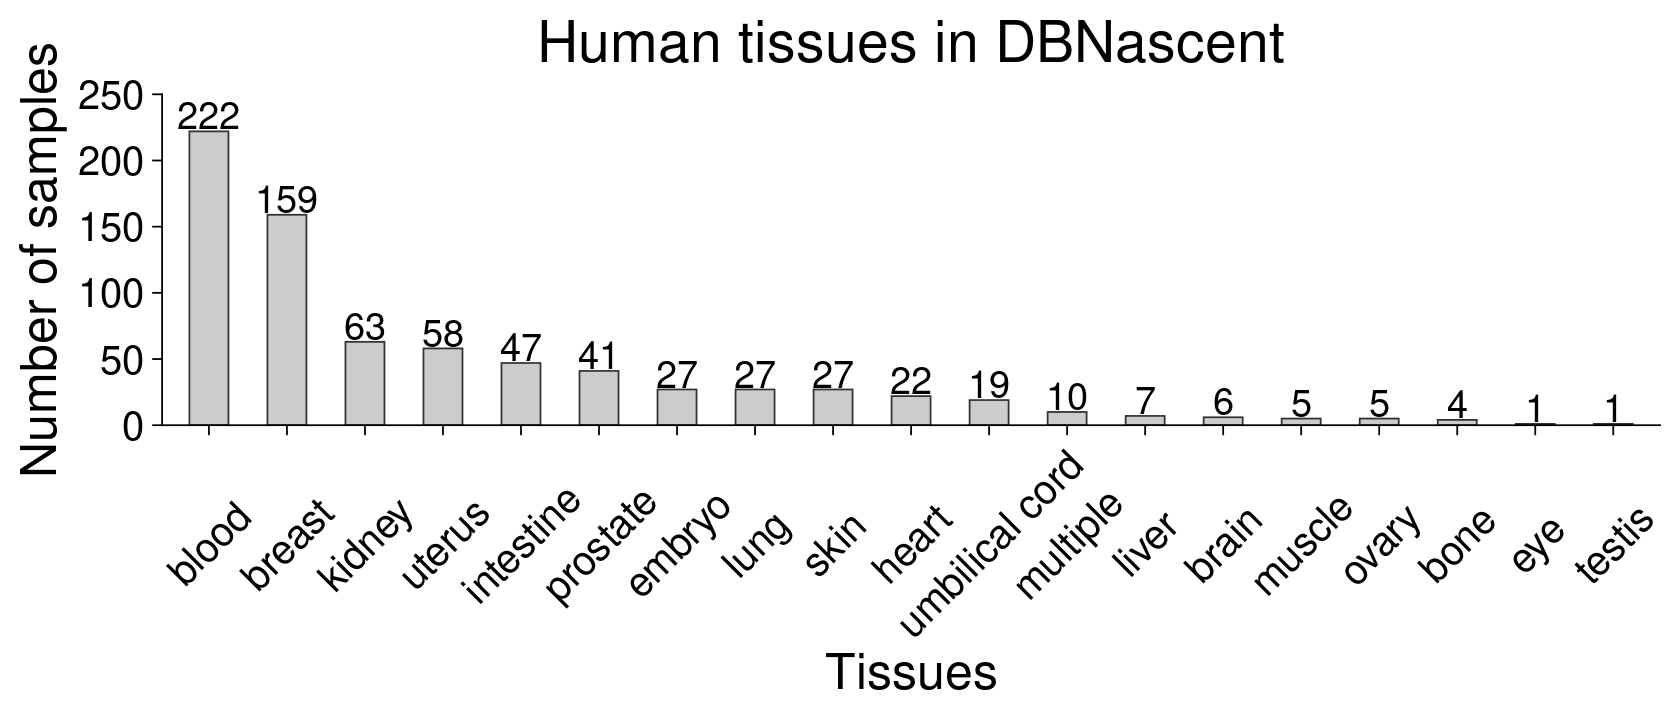

In [16]:
options(repr.plot.width=14, repr.plot.height=6)

tissue_counts_plot <- ggplot2::ggplot(tissue_counts_sort,
                                      aes(x=tissues,
                                          y=as.numeric(Freq))) +
geom_bar(stat="identity", width=0.5, color='gray20',fill="gray80")+
  scale_y_continuous(expand = c(0, 0)) +
labs(title="Human tissues in DBNascent",
     x="Tissues", 
     y = "Number of samples") + 
annotate("text",
         x=c(1:nrow(tissue_counts_sort)),
         y=tissue_counts_sort$Freq+12, 
         label= tissue_counts_sort$Freq, 
         size = 8) + 
theme_cowplot(24) +
coord_cartesian(ylim=c(0, 250)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24, angle=45, vjust=0.5, hjust=0.5),
     legend.position="none") 

tissue_counts_plot

In [17]:
ggsave(tissue_counts_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/tissue_counts_plot_reviews.pdf',
      bg = "transparent")

ggsave(tissue_counts_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/tissue_counts_plot_reviews.png',
      bg = "transparent")


## ChIA-PET loops

In [18]:
chiapet <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/3d_overlap/nascent_pairs_with_loop/hg38_dbnascent_pairs_with_all_chiapet_by_tissue.tsv.gz")
dim(chiapet)
head(chiapet)

[1] 4345395       2

pair_id,tissue
<chr>,<chr>
LARP4B-DT:NR_120629.1~chr10:969848-970172,blood
GTPBP4:NM_012341.3~chr10:791474-791828,blood
GTPBP4:NM_012341.3~chr10:974047-974607,blood
WDR37:NM_014023.4~chr10:106635-107175,blood
WDR37:NM_014023.4~chr10:974047-974607,blood
TASOR2:NR_135800.2~chr10:4944618-4945310,blood


In [19]:
as.data.frame(table(chiapet$tissue))

Var1,Freq
<fct>,<int>
blood,1081967
breast,864844
embryo,54144
heart,219636
intestine,436825
kidney,559170
lung,106708
prostate,521846
skin,118496


# Summary for pairs with loops

## Get pairs with loops

In [20]:
tissues <- unique(corr_sig_strict_DT$tissue)
tissues

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [21]:
corr_sig_loop_DT_list <- list()

for (i in tissues){

    #get loop pairs by tissue
    looped_tissue <- subset(chiapet, 
                            tissue==i)
    
    #get bidirectional - gene pair tissues
    corr_sig_DT_tissue <- subset(corr_sig_strict_DT, tissue==i) 
    
    #subset the pairs with loop by tissue
    corr_sig_DT_tissue_loop <- corr_sig_DT_tissue[corr_sig_DT_tissue$pair_id %in%
                                                 looped_tissue$pair_id,]
    
    #save pairs with loop by tissue
    corr_sig_loop_DT_list[[i]] <- corr_sig_DT_tissue_loop
    
}

In [22]:
lapply(corr_sig_loop_DT_list, nrow)

$blood
[1] 1081967

$breast
[1] 864844

$embryo
[1] 54144

$heart
[1] 219636

$intestine
[1] 436825

$kidney
[1] 559170

$lung
[1] 106708

$prostate
[1] 521846

$skin
[1] 118496

$`umbilical cord`
[1] 120480

$uterus
[1] 261279

## Number of transcripts

In [23]:
corr_sig_loop_DT <- do.call(rbind,corr_sig_loop_DT_list)
dim(corr_sig_loop_DT)

[1] 4345395      25

In [24]:
length(unique(corr_sig_loop_DT$transcript_1))
length(unique(corr_sig_loop_DT$transcript_2))

[1] 22503

[1] 341433

In [25]:
(length(unique(corr_sig_loop_DT$transcript_2))/847521)*100

[1] 40.28608

In [26]:
sig_strict_pairs <- data.frame(table(corr_sig_loop_DT$tissue))

sig_strict_pairs

Var1,Freq
<fct>,<int>
blood,1081967
breast,864844
embryo,54144
heart,219636
intestine,436825
kidney,559170
lung,106708
prostate,521846
skin,118496


## Position of bidirectional relative to TSS

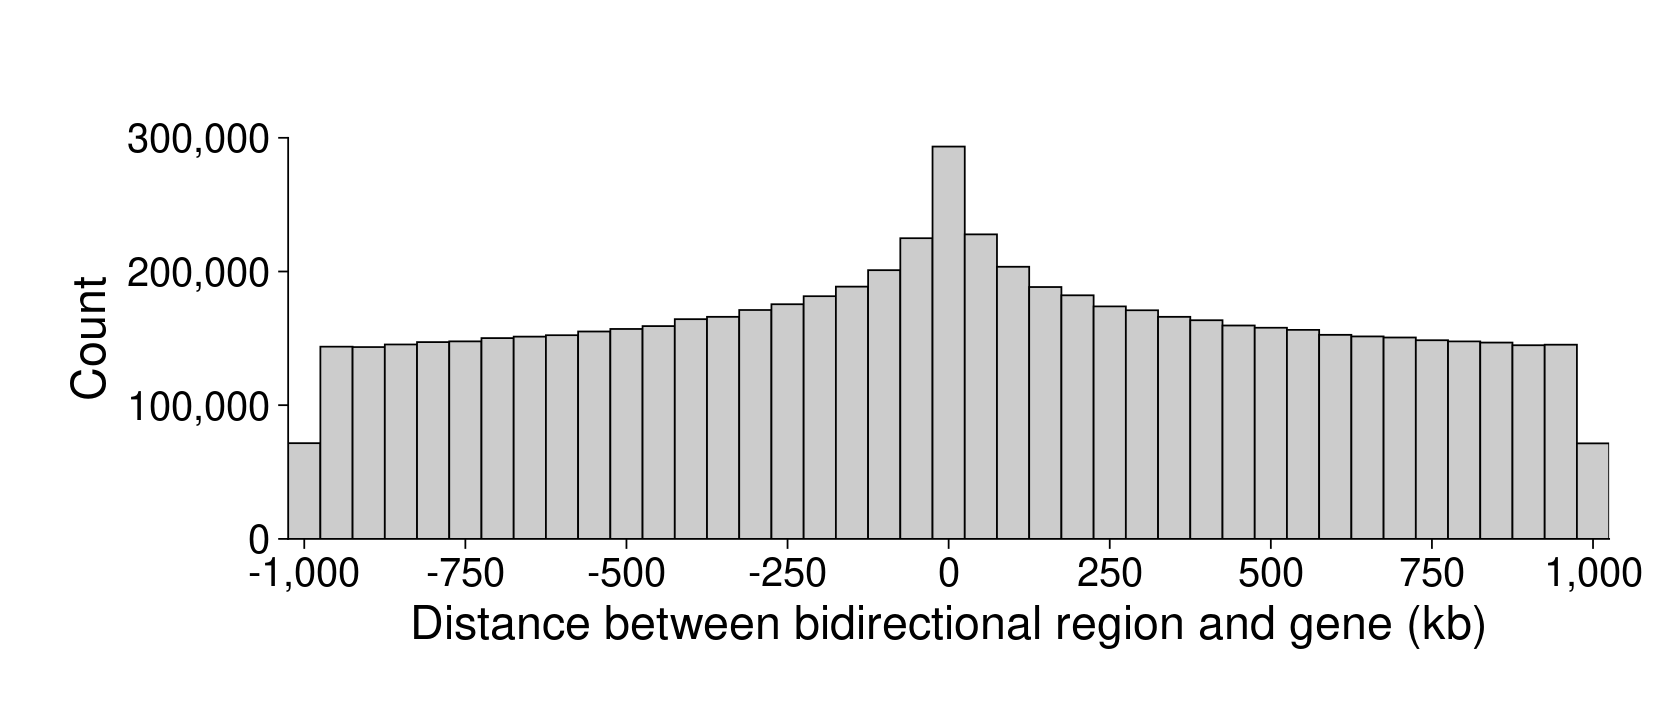

In [27]:
options(repr.plot.width=14, repr.plot.height=6)

gene_bidir_dist_nObs_hist <- ggplot(unique(corr_sig_DT[,c("transcript_1",
                                                         "transcript_2",
                                                         "distance_tss")]), 
                               aes(x=(distance_tss)/1000)) +
  geom_histogram(color="black", fill="gray80", binwidth=50) +
labs(title = " ", 
       y = "Count",
       x = "Distance between bidirectional region and gene (kb)") +
theme_cowplot(24) +
scale_x_continuous(expand = c(0, 0),
                   breaks=seq(-1000,1000,250),
                  labels = scales::comma) +
scale_y_continuous(expand = c(0, 0),
                   limits=c(0,300000),
                  labels = scales::comma) +
theme(plot.title = element_text(size = 30, hjust = 0.5),
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) +
 theme(plot.margin = margin(1.5,1.5,1.5,1.5, "cm"))

gene_bidir_dist_nObs_hist

In [28]:
ggsave(gene_bidir_dist_nObs_hist, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/distance_bidirs_gene_plot_reviews.pdf',
      bg = "transparent")

ggsave(gene_bidir_dist_nObs_hist, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/distance_bidirs_gene_plot_reviews.png',
      bg = "transparent")

In [29]:
#select bin width for histogram
binwidths_option <- 5

#plot histogram using ggplot2
gene_bidir_dist_nObs_hist2 <- ggplot(unique(corr_sig_loop_DT[,c("transcript_1",
                                                         "transcript_2",
                                                         "distance_tss")]), 
                                     aes(x=(distance_tss)/1000)) +
geom_histogram(color="black", fill="gray80", binwidth=binwidths_option)

#pull out the density information from histogram
gene_bidir_dist_nObs_hist_density <- ggplot_build(gene_bidir_dist_nObs_hist2)$data[[1]]$density

#generate the position data in the plot
distances_pairs <- seq(-1000,1000, binwidths_option)

rank_position <- seq(1, length(distances_pairs), 1 )

#create a table with the densities
position_pair_density <- data.table(distances=distances_pairs,
                                    density=gene_bidir_dist_nObs_hist_density,
                                   position=rank_position)

dim(position_pair_density)
head(position_pair_density)


[1] 401   3

distances,density,position
<dbl>,<dbl>,<dbl>
-1000,0.0001938941,1
-995,0.0003851270,2
-990,0.0003878621,3
-985,0.0003789916,4
-980,0.0003960673,5
-975,0.0003860141,6


In [30]:
position_pair_density_data <- data.frame(datatype=c("distances"), 
                                        size=nrow(position_pair_density))
position_pair_density_data

datatype,size
<chr>,<int>
distances,401


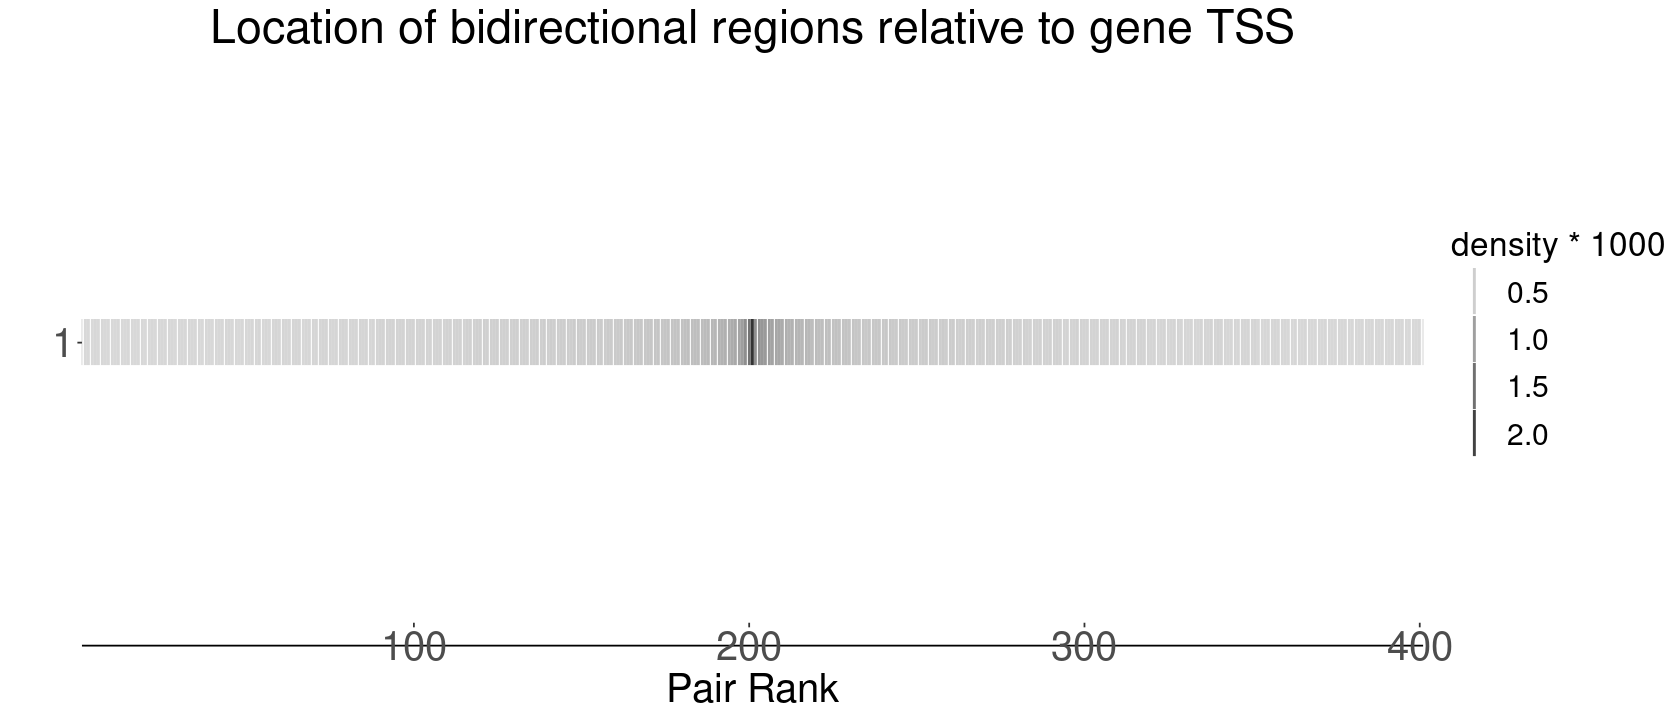

In [31]:
position_pair_density_plot <- ggplot(data=position_pair_density_data, 
                    aes(x=size, y=datatype)) +
#geom_bar(stat="identity", fill = 'white', color='black') +
geom_point(data = position_pair_density,
           aes(y = 1, 
               x = position,
               alpha=density*1000), 
           shape=124, 
           size=10,
           color="gray20"
           ) +
xlab("Pair Rank") +
ylab(" ") +
ggtitle("Location of bidirectional regions relative to gene TSS") +
theme_classic() +
scale_colour_manual(name="GTEx",
                    values = c("grey20", "red")) +
scale_x_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
scale_y_continuous(expand = c(0, 0), 
                   labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, 
                                face = "plain",
                                size = 28),
      axis.title = element_text(size = 24), 
      axis.text = element_text(size = 24),
      axis.text.x = element_text(size = 24),
      legend.title = element_text(size = 20),
      legend.text = element_text(size = 18))

position_pair_density_plot

In [32]:
names(ggplot_build(gene_bidir_dist_nObs_hist)$data[[1]])

[1] "y"           "count"       "x"           "xmin"        "xmax"       
 [6] "density"     "ncount"      "ndensity"    "flipped_aes" "PANEL"      
[11] "group"       "ymin"        "ymax"        "colour"      "fill"       
[16] "linewidth"   "linetype"    "alpha"

In [33]:
colnames(corr_sig_loop_DT)

[1] "transcript1_chrom"        "transcript1_start"       
 [3] "transcript1_stop"         "transcript_1"            
 [5] "transcript1_score"        "transcript1_strand"      
 [7] "transcript2_chrom"        "transcript2_start"       
 [9] "transcript2_stop"         "transcript_2"            
[11] "transcript2_score"        "transcript2_strand"      
[13] "pcc"                      "pval"                    
[15] "adj_p_BH"                 "nObs"                    
[17] "t"                        "distance_tss"            
[19] "distance_tes"             "position"                
[21] "tissue"                   "percent_transcribed_both"
[23] "bidirectional_location"   "pair_id"                 
[25] "gene_id"

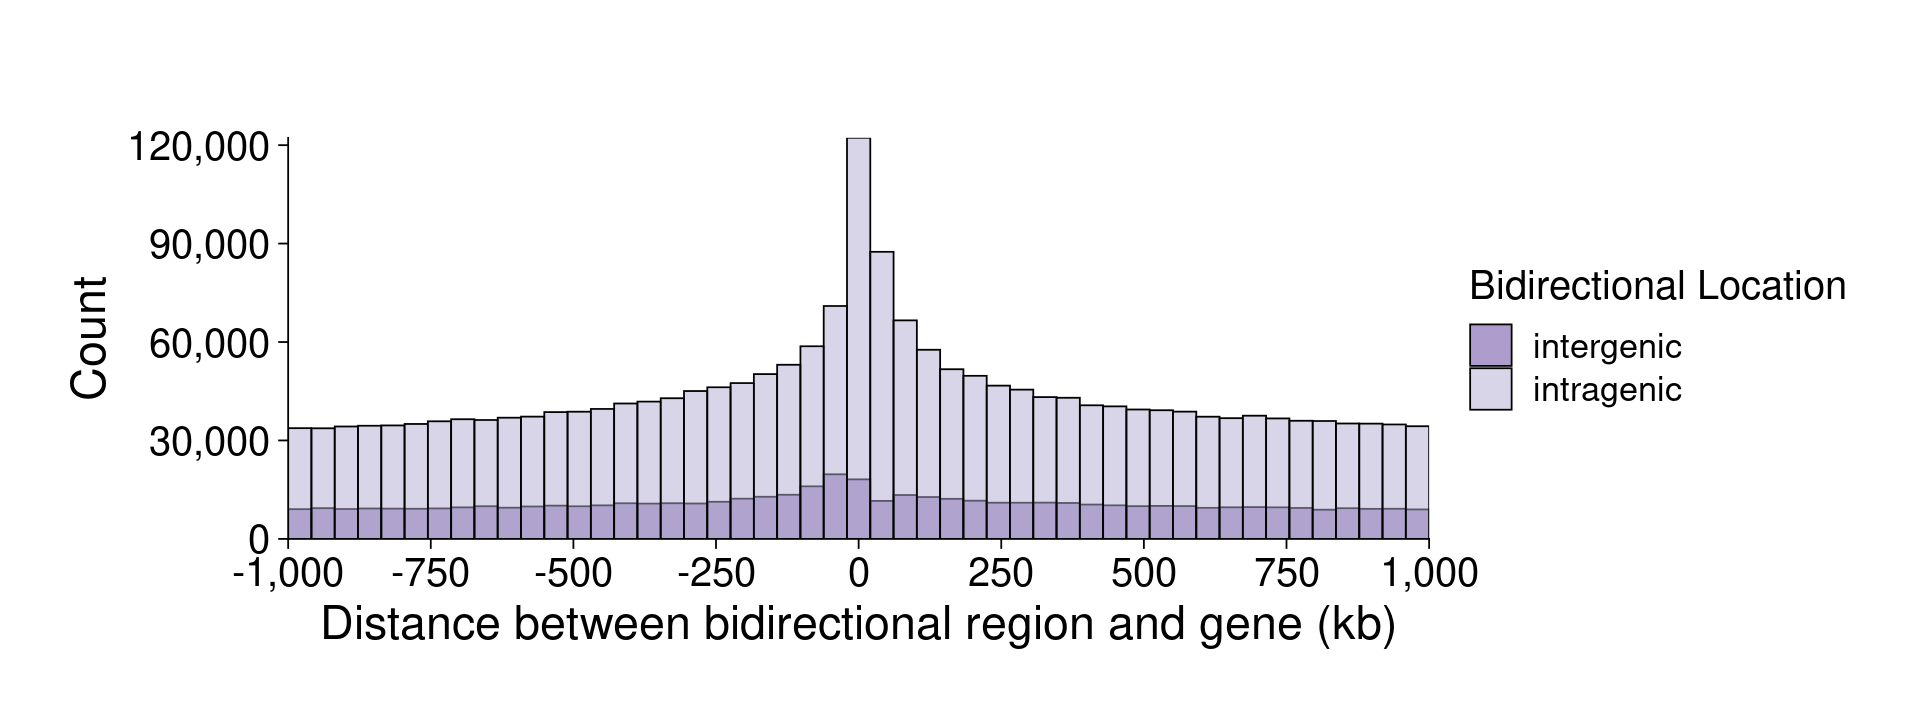

In [34]:
options(repr.plot.width=16, repr.plot.height=6)

gene_bidir_dist_hist_col <- ggplot(unique(corr_sig_loop_DT[,c("transcript_1",
                                                         "transcript_2",
                                                         "distance_tss", 
                                                         "bidirectional_location")]), 
                               aes(x=(distance_tss)/1000,
                                  fill=bidirectional_location)) +
  geom_histogram(color="black", bins = 50, alpha=0.5, position = 'identity') +
labs(title = " ", 
       y = "Count",
       x = "Distance between bidirectional region and gene (kb)") +
theme_cowplot(24) +
scale_x_continuous(expand = c(0, 0),
                   breaks=seq(-1000,1000,250),
                  labels = scales::comma) +
scale_y_continuous(expand = c(0, 0),
                   #limits=c(0,85000),
                  labels = scales::comma) +
scale_fill_manual(name="Bidirectional Location",
                  values=c("#5e3c99", "#b2abd2")) +
theme(plot.title = element_text(size = 30, hjust = 0.5),
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) +
 theme(plot.margin = margin(1.5,1.5,1.5,1.5, "cm"))

gene_bidir_dist_hist_col

In [35]:
corr_sig_strict_DT_inter <- subset(corr_sig_loop_DT, bidirectional_location=="intergenic")

corr_sig_strict_DT_intra <- subset(corr_sig_loop_DT, bidirectional_location=="intragenic")

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


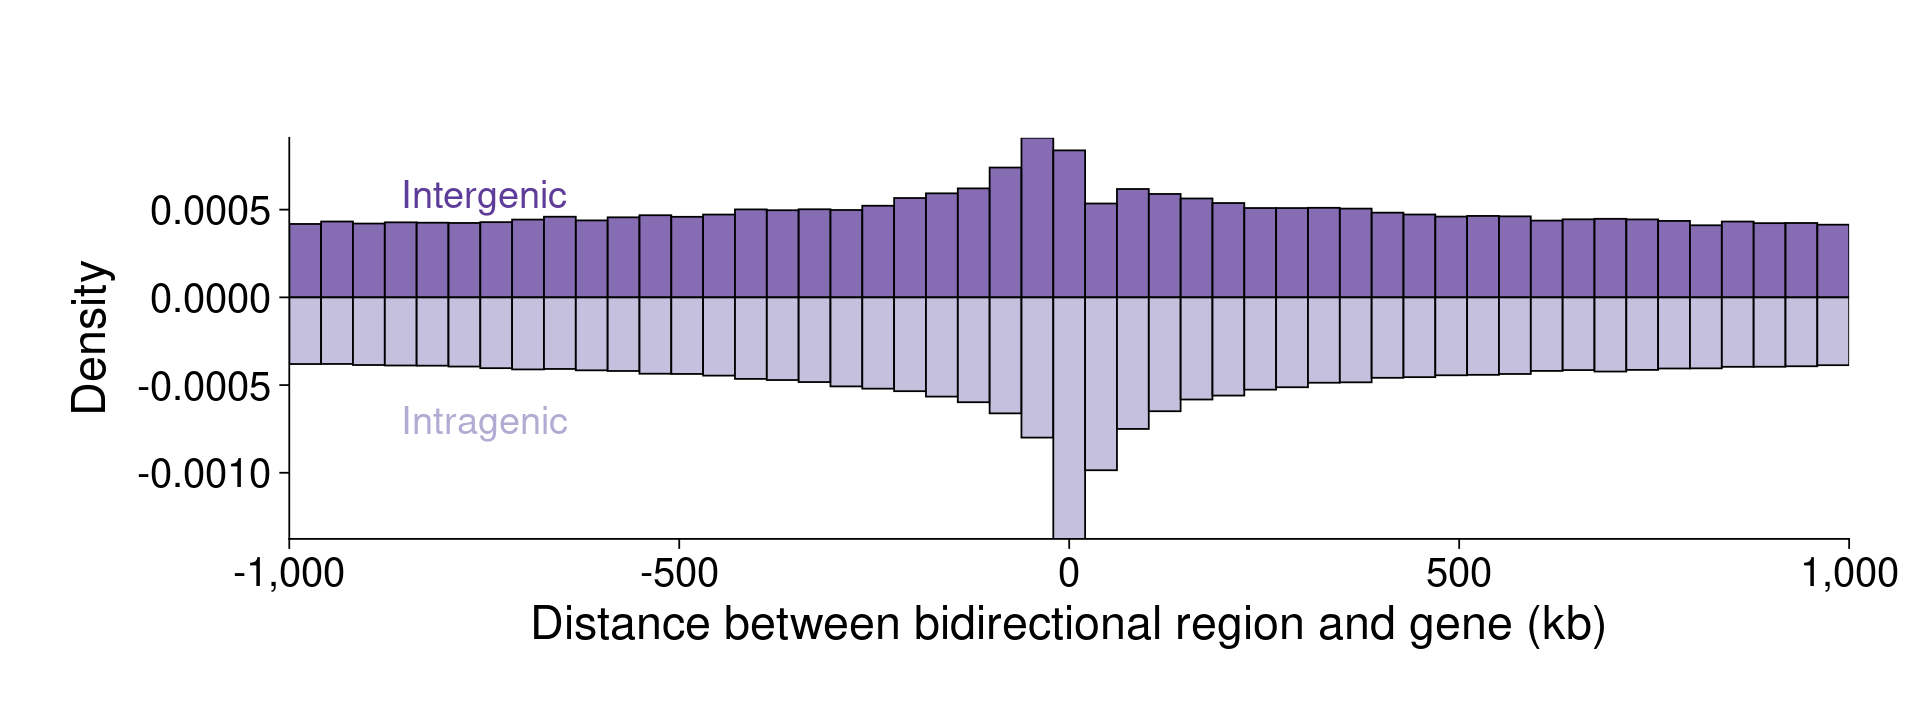

In [36]:
options(repr.plot.width=16, repr.plot.height=6)

gene_bidir_dist_hist_mirror <- ggplot() +
  geom_histogram(data=unique(corr_sig_strict_DT_inter[,c("transcript_1",
                                                         "transcript_2",
                                                         "distance_tss", 
                                                         "bidirectional_location")]),
                 color="black", bins = 50, alpha=0.75, position = 'identity', 
                aes(x=(distance_tss)/1000, y=..density..),
                fill="#5e3c99") +
  geom_histogram(data=unique(corr_sig_strict_DT_intra[,c("transcript_1",
                                                         "transcript_2",
                                                         "distance_tss", 
                                                         "bidirectional_location")]),
                 color="black", bins = 50, alpha=0.75, position = 'identity', 
                aes(x=(distance_tss)/1000, y=-..density..),
                fill="#b2abd2" #"#e66101"
                ) +
scale_x_continuous(expand = c(0, 0),
                  labels = scales::comma) +
scale_y_continuous(expand = c(0, 0),
                  labels = scales::comma) +
annotate(geom="text", x=-750, y=0.00059, 
         size=8,
         label="Intergenic",
         color="#5e3c99") +
annotate(geom="text", x=-750, y=-0.0007, 
         size=8,
         label="Intragenic",
         color="#b2abd2"#"#e66101"
        ) +
labs(title = " ", 
       y = "Density",
       x = "Distance between bidirectional region and gene (kb)") +
theme_cowplot(24) +
theme(plot.title = element_text(size = 30, hjust = 0.5),
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) +
 theme(plot.margin = margin(1.5,1.5,1.5,1.5, "cm"))

gene_bidir_dist_hist_mirror

## Number of bidirectionals per chromosome

In [37]:
#assign a pair id with gene-bidirectionals
corr_sig_DT_unique <- unique(corr_sig_loop_DT[,c('transcript1_chrom', 
                                            'pair_id',
                                            'transcript_1', 
                                            'transcript_2',
                                            'bidirectional_location')])
nrow(corr_sig_DT_unique)
head(corr_sig_DT_unique, 3)

[1] 2705601

transcript1_chrom,pair_id,transcript_1,transcript_2,bidirectional_location
<chr>,<chr>,<chr>,<chr>,<chr>
chr10,ZMYND11:NM_001202467.1~chr10:125590-125860,ZMYND11:NM_001202467.1,chr10:125590-125860,intergenic
chr10,ZMYND11:NM_001202467.1~chr10:978565-978731,ZMYND11:NM_001202467.1,chr10:978565-978731,intergenic
chr10,DIP2C:NM_014974.3~chr10:125590-125860,DIP2C:NM_014974.3,chr10:125590-125860,intergenic


In [38]:
##count the number of pairs per chromosome
num_sig_pairs <- as.data.frame(table(corr_sig_DT_unique$transcript1_chrom))
head(num_sig_pairs, 3)

,Var1,Freq
,<fct>,<int>
1,chr1,270522
2,chr10,61803
3,chr11,172686


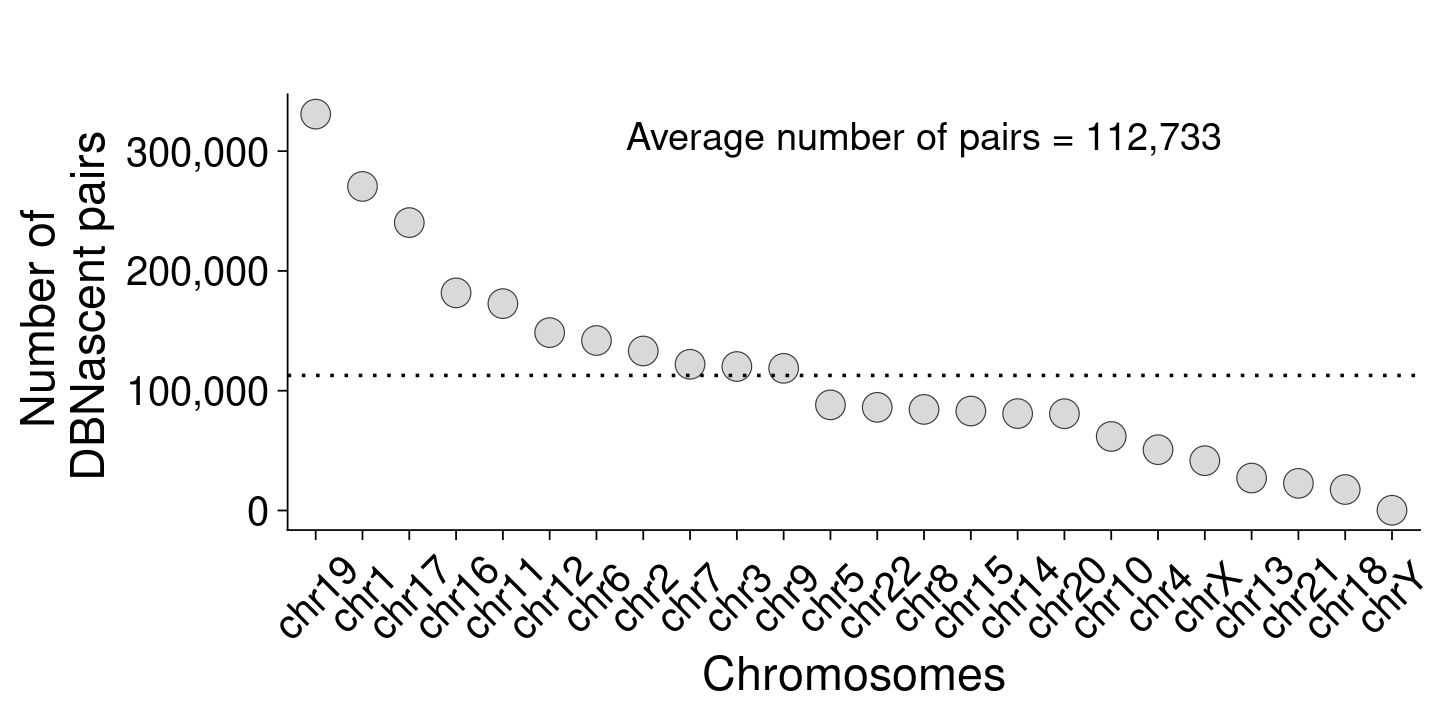

In [39]:
options(repr.plot.width=12, repr.plot.height=6)
num_pairs_plot <- ggplot(num_sig_pairs, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Freq)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=8, 
           fill='gray80',
          color='black') +
geom_hline(yintercept = mean(num_sig_pairs$Freq),
           linetype="dotted", 
           color = "black", 
           linewidth=1) +
ggtitle(" ") +
ylab("Number of \n DBNascent pairs") + 
xlab("Chromosomes") +
annotate(geom="text", x=14, y=mean(num_sig_pairs$Freq)+200000, 
         size=8,
         label=paste0("Average number of pairs = ", 
                      scales::comma(round(mean(num_sig_pairs$Freq)))),
         color="black") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24,
                                 angle=45,
                                 hjust=0.5,
                                vjust=0.5),
      axis.text.y = element_text(size = 24)) 

num_pairs_plot

In [40]:
##count the number of pairs per chromosome
num_sig_pairs_bidir_type <- as.data.frame(table(corr_sig_DT_unique[,c('transcript1_chrom','bidirectional_location')]))
head(num_sig_pairs_bidir_type, 3)

,transcript1_chrom,bidirectional_location,Freq
,<fct>,<fct>,<int>
1,chr1,intergenic,56559
2,chr10,intergenic,14407
3,chr11,intergenic,25761


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


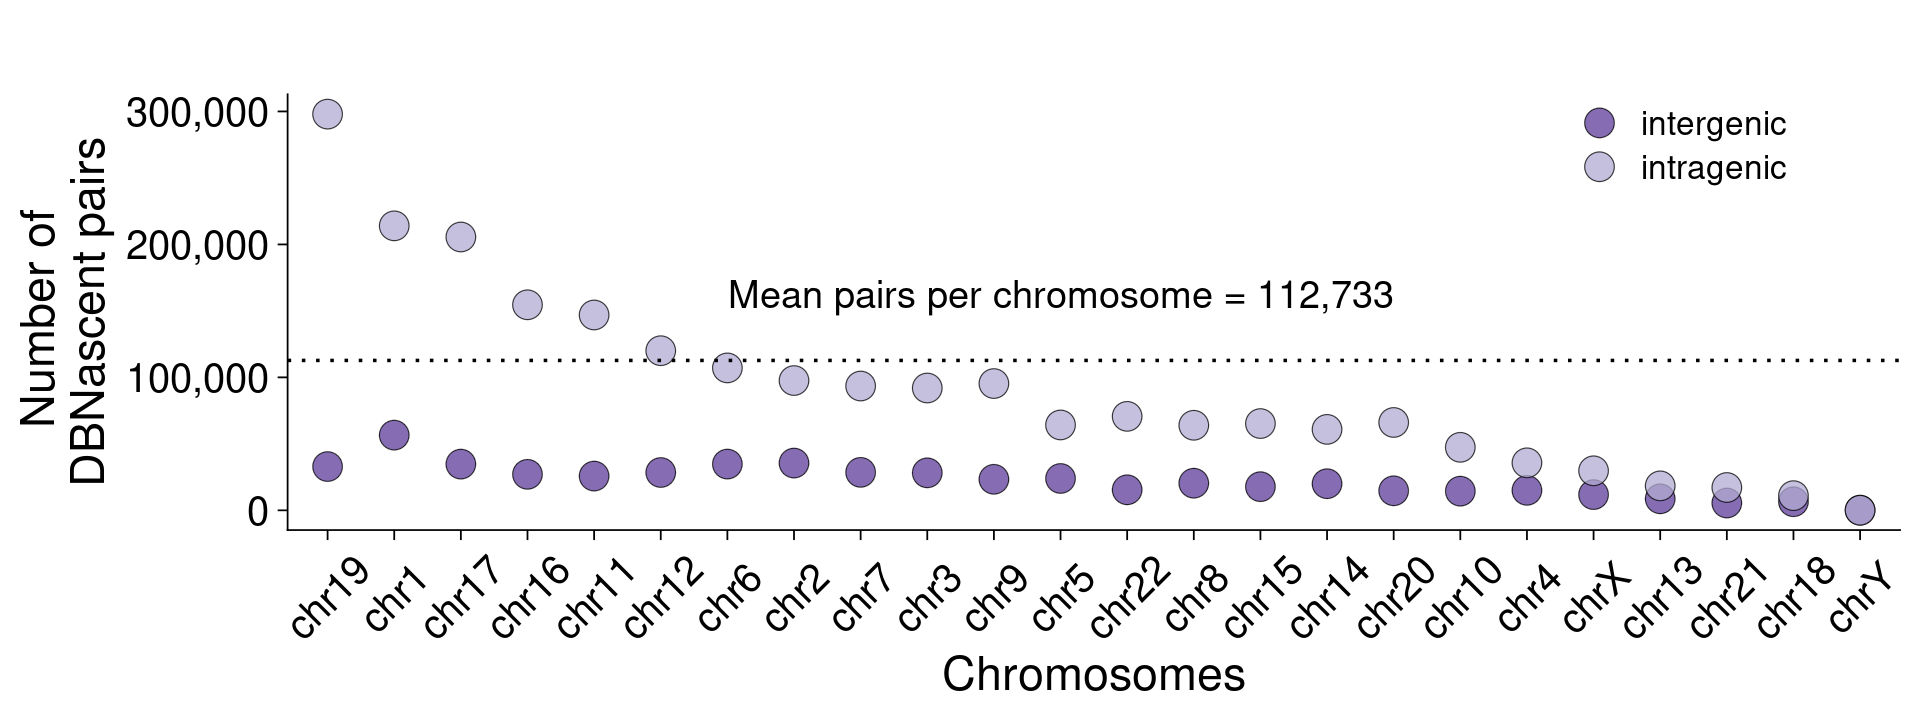

In [41]:
options(repr.plot.width=16, repr.plot.height=6)
num_pairs_plot <- ggplot(num_sig_pairs_bidir_type, 
                       aes(x=reorder(transcript1_chrom, -Freq), 
                           y=Freq, fill=bidirectional_location)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=8, 
           #fill='gray80',
          color='black') +
geom_hline(yintercept = mean(num_sig_pairs$Freq),
           linetype="dotted", 
           color = "black", 
           size=1) +
ggtitle(" ") +
ylab("Number of \nDBNascent pairs") + 
xlab("Chromosomes") +
annotate(geom="text", x=12, y=mean(num_sig_pairs$Freq)+50000, 
         size=8,
         label=paste0("Mean pairs per chromosome = ", 
                      scales::comma(round(mean(num_sig_pairs$Freq)))),
         color="black") +
scale_fill_manual(name=" ",
                  values=c("#5e3c99", "#b2abd2")) +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      legend.title = element_text(size = 24),
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24,
                                 angle=45,
                                 hjust=0.5,
                                vjust=0.5),
      axis.text.y = element_text(size = 24))  +
theme(legend.position = "inside", 
      legend.position.inside = c(0.8, 0.95),
      legend.text=element_text(size=20))

num_pairs_plot

## Bidirectionals assigned to a gene

In [42]:
##count the number of pairs regarless of the tissue
num_bidirs_per_gene <- as.data.frame(table(corr_sig_DT_unique$transcript_1))
head(num_bidirs_per_gene, 3)

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2,198
2,A1BG:NM_130786.4,150
3,A1CF:NM_014576.4,21


In [43]:
#Merge the gene bidir count summaries with transcription metadata for the genes
num_bidirs_per_gene_inter_summary <- merge(gene_bidir_tpm_summary_allBidirs_filteredSamples, 
                                          num_bidirs_per_gene,
                                          by.x='gene_transcript', 
                                          by.y='Var1')

nrow(num_bidirs_per_gene_inter_summary)
head(num_bidirs_per_gene_inter_summary, 3)

[1] 22503

gene_transcript,chrom,start,stop,score,strand,length,stdev,variance,sum,⋯,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type,gene_id,Freq
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<int>
A1BG-AS1:NR_015380.2,chr19,58352719,58355183,.,+,2465,4.9455980,24.4589397,3743.83340,⋯,3.660514012,0.9920698,45.616168,0,730,97.20373,genes,genes,A1BG-AS1,198
A1BG:NM_130786.4,chr19,58345182,58352742,.,-,7561,1.1286692,1.2738941,918.34440,⋯,0.929043716,0.9229986,12.266590,0,749,99.73369,genes,genes,A1BG,150
A1CF:NM_014576.4,chr10,50799408,50884877,.,-,85470,0.6778974,0.4595449,65.05839,⋯,0.001765096,7.8252931,9.269292,0,529,70.43941,genes,genes,A1CF,21


In [44]:
gene_bidir_tpm_summary_allBidirs_filteredSamples_genes <- subset(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                                                transcript_type=='genes')

print(paste("Percent of genes linked to bidirectional =",
            (nrow(num_bidirs_per_gene)/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_genes))*100))

[1] "Percent of genes linked to bidirectional = 77.8947004049984"


### All bidirectionals

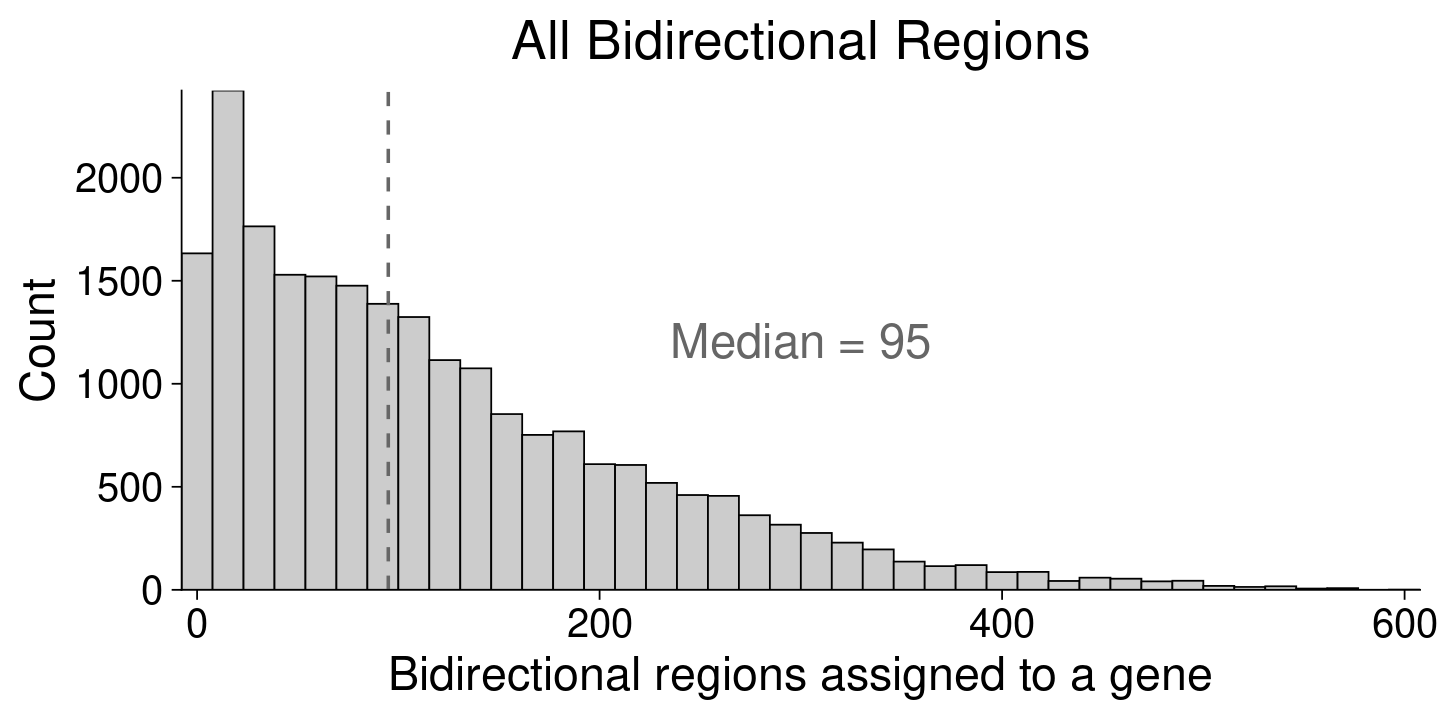

In [45]:
options(repr.plot.width=12, repr.plot.height=6)

num_bidirs_per_gene_plot <- ggplot(num_bidirs_per_gene, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_bidirs_per_gene$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("All Bidirectional Regions") +
xlab("Bidirectional regions assigned to a gene") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_bidirs_per_gene_plot2 <- num_bidirs_per_gene_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_bidirs_per_gene$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_bidirs_per_gene_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_bidirs_per_gene$Freq))),
                                          color="gray40")

num_bidirs_per_gene_plot2

In [46]:
ggsave(num_bidirs_per_gene_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_plot_reviews.png',
      bg = "transparent")

### Intergenic

In [47]:
##count the number of pairs regarless of the tissue
num_bidirs_per_gene_bidir <- as.data.frame(table(corr_sig_DT_unique[,c("transcript_1","bidirectional_location")]))
head(num_bidirs_per_gene_bidir, 3)

,transcript_1,bidirectional_location,Freq
,<fct>,<fct>,<int>
1,A1BG-AS1:NR_015380.2,intergenic,6
2,A1BG:NM_130786.4,intergenic,12
3,A1CF:NM_014576.4,intergenic,6


In [48]:
num_bidirs_per_gene_inter <- subset(num_bidirs_per_gene_bidir, 
                                    bidirectional_location=='intergenic' & Freq!=0)
round(median(num_bidirs_per_gene_inter$Freq))
head(num_bidirs_per_gene_inter)


[1] 20

,transcript_1,bidirectional_location,Freq
,<fct>,<fct>,<int>
1,A1BG-AS1:NR_015380.2,intergenic,6
2,A1BG:NM_130786.4,intergenic,12
3,A1CF:NM_014576.4,intergenic,6
4,A2M-AS1:NR_026971.1,intergenic,34
5,A2M:NM_000014.6,intergenic,17
6,A2ML1:NM_001282424.3,intergenic,5


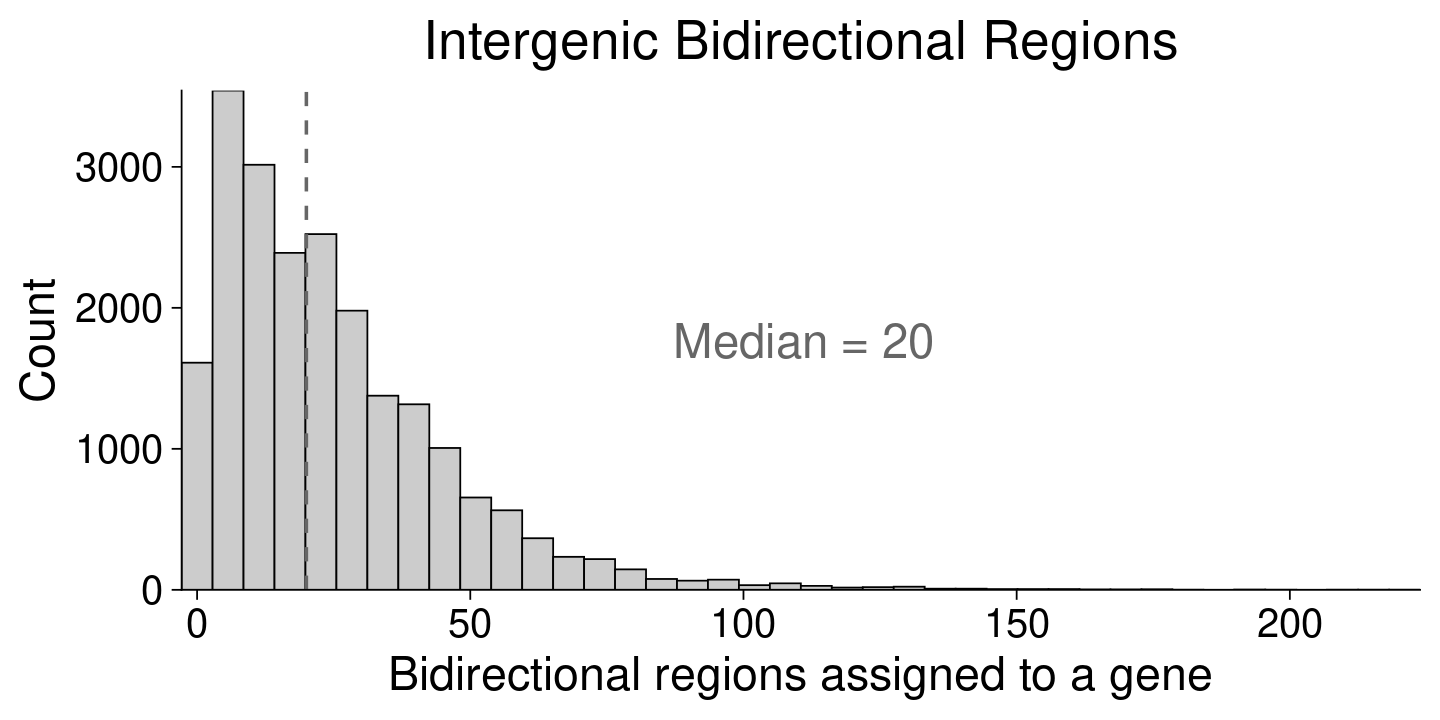

In [49]:
options(repr.plot.width=12, repr.plot.height=6)

num_bidirs_per_gene_inter_plot <- ggplot(num_bidirs_per_gene_inter, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_bidirs_per_gene_inter$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Intergenic Bidirectional Regions") +
xlab("Bidirectional regions assigned to a gene") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_bidirs_per_gene_inter_plot2 <- num_bidirs_per_gene_inter_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_bidirs_per_gene_inter$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_bidirs_per_gene_inter_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_bidirs_per_gene_inter$Freq))),
                                          color="gray40")

num_bidirs_per_gene_inter_plot2

In [50]:
ggsave(num_bidirs_per_gene_inter_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_inter_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_inter_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_inter_plot_reviews.png',
      bg = "transparent")

### Intragenic

In [51]:
num_bidirs_per_gene_intra <- subset(num_bidirs_per_gene_bidir, 
                                    bidirectional_location!='intergenic' & Freq!=0)
round(median(num_bidirs_per_gene_intra$Freq))
head(num_bidirs_per_gene_intra)

[1] 69

,transcript_1,bidirectional_location,Freq
,<fct>,<fct>,<int>
22504,A1BG-AS1:NR_015380.2,intragenic,192
22505,A1BG:NM_130786.4,intragenic,138
22506,A1CF:NM_014576.4,intragenic,15
22507,A2M-AS1:NR_026971.1,intragenic,117
22508,A2M:NM_000014.6,intragenic,34
22509,A2ML1:NM_001282424.3,intragenic,20


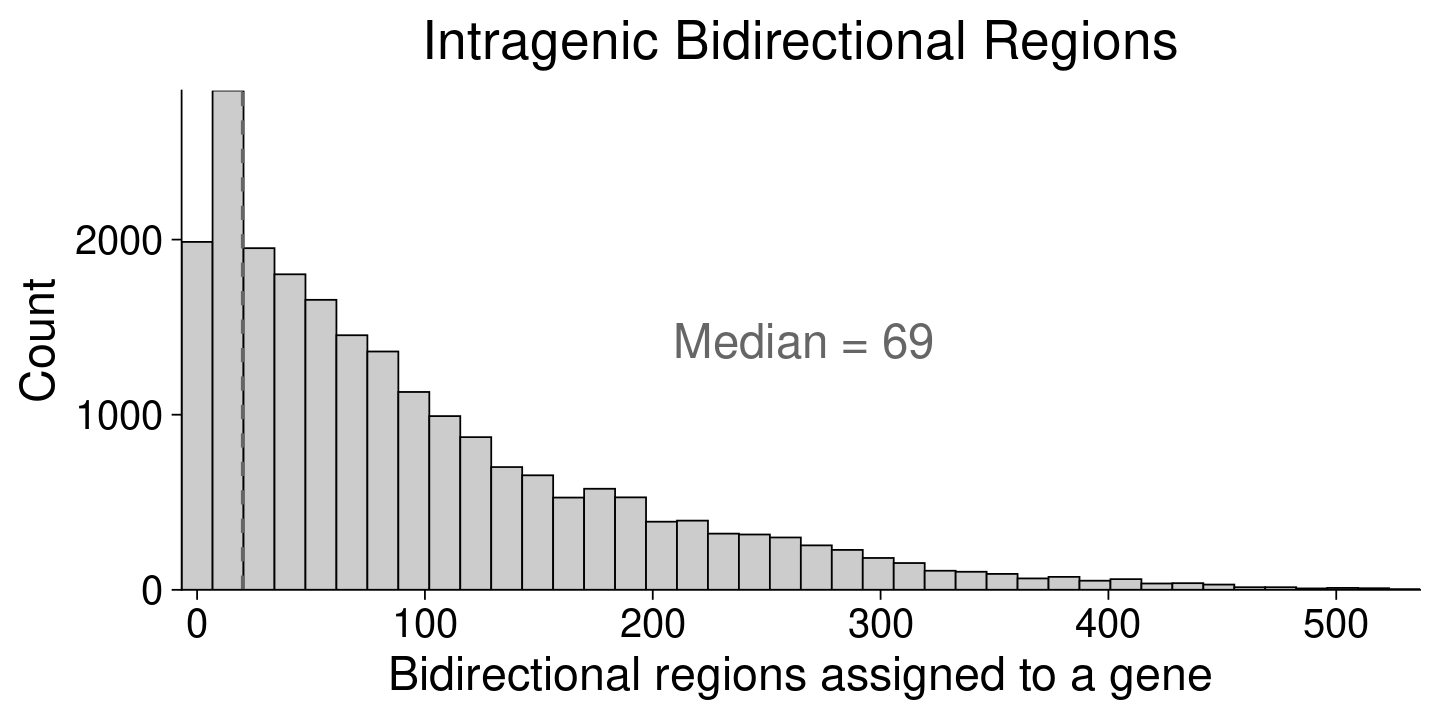

In [52]:
options(repr.plot.width=12, repr.plot.height=6)

num_bidirs_per_gene_intra_plot <- ggplot(num_bidirs_per_gene_intra, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_bidirs_per_gene_inter$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Intragenic Bidirectional Regions") +
xlab("Bidirectional regions assigned to a gene") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_bidirs_per_gene_intra_plot2 <- num_bidirs_per_gene_intra_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_bidirs_per_gene_intra$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_bidirs_per_gene_intra_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_bidirs_per_gene_intra$Freq))),
                                          color="gray40")

num_bidirs_per_gene_intra_plot2

In [53]:
ggsave(num_bidirs_per_gene_intra_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_intra_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_intra_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_intra_plot_reviews.png',
      bg = "transparent")

## Genes linked to a bidirectional

In [54]:
num_genes_per_bidir <- as.data.frame(table(corr_sig_DT_unique$transcript_2))
head(num_genes_per_bidir, 3)

,Var1,Freq
,<fct>,<int>
1,chr1:1000004-1000574,28
2,chr1:100006945-100007111,4
3,chr1:100009030-100009356,10


In [55]:
num_genes_per_bidir_summary <- merge(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                           num_genes_per_bidir,
                                          by.x='gene_transcript', 
                                          by.y='Var1')
nrow(num_genes_per_bidir_summary)

[1] 341433

In [56]:
gene_bidir_tpm_summary_allBidirs_filteredSamples_bidirs <- subset(gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                                                transcript_type !='genes')

print(paste("Percent of bidirectionals linked to genes =",
            (nrow(num_genes_per_bidir)/nrow(gene_bidir_tpm_summary_allBidirs_filteredSamples_bidirs))*100))

[1] "Percent of bidirectionals linked to genes = 40.2860814068324"


### All bidirectionals

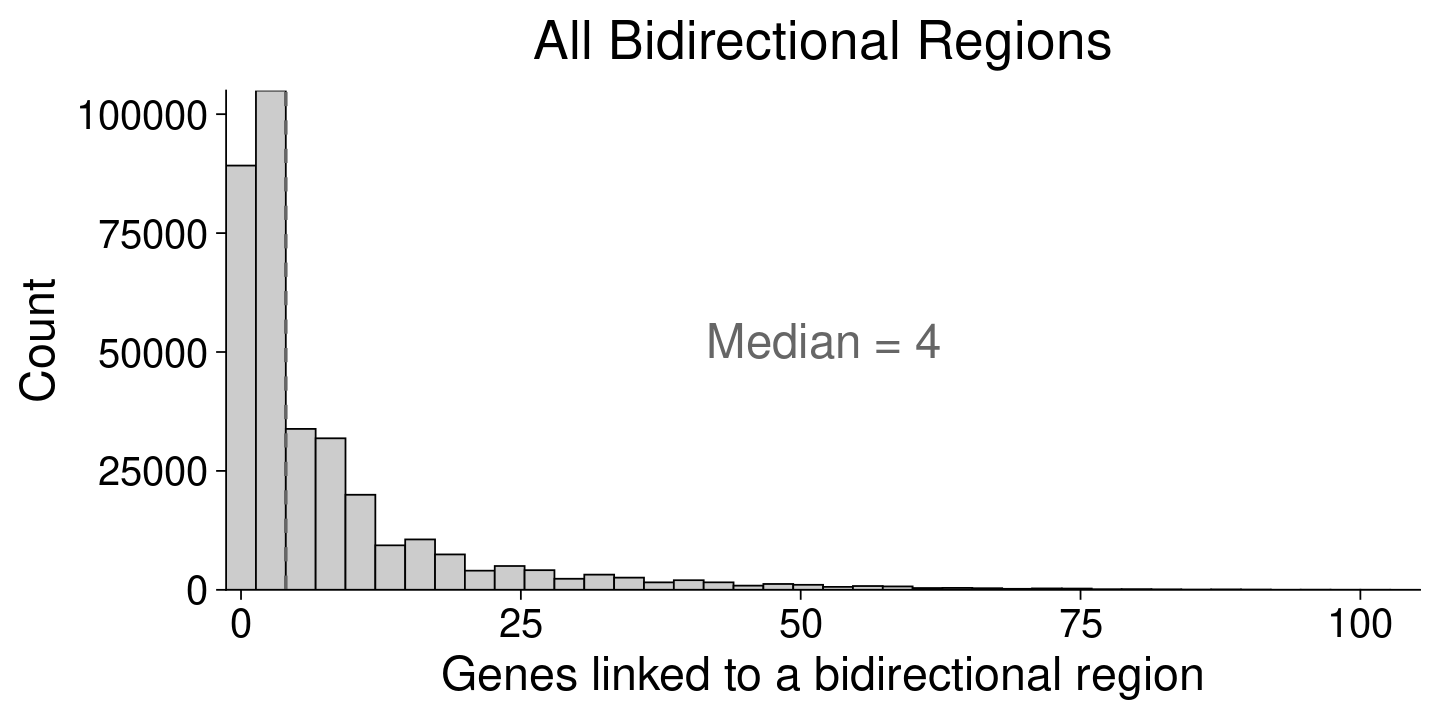

In [57]:
options(repr.plot.width=12, repr.plot.height=6)

num_genes_per_bidir_plot <- ggplot(num_genes_per_bidir, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_genes_per_bidir$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("All Bidirectional Regions") +
xlab("Genes linked to a bidirectional region") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_genes_per_bidir_plot2 <- num_genes_per_bidir_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_genes_per_bidir$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_genes_per_bidir_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_genes_per_bidir$Freq))),
                                          color="gray40")

num_genes_per_bidir_plot2

In [58]:
ggsave(num_genes_per_bidir_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_plot_reviews.png',
      bg = "transparent")

In [59]:
##count the number of pairs regarless of the tissue
num_genes_per_bidir_bidir <- as.data.frame(table(corr_sig_DT_unique[,c("transcript_2","bidirectional_location")]))
head(num_genes_per_bidir_bidir, 3)

,transcript_2,bidirectional_location,Freq
,<fct>,<fct>,<int>
1,chr1:1000004-1000574,intergenic,0
2,chr1:100006945-100007111,intergenic,0
3,chr1:100009030-100009356,intergenic,0


### Intergenic

In [60]:
num_genes_per_bidir_inter <- subset(num_genes_per_bidir_bidir, 
                                    bidirectional_location=='intergenic' & Freq!=0)
round(median(num_genes_per_bidir_inter$Freq))
head(num_bidirs_per_gene_inter, 3)

[1] 3

,transcript_1,bidirectional_location,Freq
,<fct>,<fct>,<int>
1,A1BG-AS1:NR_015380.2,intergenic,6
2,A1BG:NM_130786.4,intergenic,12
3,A1CF:NM_014576.4,intergenic,6


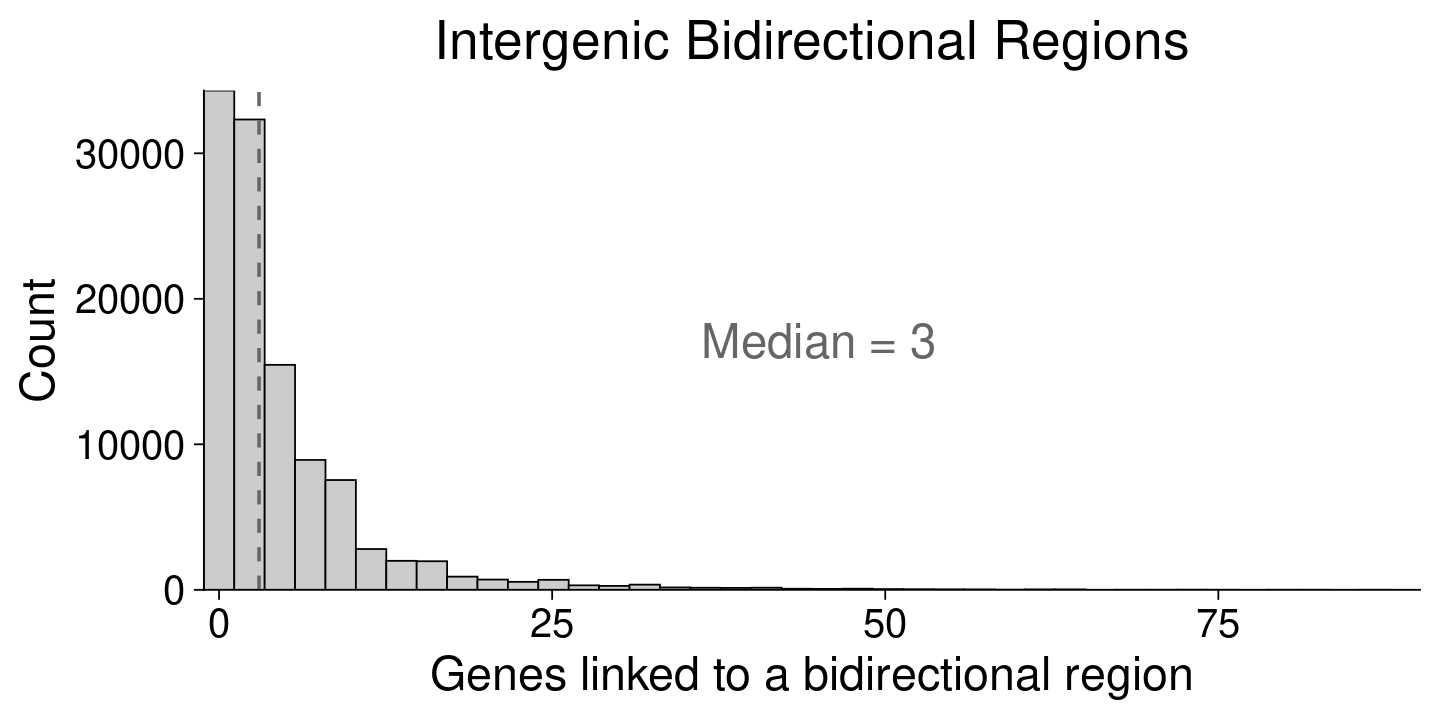

In [61]:
options(repr.plot.width=12, repr.plot.height=6)

num_genes_per_bidir_inter_plot <- ggplot(num_genes_per_bidir_inter, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_genes_per_bidir_inter$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Intergenic Bidirectional Regions") +
xlab("Genes linked to a bidirectional region") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_genes_per_bidir_inter_plot2 <- num_genes_per_bidir_inter_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_genes_per_bidir_inter$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_genes_per_bidir_inter_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_genes_per_bidir_inter$Freq))),
                                          color="gray40")

num_genes_per_bidir_inter_plot2

In [62]:
ggsave(num_genes_per_bidir_inter_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_inter_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_inter_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_inter_plot_reviews.png',
      bg = "transparent")

### Intragenic

In [63]:
num_genes_per_bidir_intra <- subset(num_genes_per_bidir_bidir, 
                                    bidirectional_location!='intergenic' & Freq!=0)
round(median(num_genes_per_bidir_intra$Freq))
head(num_bidirs_per_gene_intra)

[1] 4

,transcript_1,bidirectional_location,Freq
,<fct>,<fct>,<int>
22504,A1BG-AS1:NR_015380.2,intragenic,192
22505,A1BG:NM_130786.4,intragenic,138
22506,A1CF:NM_014576.4,intragenic,15
22507,A2M-AS1:NR_026971.1,intragenic,117
22508,A2M:NM_000014.6,intragenic,34
22509,A2ML1:NM_001282424.3,intragenic,20


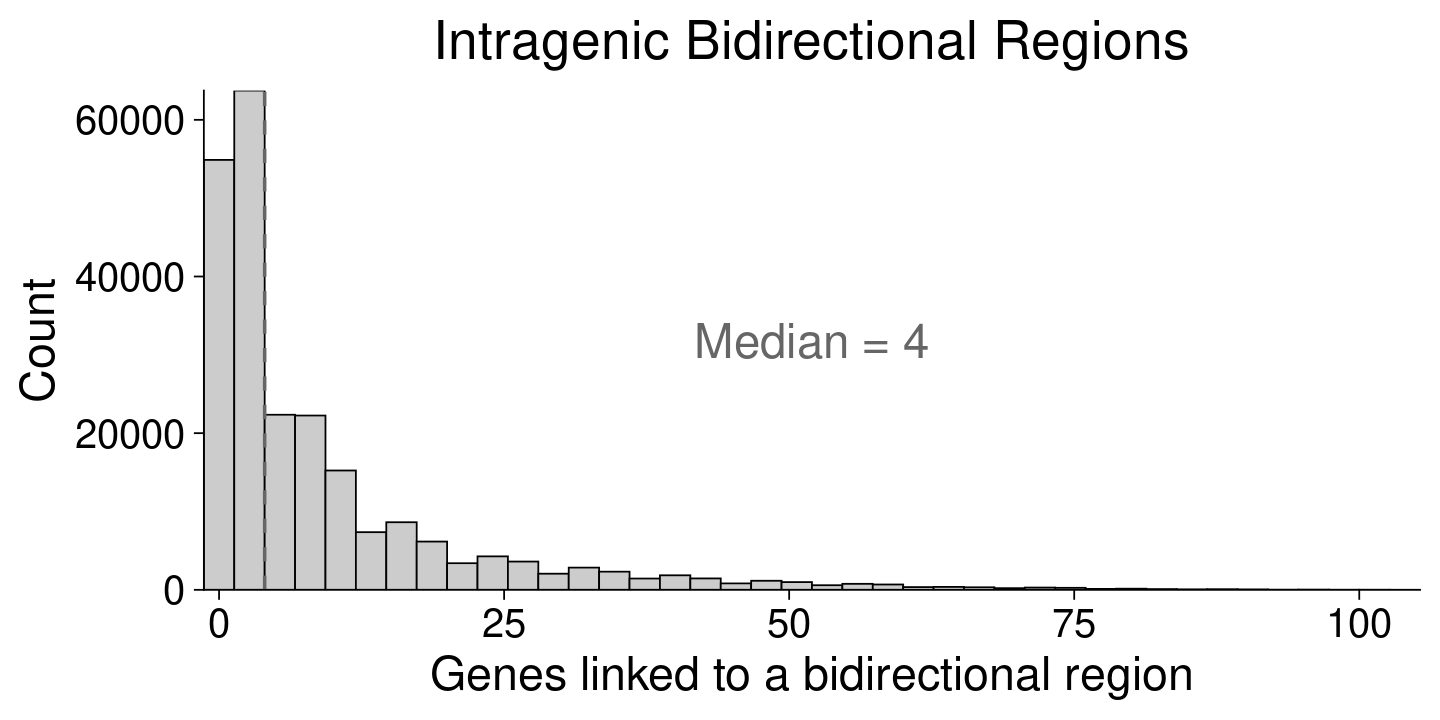

In [64]:
options(repr.plot.width=12, repr.plot.height=6)

num_genes_per_bidir_intra_plot <- ggplot(num_genes_per_bidir_intra, aes(x = Freq)) + 
geom_histogram(color="black", fill="gray80", bins=40) +
theme_cowplot(24) + 
geom_vline(xintercept = median(num_genes_per_bidir_intra$Freq),
           linetype="dashed", 
           color = "gray40", 
           size=1) +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Intragenic Bidirectional Regions") +
xlab("Genes linked to a bidirectional region") +
ylab("Count") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

num_genes_per_bidir_intra_plot2 <- num_genes_per_bidir_intra_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_genes_per_bidir_intra$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_genes_per_bidir_intra_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_genes_per_bidir_intra$Freq))),
                                          color="gray40")

num_genes_per_bidir_intra_plot2

In [65]:
ggsave(num_genes_per_bidir_intra_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_intra_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_intra_plot2, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_intra_plot_reviews.png',
      bg = "transparent")

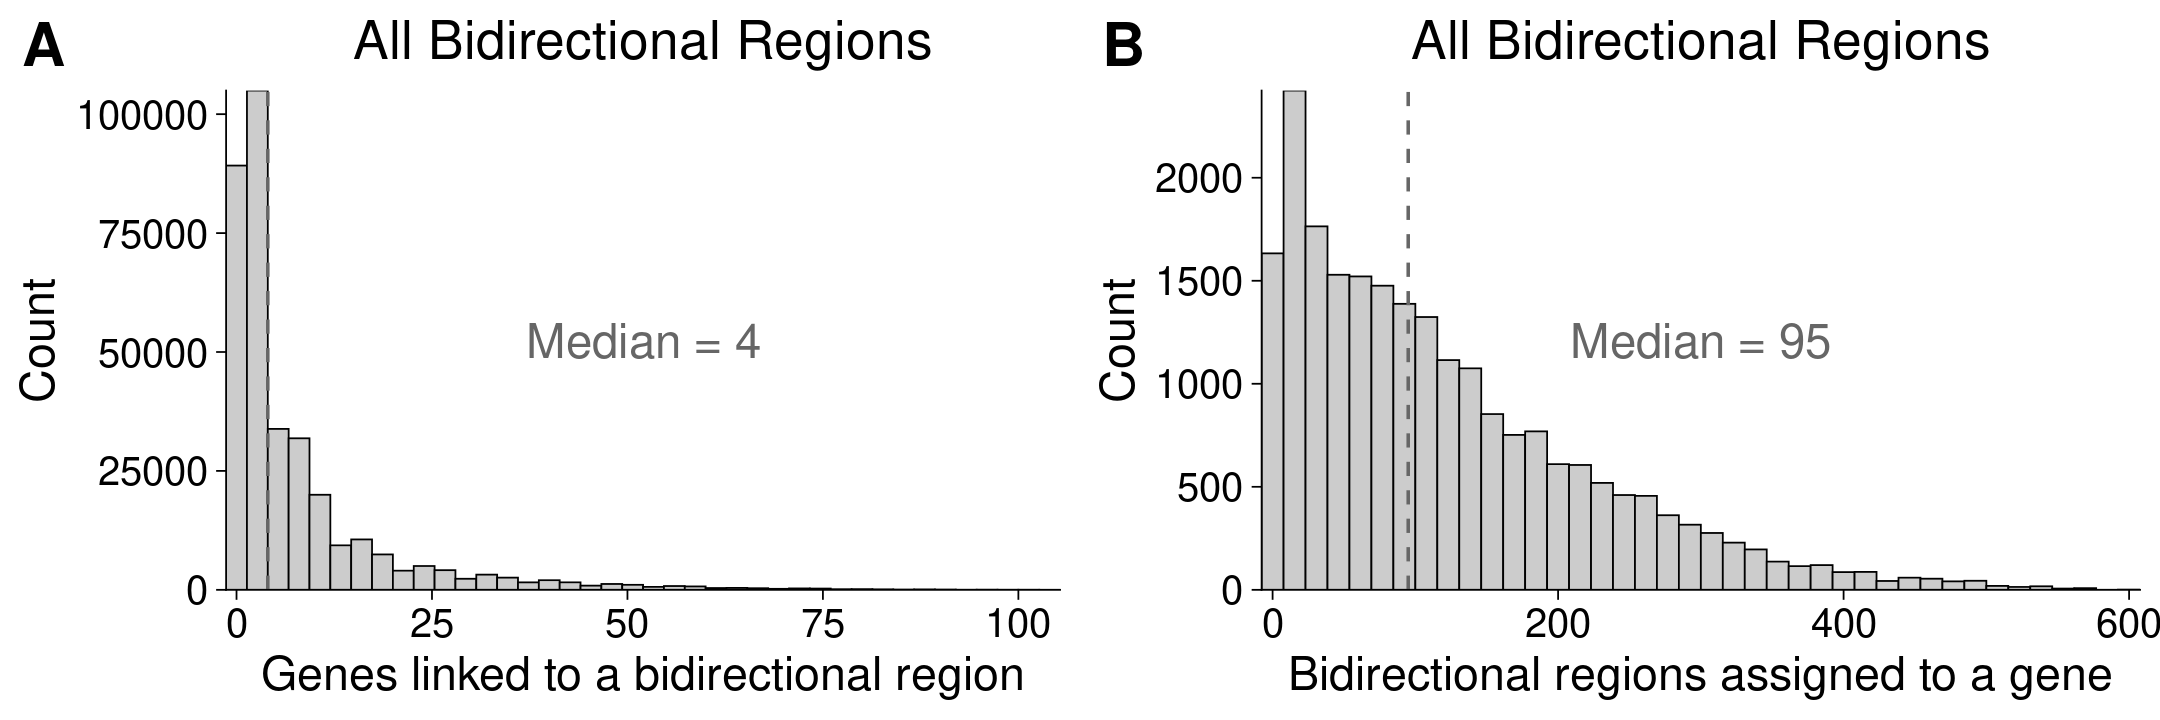

In [66]:
options(repr.plot.width=18, repr.plot.height=6)

cowplot::plot_grid(num_genes_per_bidir_plot2, 
                   num_bidirs_per_gene_plot2,
                   nrow=1,
                   labels = c('A', 'B'),
                   label_size = 36)

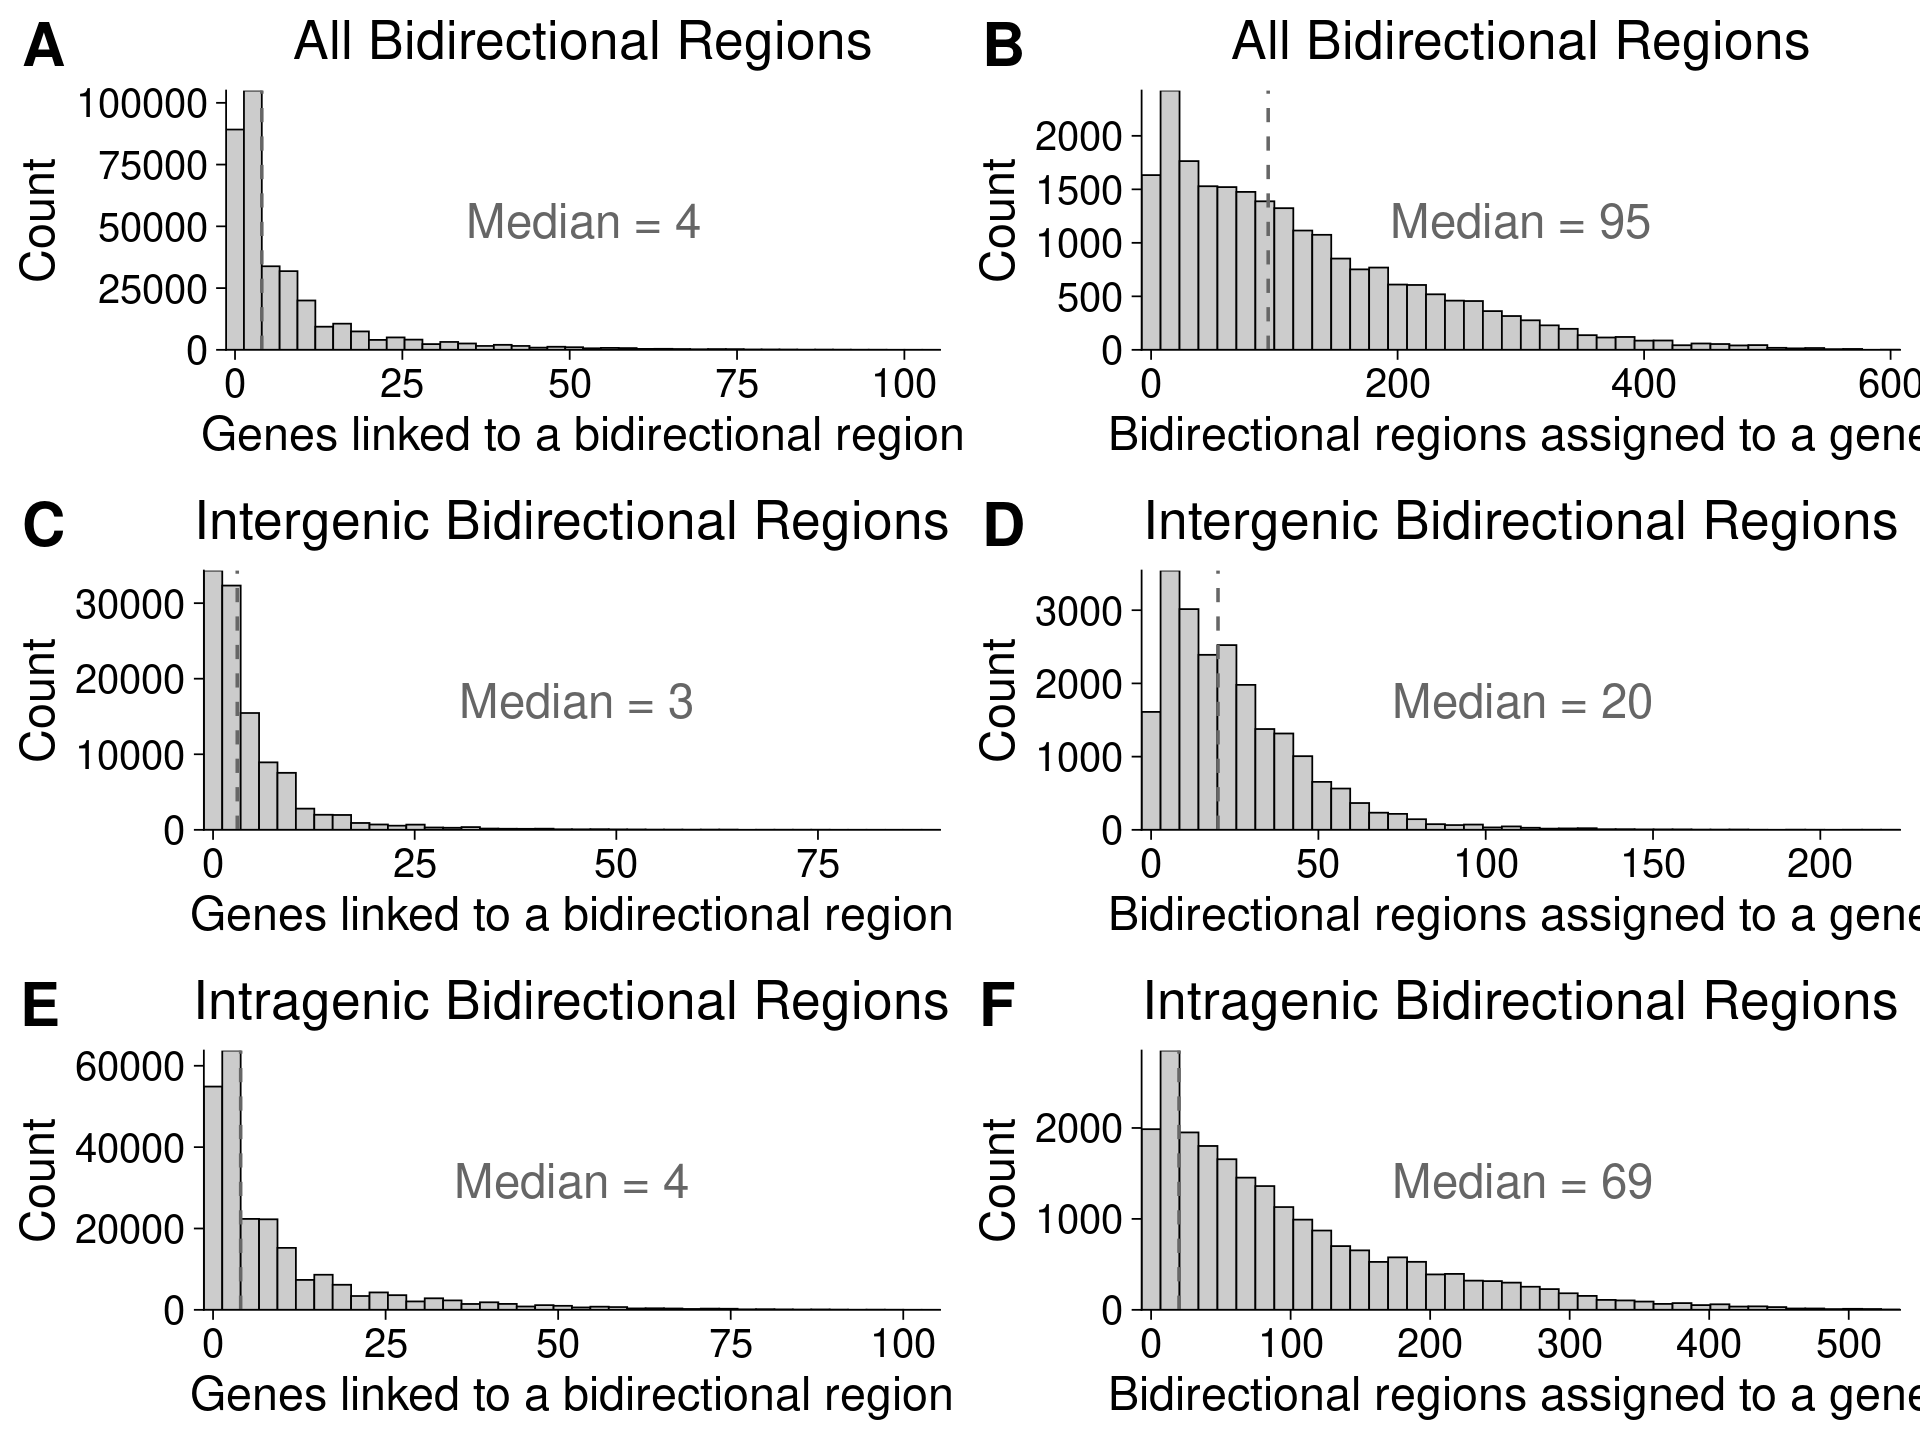

In [67]:
options(repr.plot.width=16, repr.plot.height=12)

num_transcripts_assigned_plot <- cowplot::plot_grid(num_genes_per_bidir_plot2, 
                                                   num_bidirs_per_gene_plot2,
                                                   num_genes_per_bidir_inter_plot2, 
                                                   num_bidirs_per_gene_inter_plot2,
                                                   num_genes_per_bidir_intra_plot2, 
                                                   num_bidirs_per_gene_intra_plot2,
                                                   nrow=3,
                                                   labels = c('A', 'B','C','D','E','F'),
                                                   label_size = 36)
num_transcripts_assigned_plot

In [68]:
ggsave(num_transcripts_assigned_plot, width = 16, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_transcripts_assigned_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_transcripts_assigned_plot, width = 16, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_transcripts_assigned_plot_reviews.png',
      bg = "transparent")

## Number of tissues a pair is found

In [69]:
no_tissues_for_pair <- as.data.frame(table(corr_sig_loop_DT$pair_id))
nrow(no_tissues_for_pair)
head(no_tissues_for_pair, 3)

[1] 2705601

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1


In [70]:
no_tissues_for_pair$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), ':'),
                                                      `[`, 1))
no_tissues_for_pair$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair$Var1), '~'),
                                                      `[`, 2))
head(no_tissues_for_pair, 3)

,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1,A1BG-AS1,chr19:57363902-57364246
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2,A1BG-AS1,chr19:57429748-57430210
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1,A1BG-AS1,chr19:57442340-57442746


In [71]:
no_tissues_for_pair_summary <- merge(no_tissues_for_pair, 
                                          gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                          by='gene_id')
nrow(no_tissues_for_pair_summary)
head(no_tissues_for_pair_summary, 3)

[1] 2705601

,gene_id,Var1,Freq,bidir_id,chrom,start,stop,gene_transcript,score,strand,⋯,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type
,<chr>,<fct>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
1,A1BG,A1BG:NM_130786.4~chr19:57407499-57408135,1,chr19:57407499-57408135,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,918.3444,1.222829,0.9290437,0.9229986,12.26659,0,749,99.73369,genes,genes
2,A1BG,A1BG:NM_130786.4~chr19:57447946-57448224,1,chr19:57447946-57448224,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,918.3444,1.222829,0.9290437,0.9229986,12.26659,0,749,99.73369,genes,genes
3,A1BG,A1BG:NM_130786.4~chr19:57450214-57451156,1,chr19:57450214-57451156,chr19,58345182,58352742,A1BG:NM_130786.4,.,-,⋯,918.3444,1.222829,0.9290437,0.9229986,12.26659,0,749,99.73369,genes,genes


In [72]:
no_tissues_for_pair_counts <- as.data.frame(table(no_tissues_for_pair$Freq))
no_tissues_for_pair_counts$Percent <- 100*(no_tissues_for_pair_counts$Freq/sum(no_tissues_for_pair_counts$Freq))
no_tissues_for_pair_counts

Var1,Freq,Percent
<fct>,<int>,<dbl>
1,1777415,6.569391e+01
2,508682,1.880107e+01
3,233016,8.612356e+00
4,113349,4.189420e+00
5,48918,1.808027e+00
6,17665,6.529048e-01
7,5116,1.890892e-01
8,1209,4.468508e-02
9,203,7.502954e-03


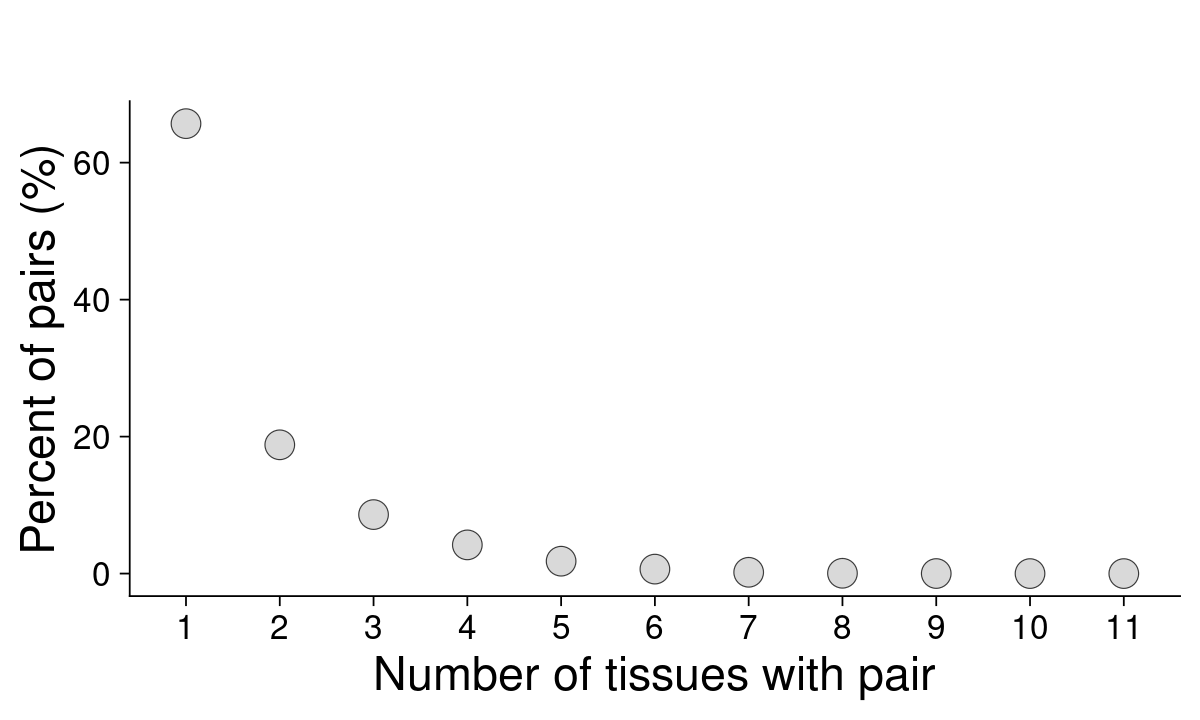

In [73]:
options(repr.plot.width=10, repr.plot.height=6)
num_tissues_pairs_plot <- ggplot(no_tissues_for_pair_counts, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=8, 
           fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_plot

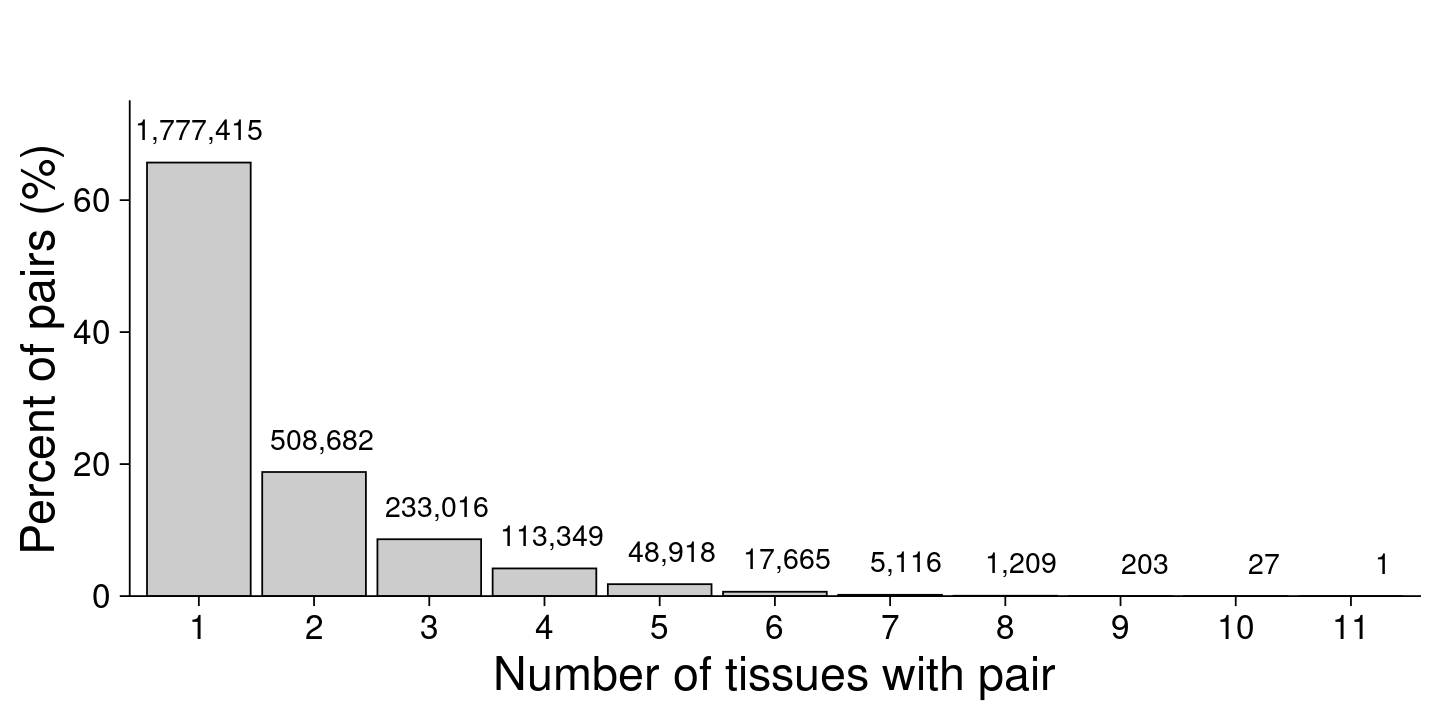

In [74]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot <- ggplot(no_tissues_for_pair_counts, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=seq(1, nrow(no_tissues_for_pair_counts), 1),
         y=no_tissues_for_pair_counts$Percent+5, 
         label= format(no_tissues_for_pair_counts$Freq, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,75)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot

In [75]:
no_tissues_for_pair_counts_greater5 <- no_tissues_for_pair_counts[no_tissues_for_pair_counts$Var1 %in%
                                                                            c(5,6,7,8,9,10,11),]
no_tissues_for_pair_counts_greater5
sum(no_tissues_for_pair_counts_greater5$Freq)

,Var1,Freq,Percent
,<fct>,<int>,<dbl>
5,5,48918,1.808027e+00
6,6,17665,6.529048e-01
7,7,5116,1.890892e-01
8,8,1209,4.468508e-02
9,9,203,7.502954e-03
10,10,27,9.979298e-04
11,11,1,3.696036e-05


[1] 73139

In [76]:
no_tissues_for_pair_counts_new_set <- rbind(no_tissues_for_pair_counts[!no_tissues_for_pair_counts$Var1 %in%
                                                                            c(5,6,7,8,9,10,11),],
                                                 data.frame(Var1=c(">=5"),
                                                            Freq=sum(no_tissues_for_pair_counts_greater5$Freq),
                                                            Percent=sum(no_tissues_for_pair_counts_greater5$Percent)))
no_tissues_for_pair_counts_new_set

Var1,Freq,Percent
<fct>,<int>,<dbl>
1,1777415,65.693907
2,508682,18.801072
3,233016,8.612356
4,113349,4.189420
>=5,73139,2.703244


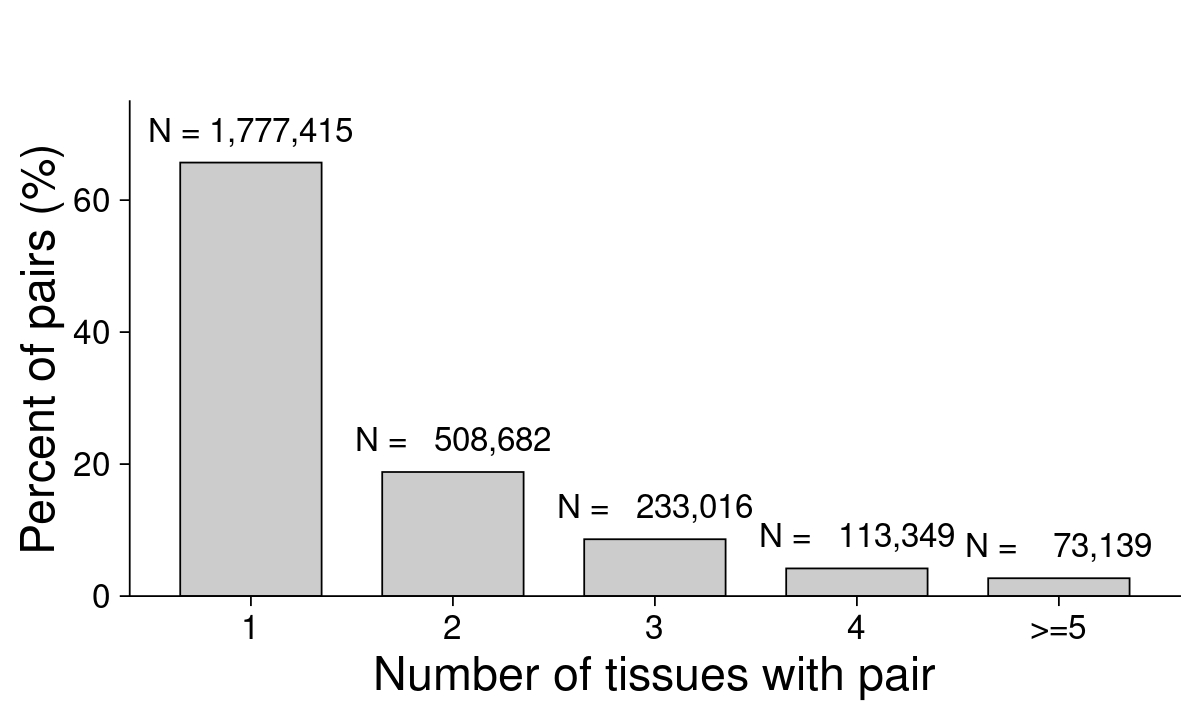

In [77]:
options(repr.plot.width=10, repr.plot.height=6)
num_tissues_pairs_bar_plot2 <- ggplot(no_tissues_for_pair_counts_new_set, 
                       aes(x=Var1, #reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         width=0.7,
         fill='gray80',
          color='black') +
ggtitle(" ") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=c(1,2,3,4,5),
         y=no_tissues_for_pair_counts_new_set$Percent+5, 
         label= paste("N =", format(no_tissues_for_pair_counts_new_set$Freq, 
       scientific = FALSE, big.mark = ',')), size = 7) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,75)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot2

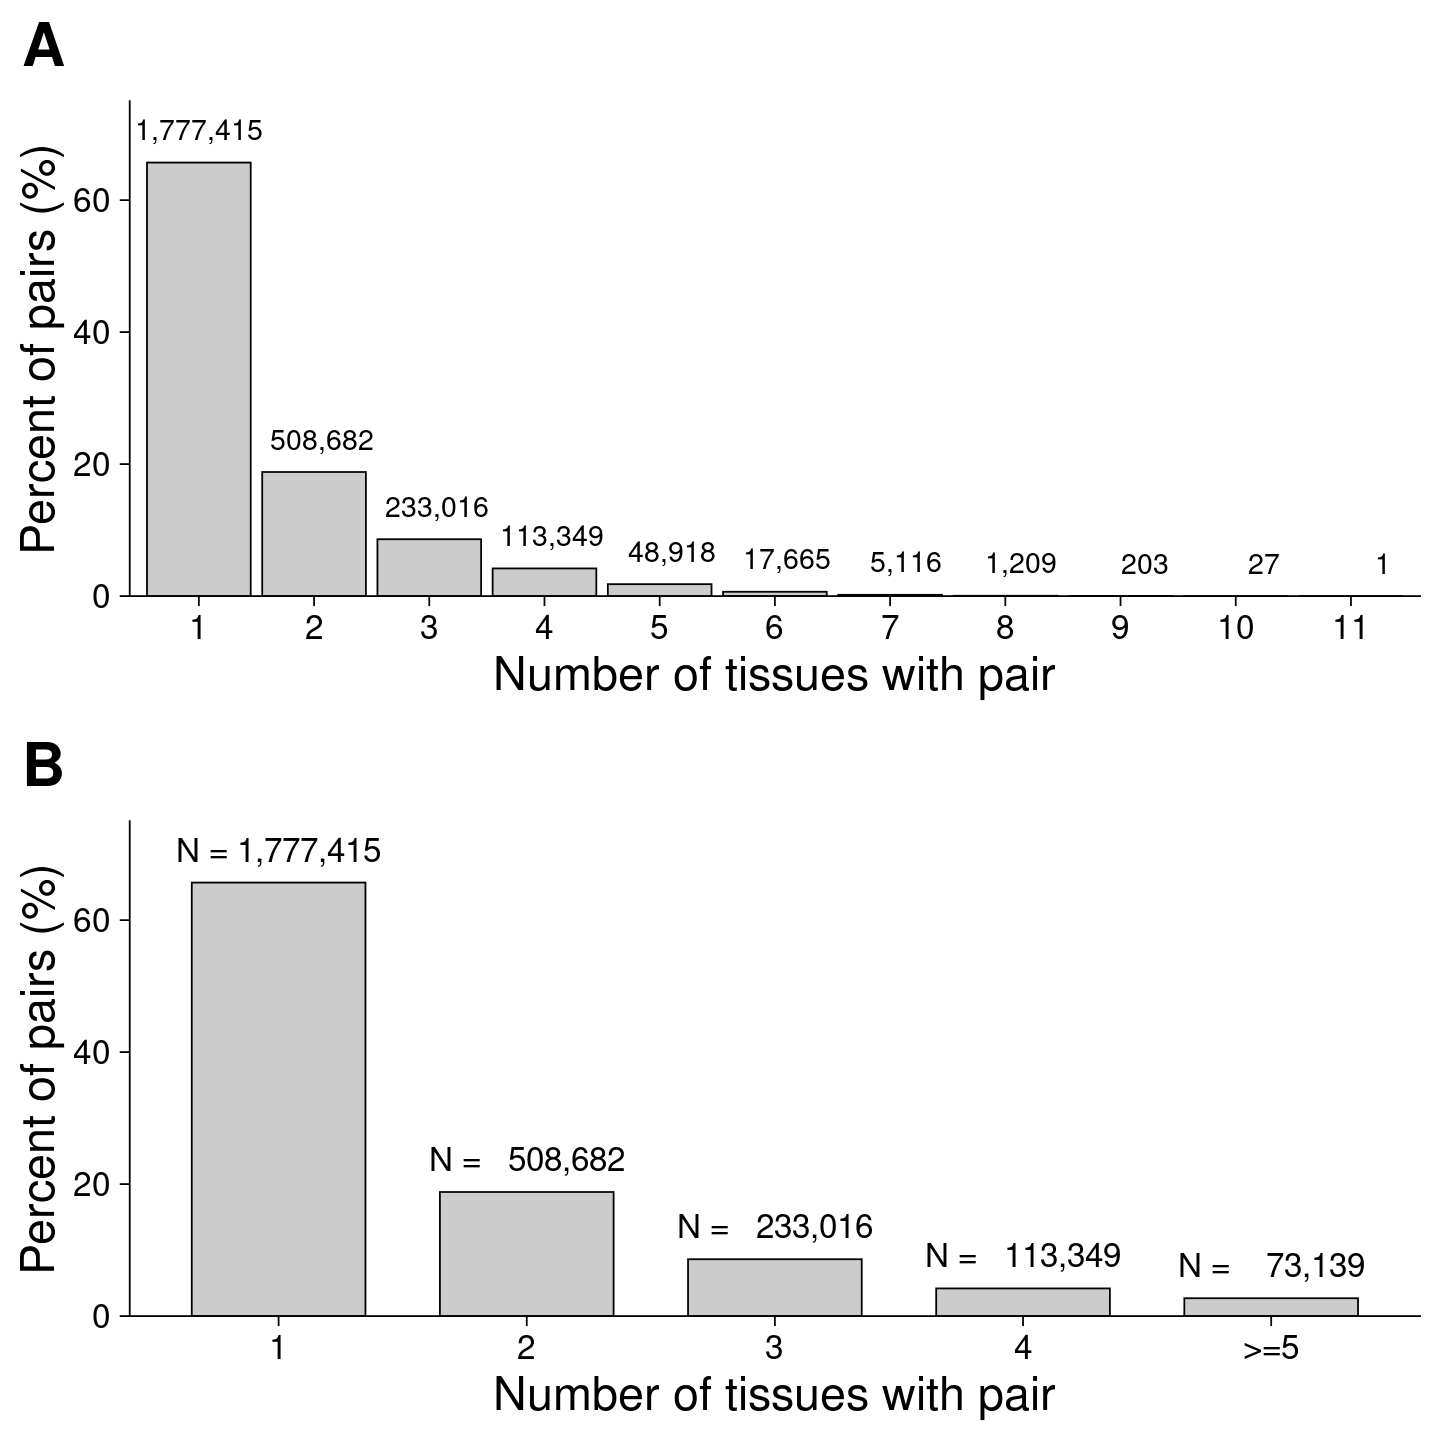

In [78]:
options(repr.plot.width=12, repr.plot.height=12)

cowplot::plot_grid(num_tissues_pairs_bar_plot,
                   num_tissues_pairs_bar_plot2,
                   nrow=2,
                   labels = c('A', 'B'),
                   label_size = 36)

### Intergenic

In [79]:
no_tissues_for_pair_inter <- as.data.frame(table(corr_sig_strict_DT_inter$pair_id))
no_tissues_for_pair_inter$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_inter$Var1), ':'),
                                                      `[`, 1))
no_tissues_for_pair_inter$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_inter$Var1), '~'),
                                                      `[`, 2))

nrow(no_tissues_for_pair_inter)
head(no_tissues_for_pair_inter, 3)

[1] 530312

,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57742463-57742981,1,A1BG-AS1,chr19:57742463-57742981
2,A1BG-AS1:NR_015380.2~chr19:58168215-58168613,1,A1BG-AS1,chr19:58168215-58168613
3,A1BG-AS1:NR_015380.2~chr19:58175890-58176170,1,A1BG-AS1,chr19:58175890-58176170


In [80]:
no_tissues_for_pair_counts_inter <- as.data.frame(table(no_tissues_for_pair_inter$Freq))
no_tissues_for_pair_counts_inter$Percent <- 100*(no_tissues_for_pair_counts_inter$Freq/nrow(corr_sig_DT_unique))
no_tissues_for_pair_counts_inter$bidirectional_location <- "Intergenic"
no_tissues_for_pair_counts_inter

Var1,Freq,Percent,bidirectional_location
<fct>,<int>,<dbl>,<chr>
1,424457,1.568809e+01,Intergenic
2,77880,2.878473e+00,Intergenic
3,20443,7.555807e-01,Intergenic
4,5751,2.125591e-01,Intergenic
5,1414,5.226196e-02,Intergenic
6,296,1.094027e-02,Intergenic
7,59,2.180662e-03,Intergenic
8,10,3.696036e-04,Intergenic
9,2,7.392073e-05,Intergenic


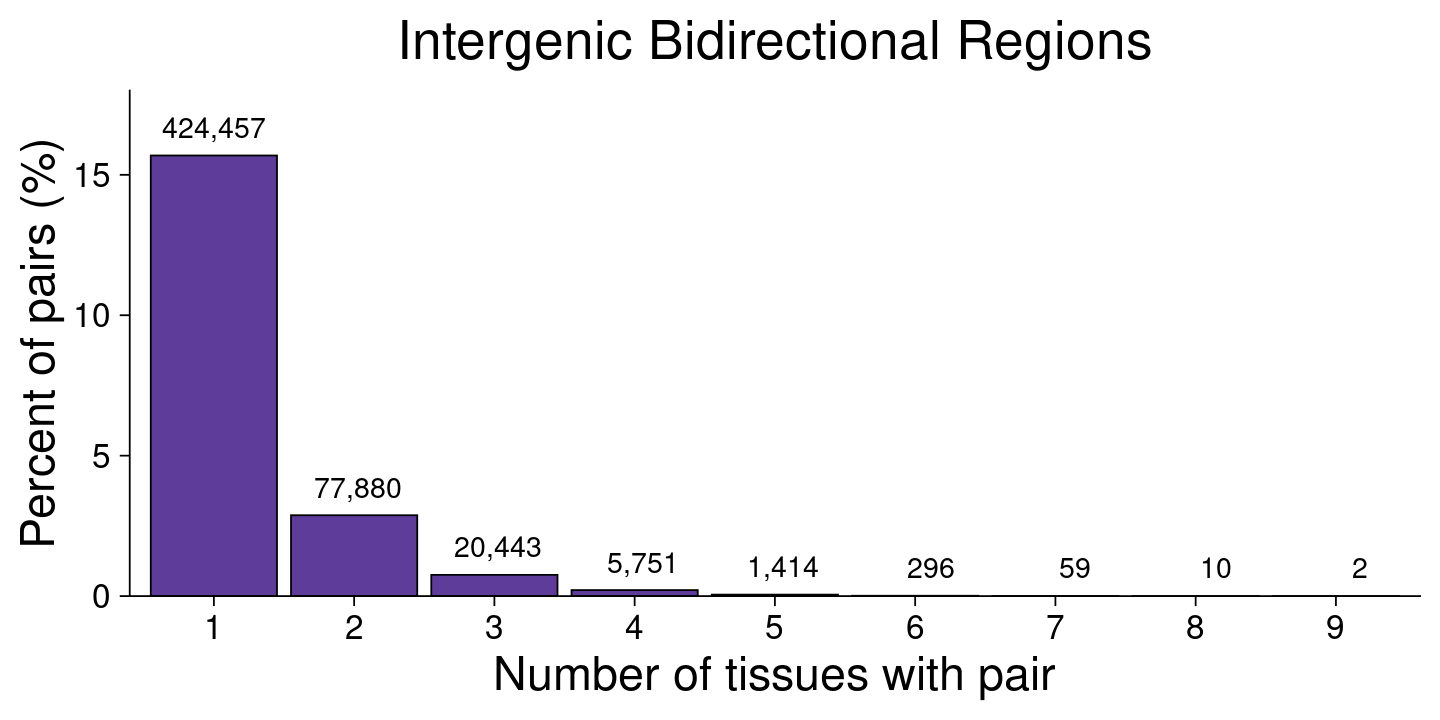

In [81]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot_inter <- ggplot(no_tissues_for_pair_counts_inter, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         fill='#5e3c99',
          color='black') + #"#5e3c99", "#e66101"
ggtitle("Intergenic Bidirectional Regions") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=seq(1, nrow(no_tissues_for_pair_counts_inter), 1),
         y=no_tissues_for_pair_counts_inter$Percent+1, 
         label= format(no_tissues_for_pair_counts_inter$Freq, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,18)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot_inter

### Intragenic

In [82]:
no_tissues_for_pair_intra <- as.data.frame(table(corr_sig_strict_DT_intra$pair_id))
no_tissues_for_pair_intra$gene_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_intra$Var1), ':'),
                                                      `[`, 1))
no_tissues_for_pair_intra$bidir_id <- as.character(lapply(strsplit(as.character(no_tissues_for_pair_intra$Var1), '~'),
                                                      `[`, 2))

nrow(no_tissues_for_pair_intra)
head(no_tissues_for_pair_intra, 3)

[1] 2175289

,Var1,Freq,gene_id,bidir_id
,<fct>,<int>,<chr>,<chr>
1,A1BG-AS1:NR_015380.2~chr19:57363902-57364246,1,A1BG-AS1,chr19:57363902-57364246
2,A1BG-AS1:NR_015380.2~chr19:57429748-57430210,2,A1BG-AS1,chr19:57429748-57430210
3,A1BG-AS1:NR_015380.2~chr19:57442340-57442746,1,A1BG-AS1,chr19:57442340-57442746


In [83]:
no_tissues_for_pair_counts_intra <- as.data.frame(table(no_tissues_for_pair_intra$Freq))
no_tissues_for_pair_counts_intra$Percent <- 100*(no_tissues_for_pair_counts_intra$Freq/nrow(corr_sig_DT_unique))
no_tissues_for_pair_counts_intra$bidirectional_location <- "Intragenic"
no_tissues_for_pair_counts_intra

Var1,Freq,Percent,bidirectional_location
<fct>,<int>,<dbl>,<chr>
1,1352958,5.000582e+01,Intragenic
2,430802,1.592260e+01,Intragenic
3,212573,7.856776e+00,Intragenic
4,107598,3.976861e+00,Intragenic
5,47504,1.755765e+00,Intragenic
6,17369,6.419646e-01,Intragenic
7,5057,1.869086e-01,Intragenic
8,1199,4.431548e-02,Intragenic
9,201,7.429033e-03,Intragenic


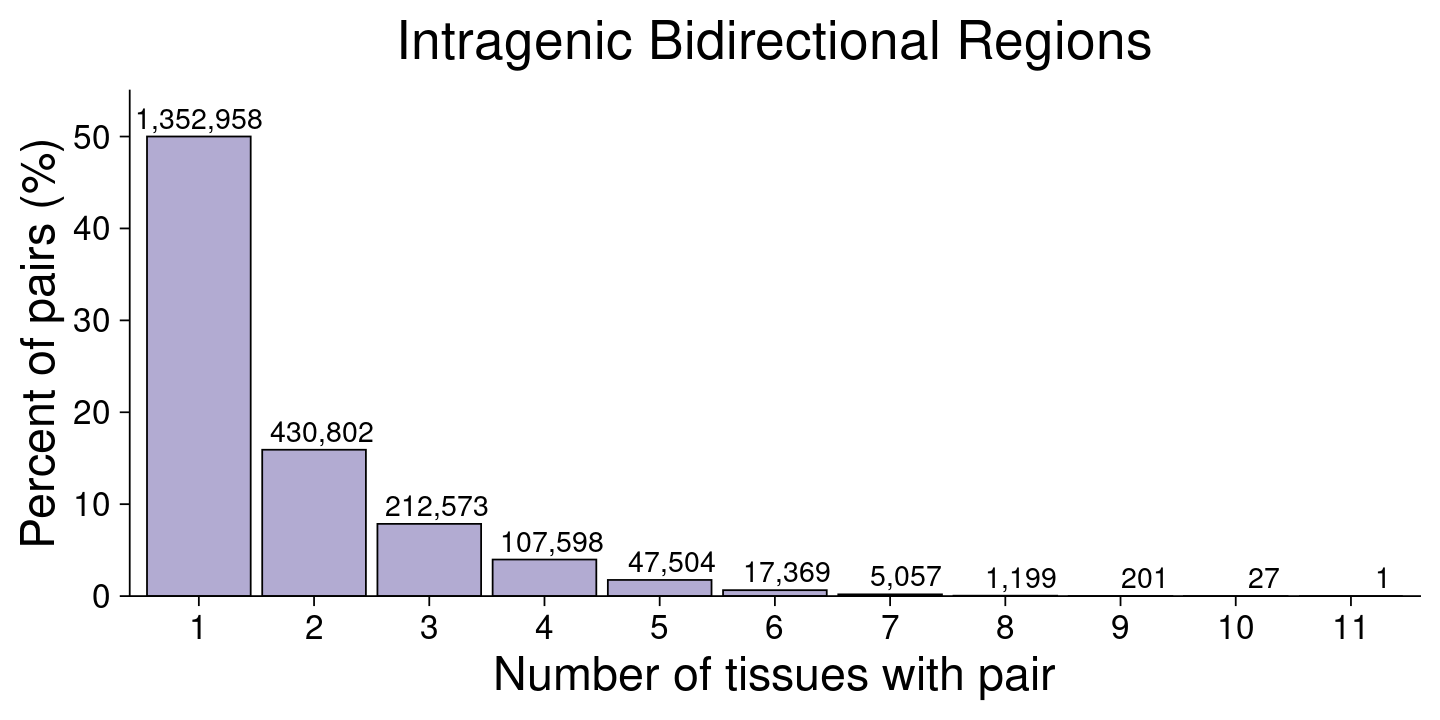

In [84]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot_intra <- ggplot(no_tissues_for_pair_counts_intra, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent)) + 
geom_bar(stat='identity',
         fill='#b2abd2',
          color='black') + #"#5e3c99", "#e66101"
ggtitle("Intragenic Bidirectional Regions") +
xlab("Number of tissues with pair") + 
ylab("Percent of pairs (%)") +
theme_cowplot(24) +
annotate("text", x=seq(1, nrow(no_tissues_for_pair_counts_intra), 1),
         y=no_tissues_for_pair_counts_intra$Percent+2, 
         label= format(no_tissues_for_pair_counts_intra$Freq, 
       scientific = FALSE, big.mark = ','), size = 6) + 
scale_y_continuous(expand = c(0, 0), limits=c(0,55)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 28), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_pairs_bar_plot_intra

In [85]:
no_tissues_for_pair_counts_inter_intra <- rbind(no_tissues_for_pair_counts_intra,
                                               no_tissues_for_pair_counts_inter)
no_tissues_for_pair_counts_inter_intra$Percent <- 100*(no_tissues_for_pair_counts_inter_intra$Freq/sum(no_tissues_for_pair_counts_inter_intra$Freq))
sum(no_tissues_for_pair_counts_inter_intra$Percent)
nrow(no_tissues_for_pair_counts_inter_intra)
head(no_tissues_for_pair_counts_inter_intra)


[1] 100

[1] 20

,Var1,Freq,Percent,bidirectional_location
,<fct>,<int>,<dbl>,<chr>
1,1,1352958,50.0058213,Intragenic
2,2,430802,15.9225991,Intragenic
3,3,212573,7.8567756,Intragenic
4,4,107598,3.9768613,Intragenic
5,5,47504,1.7557652,Intragenic
6,6,17369,0.6419646,Intragenic


In [86]:
sum(no_tissues_for_pair_counts_inter_intra$Freq)

[1] 2705601

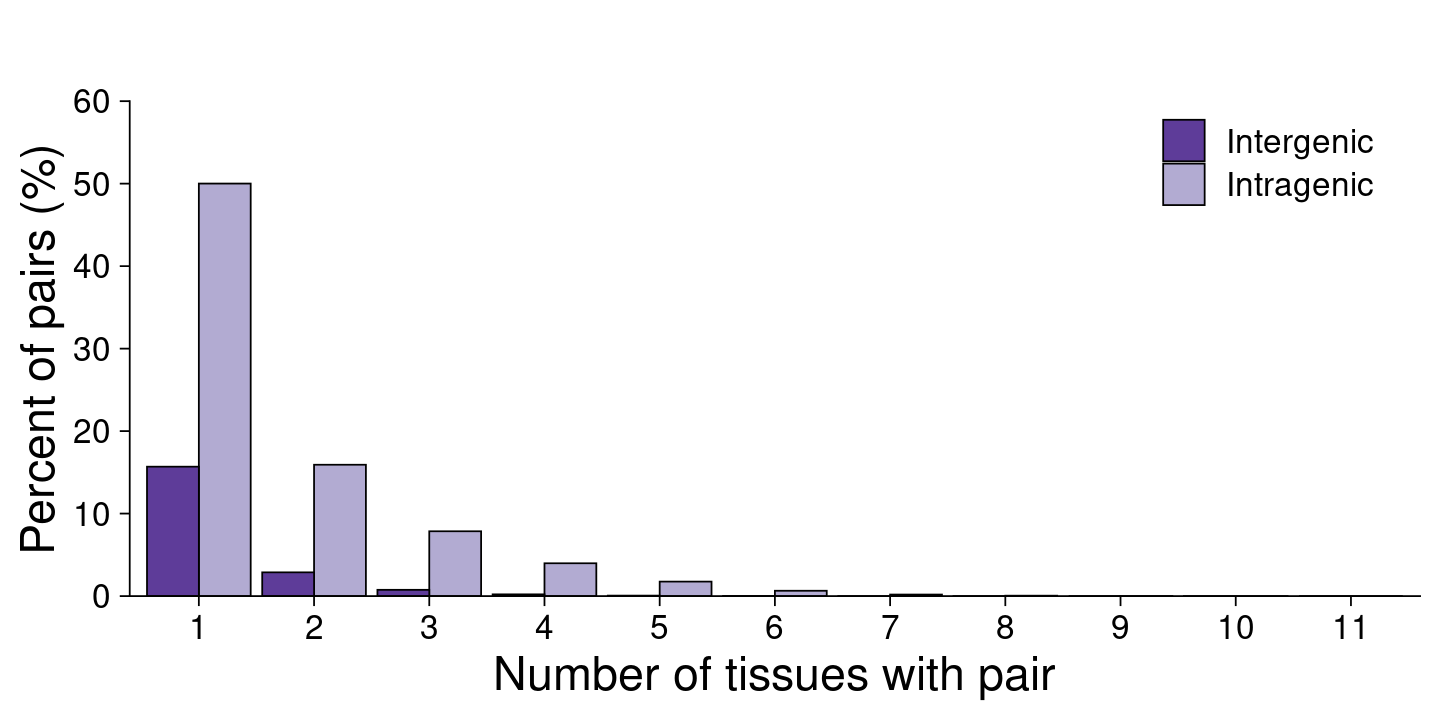

In [87]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_pairs_bar_plot_inter_intra <- ggplot(no_tissues_for_pair_counts_inter_intra, 
                       aes(x=reorder(Var1, -Freq), 
                           y=Percent, fill=bidirectional_location)) + 
geom_bar(stat='identity',
          color='black', 
        position="dodge") + 
labs(title=" ",
    x="Number of tissues with pair",
    y="Percent of pairs (%)",
    fill=" ") +
scale_fill_manual(values=c("#5e3c99", "#b2abd2")) +
theme_cowplot(24) +
scale_y_continuous(expand = c(0, 0), limits = c(0, 60)) +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(legend.position = "inside", 
      legend.position.inside = c(0.8, 0.95),
      legend.text=element_text(size=20))

num_tissues_pairs_bar_plot_inter_intra

In [88]:
ggsave(num_tissues_pairs_bar_plot_inter_intra, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_tissues_pairs_bar_plot_inter_intra_reviews.pdf',
      bg = "transparent")

ggsave(num_tissues_pairs_bar_plot_inter_intra, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_tissues_pairs_bar_plot_inter_intra_reviews.png',
      bg = "transparent")

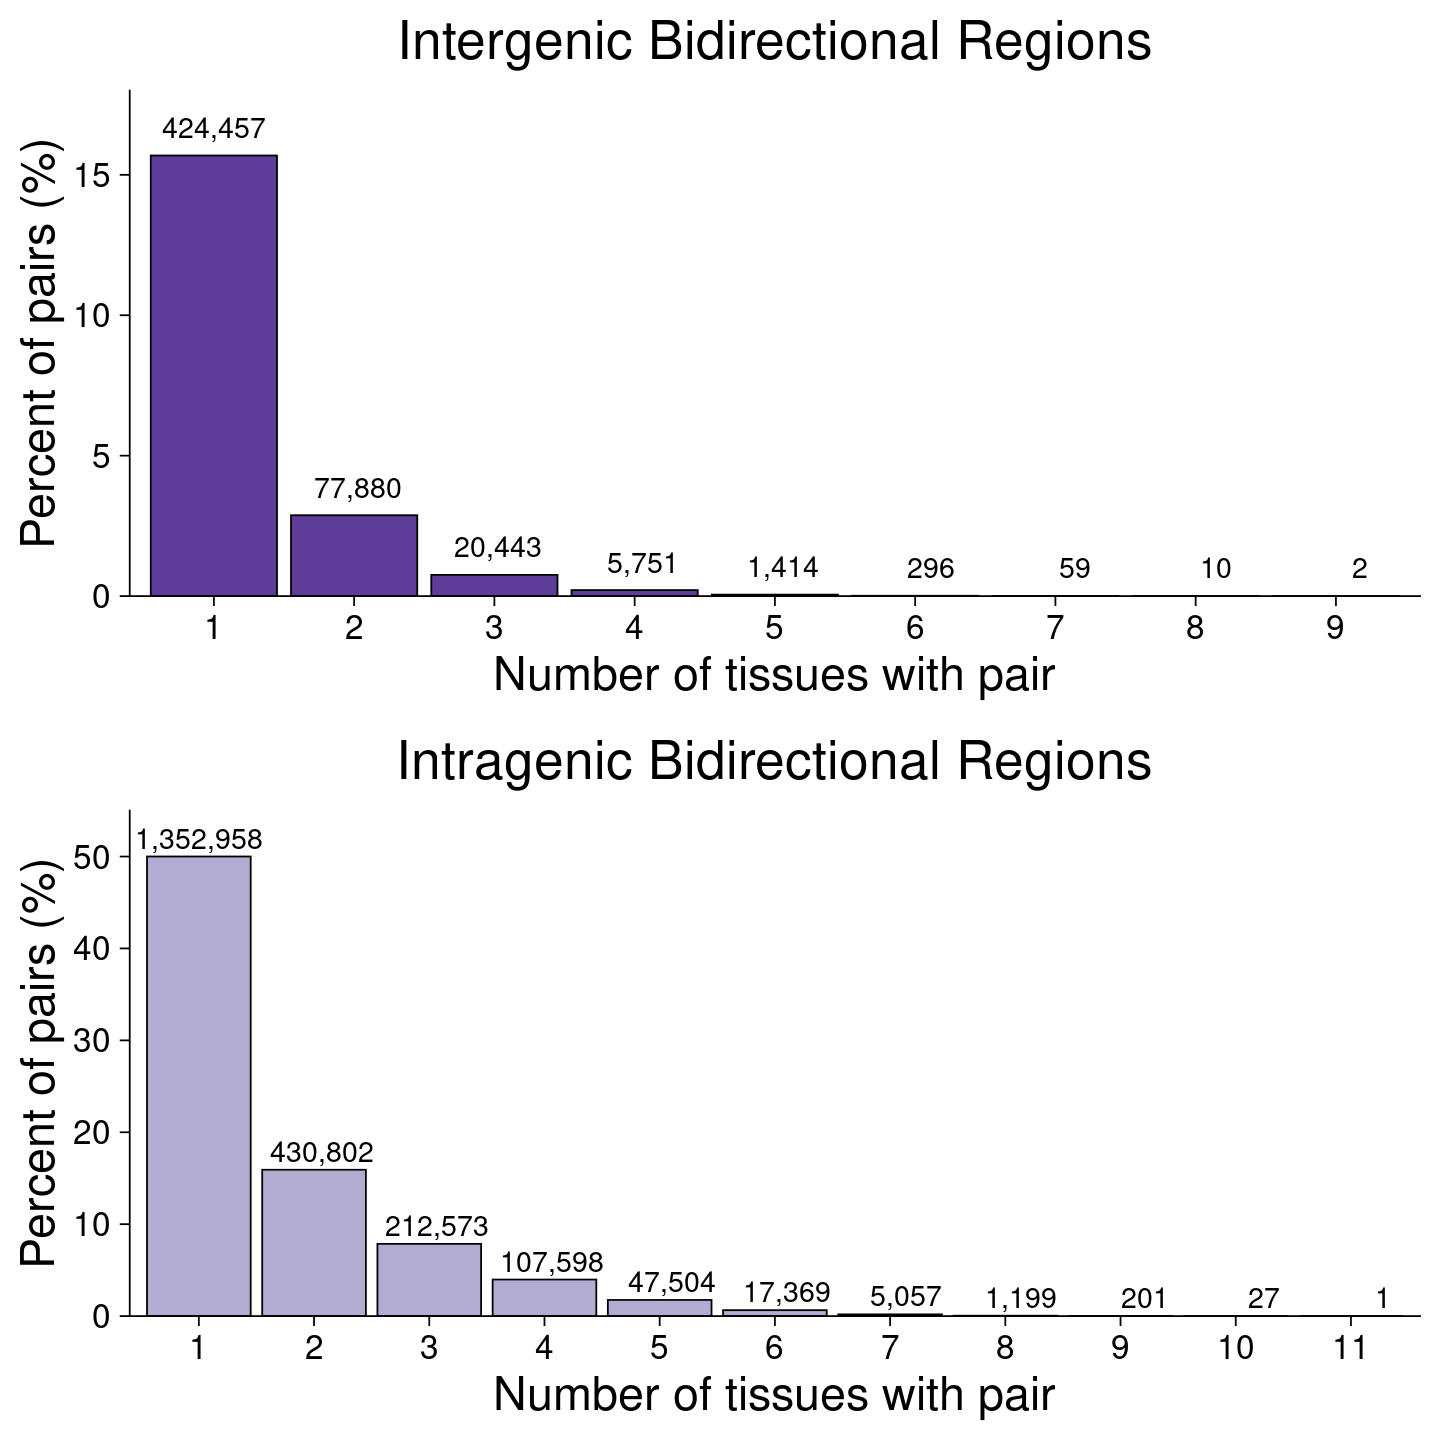

In [89]:
options(repr.plot.width=12, repr.plot.height=12)

cowplot::plot_grid(num_tissues_pairs_bar_plot_inter,
                   num_tissues_pairs_bar_plot_intra,
                   nrow=2)

## Plot with pair summary

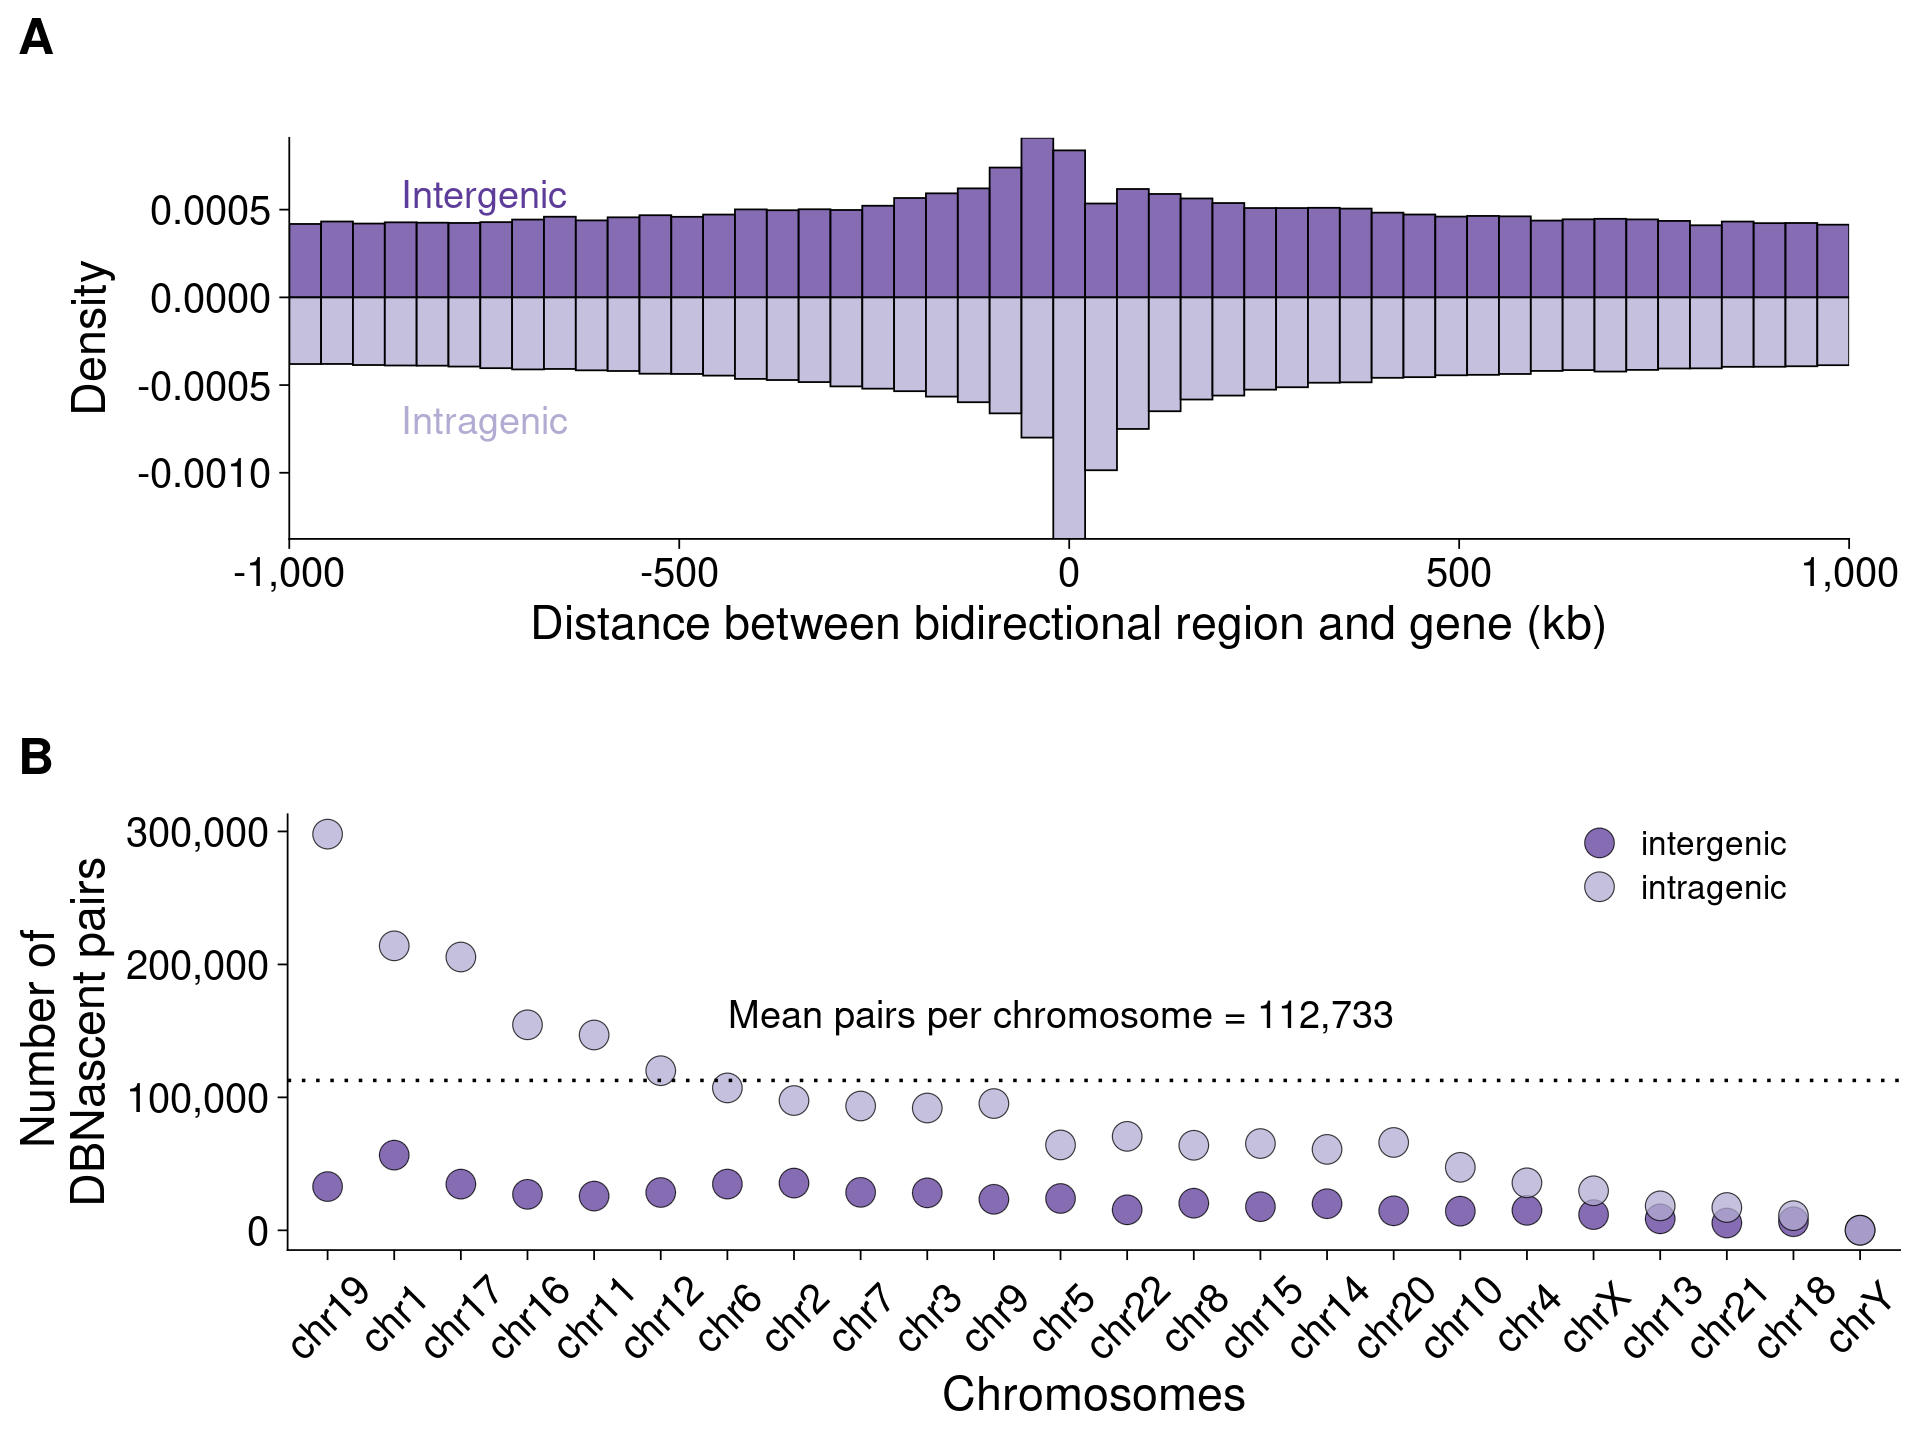

In [90]:
options(repr.plot.width=16, repr.plot.height=12)

pair_location_plot <- cowplot::plot_grid(gene_bidir_dist_hist_mirror,
                                         num_pairs_plot,
                                                   nrow=2,
                                                   labels = c('A', 'B'),
                                                   label_size = 30)
pair_location_plot

In [91]:
ggsave(pair_location_plot, width = 16, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/loop_pair_location_plot_reviews.pdf',
      bg = "transparent")

ggsave(pair_location_plot, width = 16, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/loop_pair_location_plot_reviews.png',
      bg = "transparent")

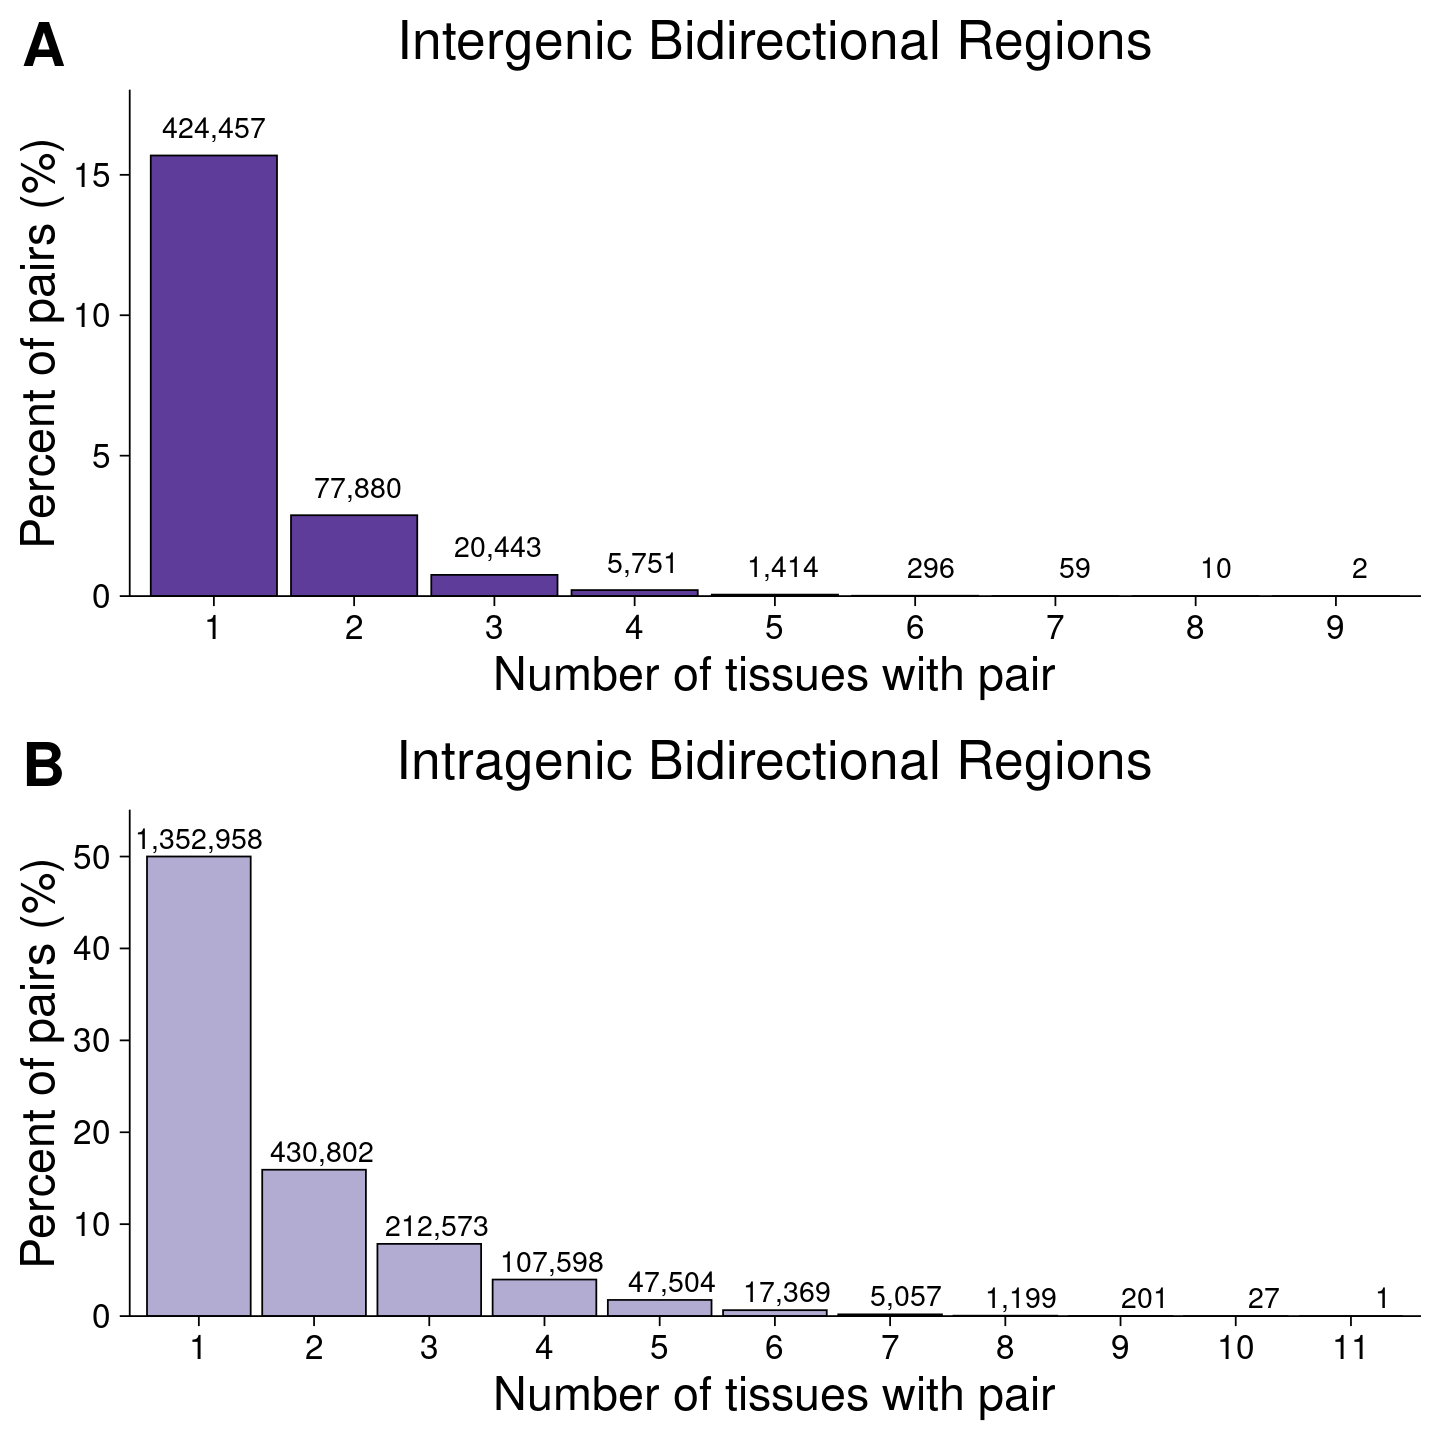

In [92]:
#options(repr.plot.width=12, repr.plot.height=10)
options(repr.plot.width=12, repr.plot.height=12)

pair_tissue_assignment_plot <- cowplot::plot_grid(num_tissues_pairs_bar_plot_inter, 
                                         num_tissues_pairs_bar_plot_intra,
                                                   nrow=2,
                                                   labels = c('A', 'B'),
                                                   label_size = 36)
pair_tissue_assignment_plot

In [93]:
ggsave(pair_tissue_assignment_plot, width = 12, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/loop_pair_tissue_assignment_plot_reviews.pdf',
      bg = "transparent")

ggsave(pair_tissue_assignment_plot, width = 12, height = 12,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/loop_pair_tissue_assignment_plot_reviews.png',
      bg = "transparent")

## Combine the assignment summaries

### Bidirectionals assigned to a gene

In [94]:
## Assigned bidir with loop == corr_sig_DT_unique

###################################
#1: All correlations before filters
#get unique pairs for 
corr_sig_all_DT_unique <- unique(corr_sig_DT[,c('transcript1_chrom', 
                                            'pair_id',
                                            'transcript_1', 
                                            'transcript_2',
                                            'bidirectional_location')])

##count the number of pairs per chromosome
all_num_bidirs_per_gene <- as.data.frame(table(corr_sig_all_DT_unique$transcript_1))


###################################
#2: strict correlations
#get unique pairs for 
corr_sig_strict_DT_unique <- unique(corr_sig_strict_DT[,c('transcript1_chrom', 
                                            'pair_id',
                                            'transcript_1', 
                                            'transcript_2',
                                            'bidirectional_location')])

##count the number of pairs per chromosome
strict_num_bidirs_per_gene <- as.data.frame(table(corr_sig_strict_DT_unique$transcript_1))


###################################
#3: strict correlations with loop and in top 6 tissues
#get unique pairs for 
corr_sig_strict_6tissues_DT_unique <- unique(corr_sig_loop_DT[tissue %in% c("blood",
                                                                     "breast",
                                                                     "kidney",
                                                                     "uterus",
                                                                      "intestine",
                                                                     "prostate"),
                                                      ][,c('transcript1_chrom', 
                                                            'pair_id',
                                                            'transcript_1', 
                                                            'transcript_2',
                                                            'bidirectional_location')])

##count the number of pairs per chromosome
strict_top6_num_bidirs_per_gene <- as.data.frame(table(corr_sig_strict_6tissues_DT_unique$transcript_1))



In [95]:
##Add filter type column
#All pairs with loose filter
all_num_bidirs_per_gene$Filter <- "FDR < 0.01"
head(all_num_bidirs_per_gene, 3)

#Pairs with strict filter
strict_num_bidirs_per_gene$Filter <- "FDR < 0.001"
head(strict_num_bidirs_per_gene, 3)

#Assigned with strict filter AND loop 
#already calculated earlier
num_bidirs_per_gene$Filter <- "FDR < 0.001 \n + \n PolII ChIA-PET"
head(num_bidirs_per_gene, 3)

#Filter the top 6 tissues
strict_top6_num_bidirs_per_gene$Filter <- "FDR < 0.001 \n + \n PolII ChIA-PET \n + \n Only Top 6 Tissues"
head(strict_top6_num_bidirs_per_gene, 3)

,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,A1BG-AS1:NR_015380.2,393,FDR < 0.01
2,A1BG:NM_130786.4,325,FDR < 0.01
3,A1CF:NM_014576.4,103,FDR < 0.01


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,A1BG-AS1:NR_015380.2,306,FDR < 0.001
2,A1BG:NM_130786.4,226,FDR < 0.001
3,A1CF:NM_014576.4,66,FDR < 0.001


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,A1BG-AS1:NR_015380.2,198,FDR < 0.001 + PolII ChIA-PET
2,A1BG:NM_130786.4,150,FDR < 0.001 + PolII ChIA-PET
3,A1CF:NM_014576.4,21,FDR < 0.001 + PolII ChIA-PET


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,A1BG-AS1:NR_015380.2,191,FDR < 0.001 + PolII ChIA-PET + Only Top 6 Tissues
2,A1BG:NM_130786.4,143,FDR < 0.001 + PolII ChIA-PET + Only Top 6 Tissues
3,A1CF:NM_014576.4,21,FDR < 0.001 + PolII ChIA-PET + Only Top 6 Tissues


In [96]:
#Combine all the pair summaries
summary_num_bidirs_per_gene <- rbind(all_num_bidirs_per_gene,
                                    strict_num_bidirs_per_gene,
                                    num_bidirs_per_gene,
                                    strict_top6_num_bidirs_per_gene)

summary_num_bidirs_per_gene$Filter <- factor(summary_num_bidirs_per_gene$Filter, 
                                            levels=c("FDR < 0.01","FDR < 0.001",
                                                    "FDR < 0.001 \n + \n PolII ChIA-PET",
                                                    "FDR < 0.001 \n + \n PolII ChIA-PET \n + \n Only Top 6 Tissues"))
dim(summary_num_bidirs_per_gene)


[1] 99686     3

In [97]:
median_summary_num_bidirs_per_gene <- ddply(summary_num_bidirs_per_gene,
                .(Filter),
                summarise, med = median(Freq))

median_summary_num_bidirs_per_gene

Filter,med
<fct>,<dbl>
FDR < 0.01,220
FDR < 0.001,154
FDR < 0.001 + PolII ChIA-PET,95
FDR < 0.001 + PolII ChIA-PET + Only Top 6 Tissues,83


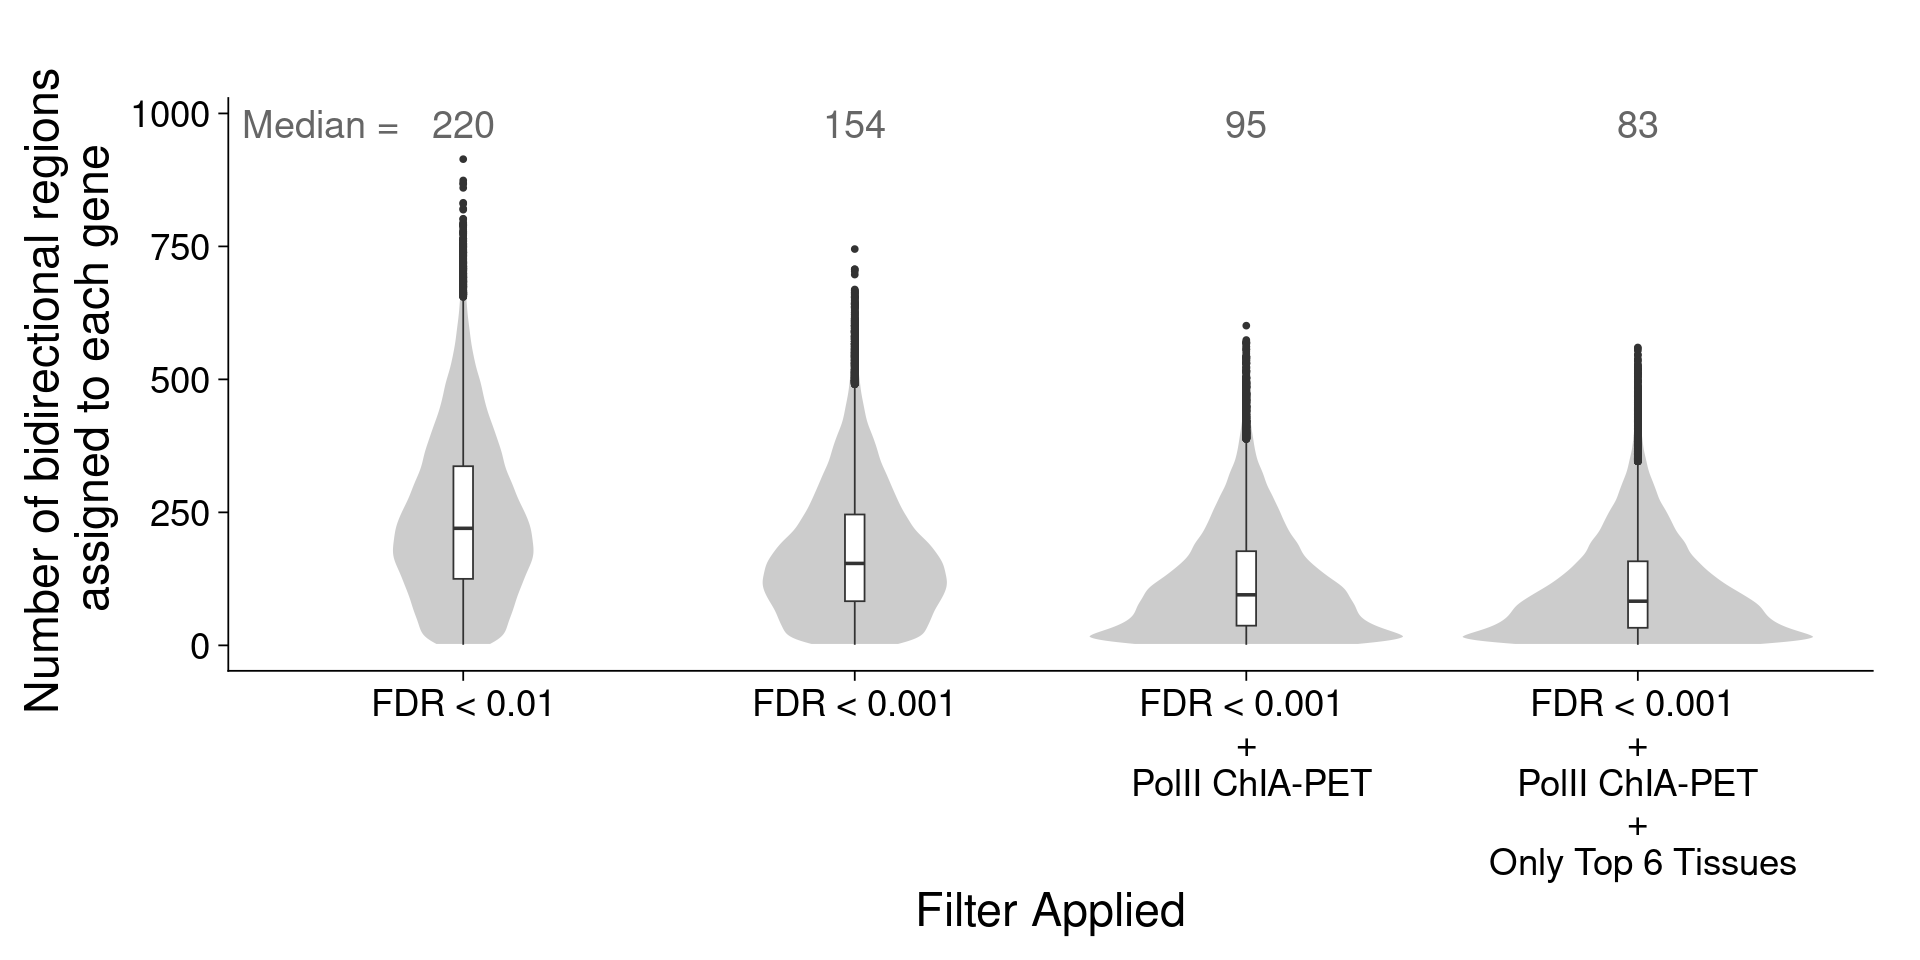

In [107]:
options(repr.plot.width=16, repr.plot.height=8)

summary_num_bidirs_per_gene_violinplot <- ggplot(summary_num_bidirs_per_gene, 
                                   aes(x=Filter,
                                       y=Freq)) + 
geom_violin(fill="gray80", color="gray100") +
geom_boxplot(width=0.05) +
geom_text(data = median_summary_num_bidirs_per_gene,
          aes(x = Filter, y =980, label = med), 
              size = 8, color="gray40") +
annotate(geom="text", 
         x=0.65, 
         y=980, 
         size=8,
         label="Median = ",
         color="gray40") +
labs(title = " ", 
       x = "Filter Applied",
       y = "Number of bidirectional regions \n assigned to each gene") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 22),
      axis.text.x = element_text(size = 22)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

summary_num_bidirs_per_gene_violinplot

### Genes linked to a bidirectional


In [99]:
## Assigned bidir with loop == corr_sig_DT_unique

###################################
#1: All correlations before filters
#get unique pairs for 
all_num_genes_per_bidir <- as.data.frame(table(corr_sig_all_DT_unique$transcript_2))


###################################
#2: strict correlations
#get unique pairs for 
strict_num_genes_per_bidir <- as.data.frame(table(corr_sig_strict_DT_unique$transcript_2))

###################################
#3: strict correlations with loop and in top 6 tissues
#get unique pairs for 
strict_top6_num_genes_per_bidir <- as.data.frame(table(corr_sig_strict_6tissues_DT_unique$transcript_2))



In [100]:
##Add filter type column
#All pairs with loose filter
all_num_genes_per_bidir$Filter <- "FDR < 0.01"
head(all_num_genes_per_bidir, 3)

#Pairs with strict filter
strict_num_genes_per_bidir$Filter <- "FDR < 0.001"
head(strict_num_genes_per_bidir, 3)

#Assigned with strict filter AND loop
num_genes_per_bidir$Filter <- "FDR < 0.001 \n + \n PolII ChIA-PET"
head(num_genes_per_bidir, 3)

#Only in top most tissues with samples
strict_top6_num_genes_per_bidir$Filter <- "FDR < 0.001 \n + \n PolII ChIA-PET \n + \n Only top 6 Tissues"
head(strict_top6_num_genes_per_bidir, 3)

,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,chr1:1000004-1000574,56,FDR < 0.01
2,chr1:100001920-100002206,4,FDR < 0.01
3,chr1:100005805-100006091,4,FDR < 0.01


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,chr1:1000004-1000574,47,FDR < 0.001
2,chr1:100005805-100006091,3,FDR < 0.001
3,chr1:100006945-100007111,16,FDR < 0.001


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,chr1:1000004-1000574,28,FDR < 0.001 + PolII ChIA-PET
2,chr1:100006945-100007111,4,FDR < 0.001 + PolII ChIA-PET
3,chr1:100009030-100009356,10,FDR < 0.001 + PolII ChIA-PET


,Var1,Freq,Filter
,<fct>,<int>,<chr>
1,chr1:1000004-1000574,26,FDR < 0.001 + PolII ChIA-PET + Only top 6 Tissues
2,chr1:100009030-100009356,4,FDR < 0.001 + PolII ChIA-PET + Only top 6 Tissues
3,chr1:100018762-100019014,5,FDR < 0.001 + PolII ChIA-PET + Only top 6 Tissues


In [101]:
#Combine all the pair summaries
summary_num_genes_per_bidir <- rbind(all_num_genes_per_bidir,
                                    strict_num_genes_per_bidir,
                                    num_genes_per_bidir,
                                    strict_top6_num_genes_per_bidir)

summary_num_genes_per_bidir$Filter <- factor(summary_num_genes_per_bidir$Filter, 
                                            levels=c("FDR < 0.01","FDR < 0.001",
                                                    "FDR < 0.001 \n + \n PolII ChIA-PET",
                                                    "FDR < 0.001 \n + \n PolII ChIA-PET \n + \n Only top 6 Tissues"))
dim(summary_num_genes_per_bidir)

[1] 1704932       3

In [102]:
median_summary_num_genes_per_bidir <- ddply(summary_num_genes_per_bidir,
                .(Filter),
                summarise, med = median(Freq))

median_summary_num_genes_per_bidir

Filter,med
<fct>,<int>
FDR < 0.01,6
FDR < 0.001,5
FDR < 0.001 + PolII ChIA-PET,4
FDR < 0.001 + PolII ChIA-PET + Only top 6 Tissues,3


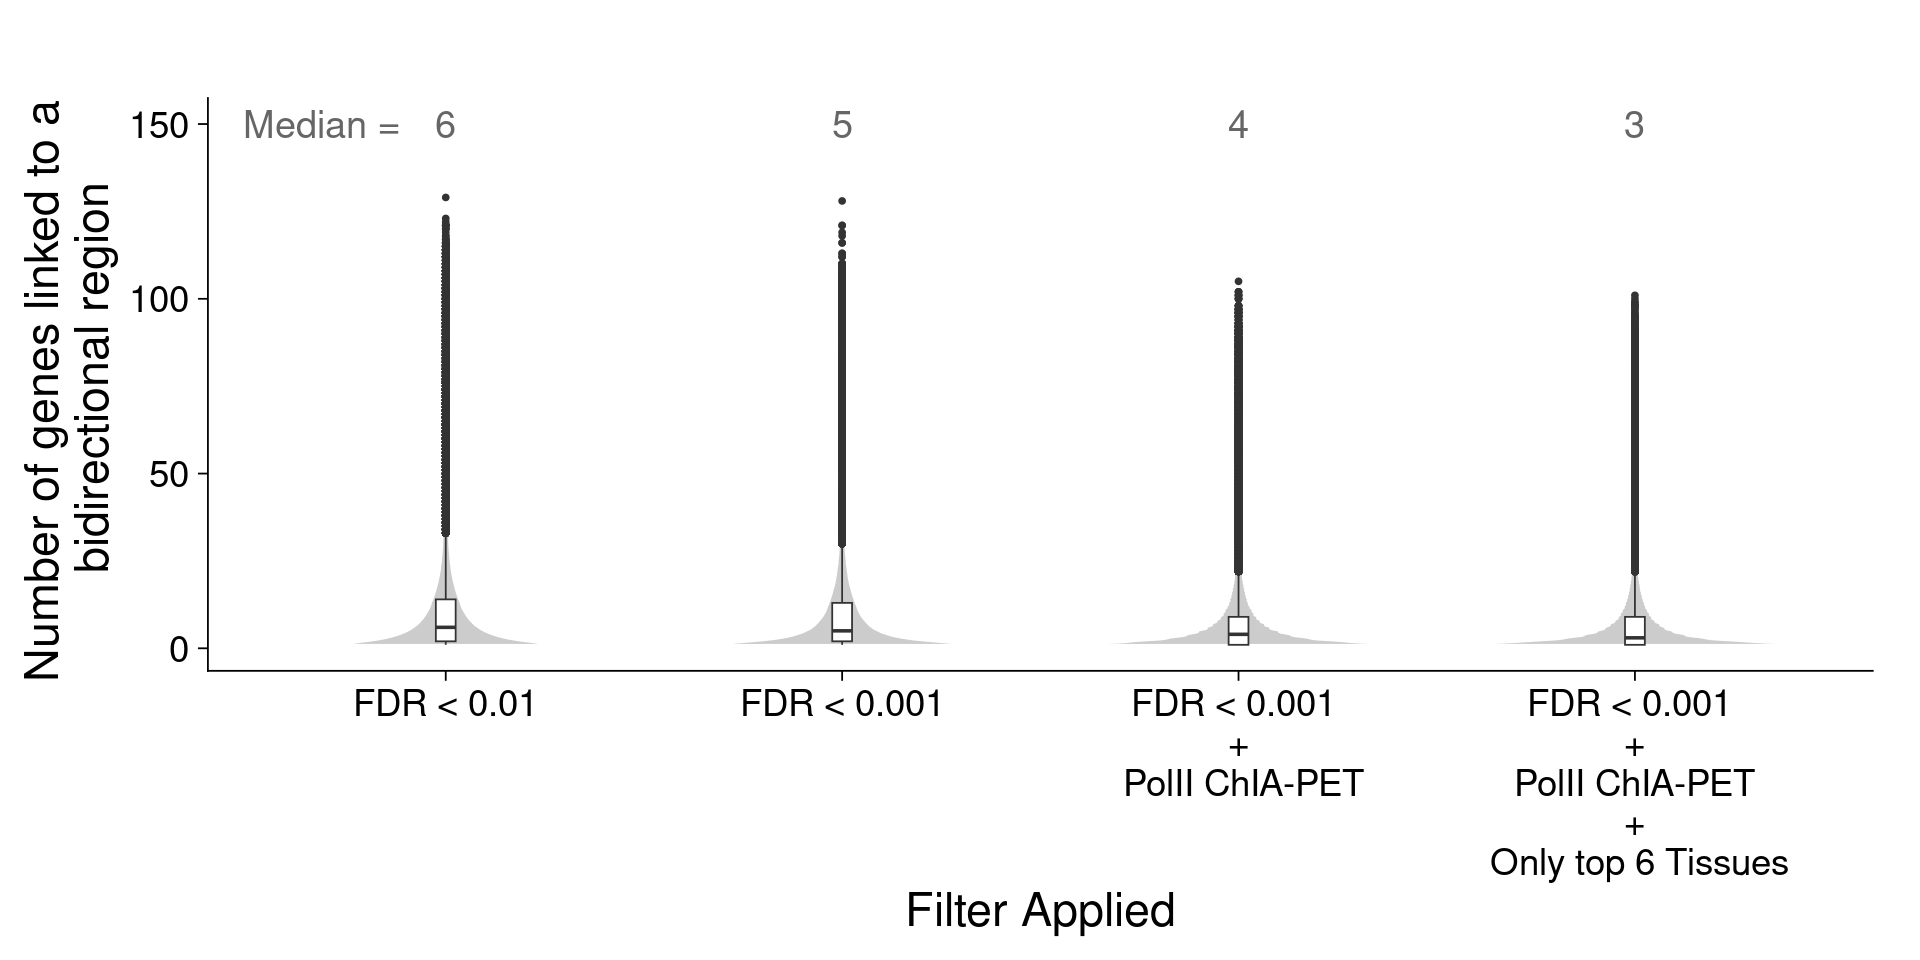

In [108]:
options(repr.plot.width=16, repr.plot.height=8)

summary_num_genes_per_bidir_violinplot <- ggplot(summary_num_genes_per_bidir, 
                                   aes(x=Filter,
                                       y=Freq)) + 
geom_violin(fill="gray80", color="gray100") +
geom_boxplot(width=0.05) +
geom_text(data = median_summary_num_genes_per_bidir,
          aes(x = Filter, y =150, label = med), 
              size = 8, color="gray40") +
annotate(geom="text", 
         x=0.7, 
         y=150, 
         size=8,
         label="Median = ",
         color="gray40") +
labs(title = " ", 
       x = "Filter Applied",
       y = "Number of genes linked to a \n bidirectional region") +
theme_cowplot(24) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28),
      axis.text.y = element_text(size = 22),
      axis.text.x = element_text(size = 22)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

summary_num_genes_per_bidir_violinplot

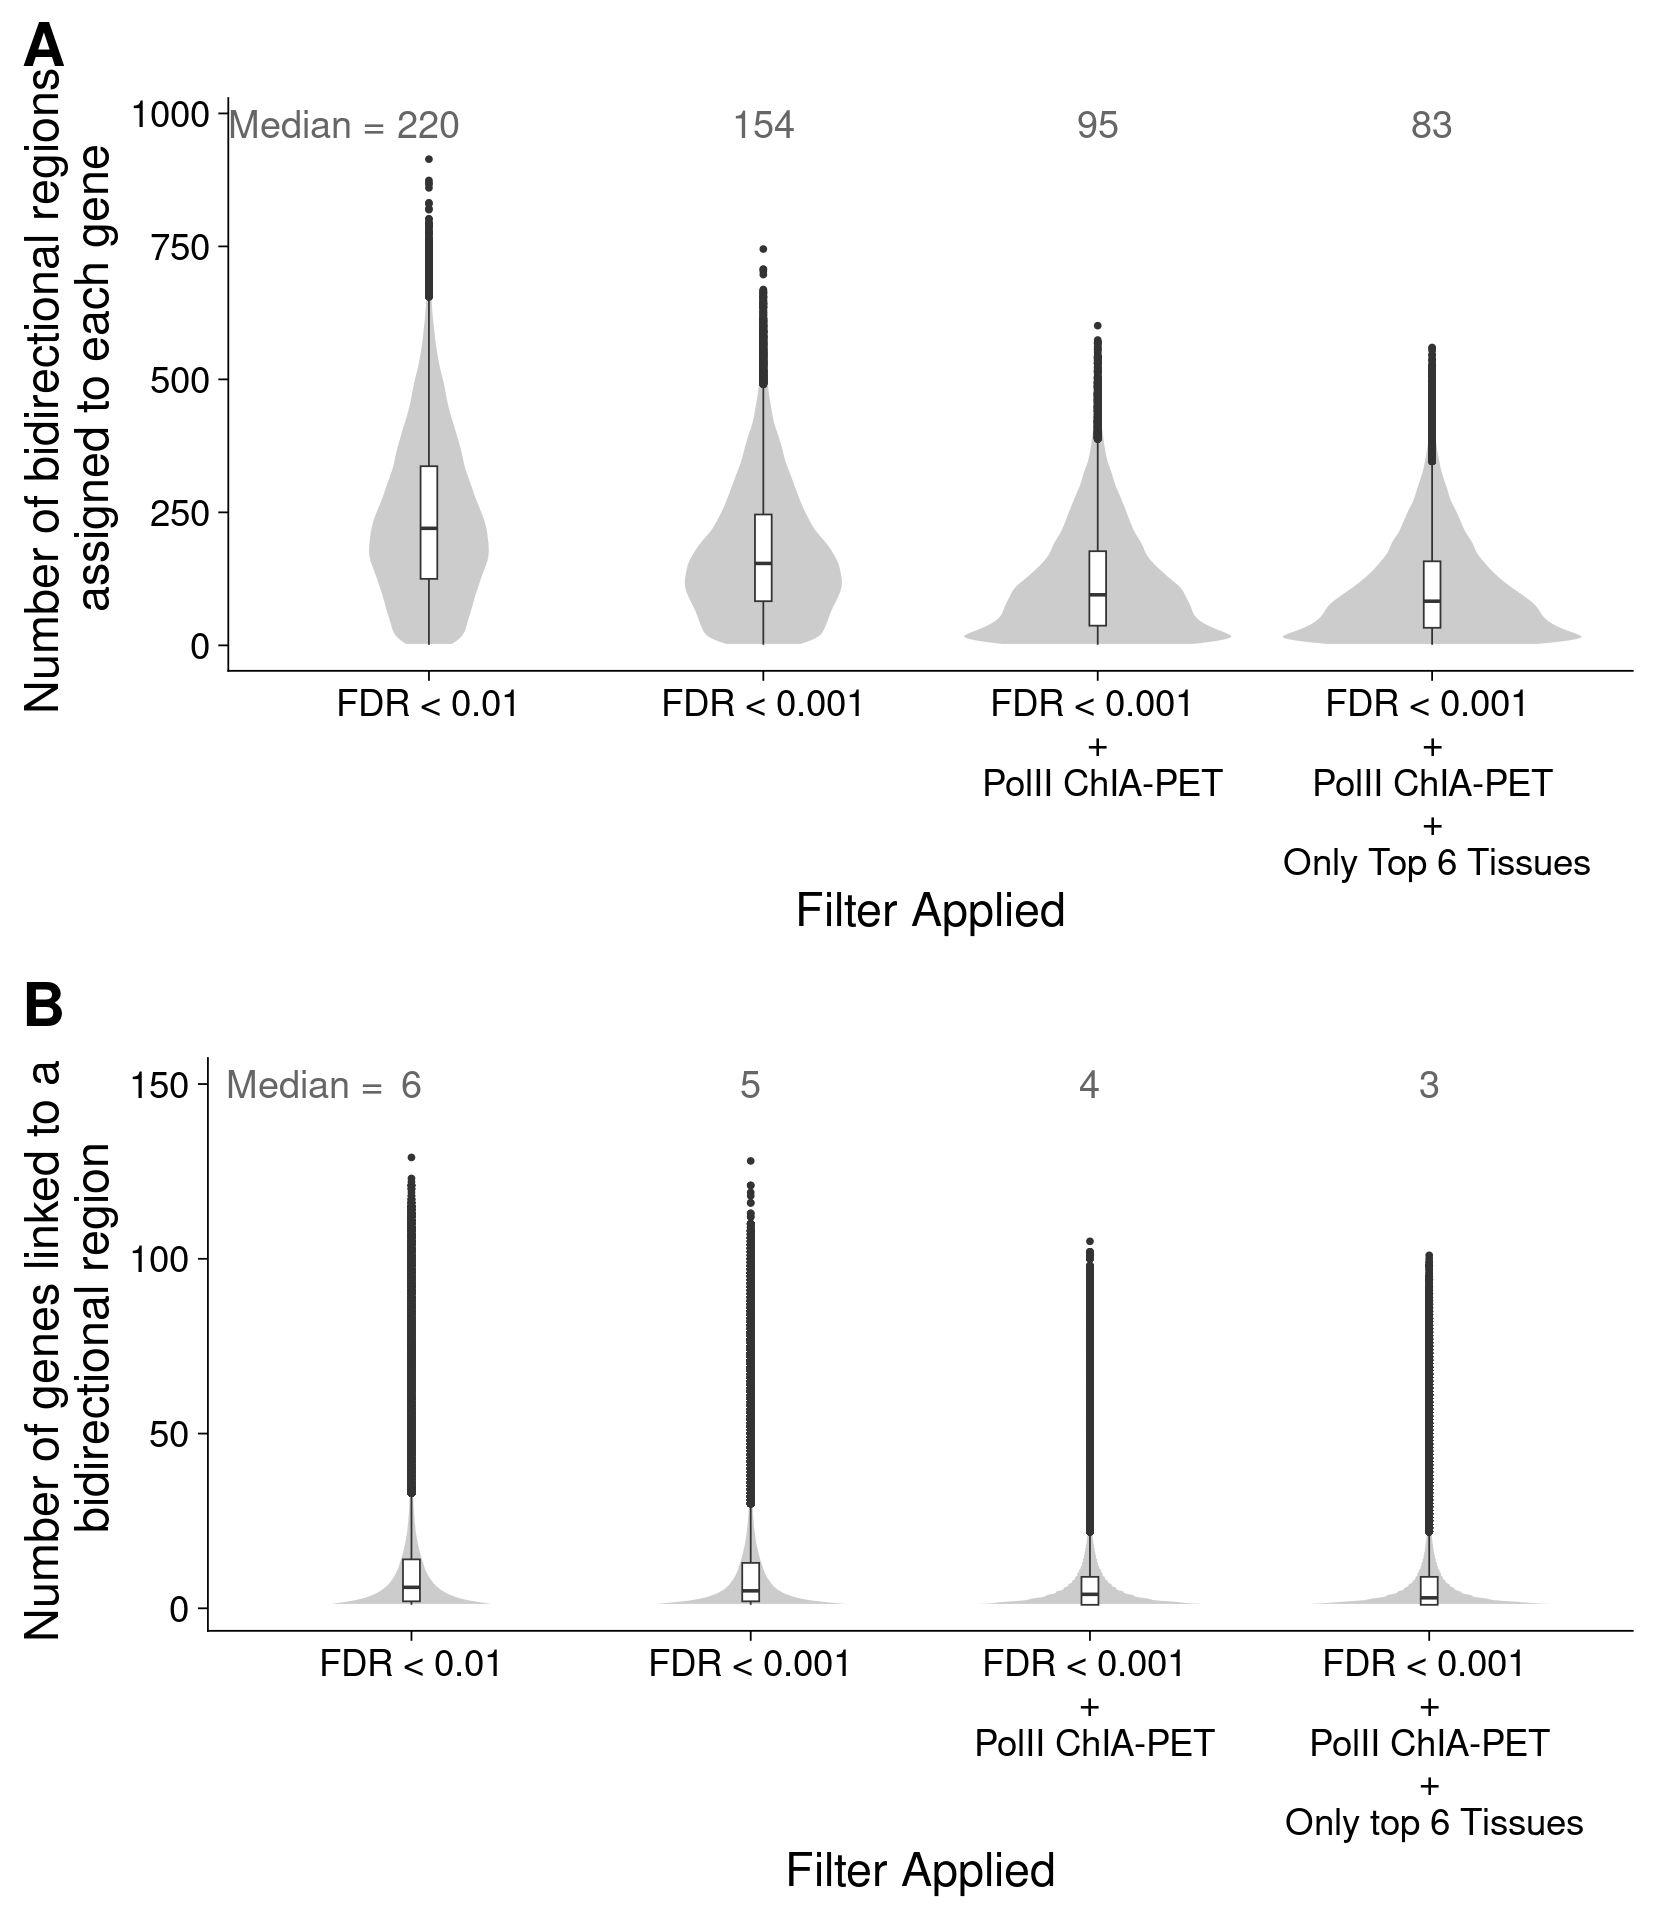

In [109]:
options(repr.plot.width=14, repr.plot.height=16)

summary_num_links_violin_plot <- cowplot::plot_grid(summary_num_bidirs_per_gene_violinplot,
                                                    summary_num_genes_per_bidir_violinplot, 
                                                   nrow=2,
                                                   labels = c('A', 'B'),
                                                   label_size = 36)
summary_num_links_violin_plot

In [110]:
ggsave(summary_num_links_violin_plot, width = 14, height = 16,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/summary_num_links_violin_plot_reviews.pdf',
      bg = "transparent")

ggsave(summary_num_links_violin_plot, width = 14, height = 16,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/summary_num_links_violin_plot_reviews.png',
      bg = "transparent")

# Summary of pairs : By Tissue

## Bidirectionals assigned to gene 

In [111]:
unique(corr_sig_strict_DT$tissue)

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [112]:
head(tissue_counts_sort$tissues, 11)

[1] blood          breast         kidney         uterus         intestine     
 [6] prostate       embryo         lung           skin           heart         
[11] umbilical cord
19 Levels: blood breast kidney uterus intestine prostate embryo lung ... testis

In [113]:
#tissues <- unique(corr_sig_strict_DT$tissue)
tissues <- head(tissue_counts_sort$tissues, 11)

hist_plot_list <- vector(mode='list', 
                            length=length(tissues))

for (i in 1:length(tissues)){
    
    print("-----------------------------------------------")
    print(paste("Tissue :",tissues[i]))
    
    sig_tissue_filtered <- subset(corr_sig_loop_DT, tissue == tissues[i])
    
    ##get pairs
    sig_tissue_filtered_unique <- unique(sig_tissue_filtered[,c('transcript1_chrom', 
                                                            'pair_id',
                                                            'transcript_1', 
                                                            'transcript_2')])

    ##count the number of bidirs per gene
    num_bidirs_per_gene_tissue <- as.data.frame(table(sig_tissue_filtered_unique$transcript_1))

    print(paste("Median bidirectionals assigned = ", 
                round(median(num_bidirs_per_gene_tissue$Freq))))
    
    num_bidirs_per_gene_tissue_plot <- ggplot(num_bidirs_per_gene_tissue, aes(x = Freq)) + 
    geom_histogram(color="black", fill="gray80", bins=40) +
    theme_cowplot(24) + 
    geom_vline(xintercept = median(num_bidirs_per_gene_tissue$Freq),
               linetype="dashed", 
               color = "gray40", 
               size=1) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    ggtitle(tissues[i]) +
    xlab("Bidirectional regions assigned to a gene") +
    ylab("Count") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 30), 
          axis.title = element_text(size = 26), 
          axis.text.x = element_text(size = 24),
          axis.text.y = element_text(size = 24)) 
    
    #add median counts 
    num_bidirs_per_gene_tissue_plot2 <- num_bidirs_per_gene_tissue_plot + annotate(geom="text", 
                                          x=round(0.5*max(num_bidirs_per_gene_tissue$Freq)), 
                                          y=round(0.5*max(ggplot_build(num_bidirs_per_gene_tissue_plot)$data[[1]]$count)), 
                                          size=10,
                                          label=paste0("Median = ", 
                                                       round(median(num_bidirs_per_gene_tissue$Freq))),
                                          color="gray40")
    
    hist_plot_list[[i]] <- num_bidirs_per_gene_tissue_plot2
    
    print("-----------------------------------------------")
}

[1] "-----------------------------------------------"
[1] "Tissue : blood"
[1] "Median bidirectionals assigned =  40"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : breast"
[1] "Median bidirectionals assigned =  34"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : kidney"
[1] "Median bidirectionals assigned =  26"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : uterus"
[1] "Median bidirectionals assigned =  11"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : intestine"
[1] "Median bidirectionals assigned =  15"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : prostate"
[1] "Median bidirectionals assigned =  25"
[1] "-------

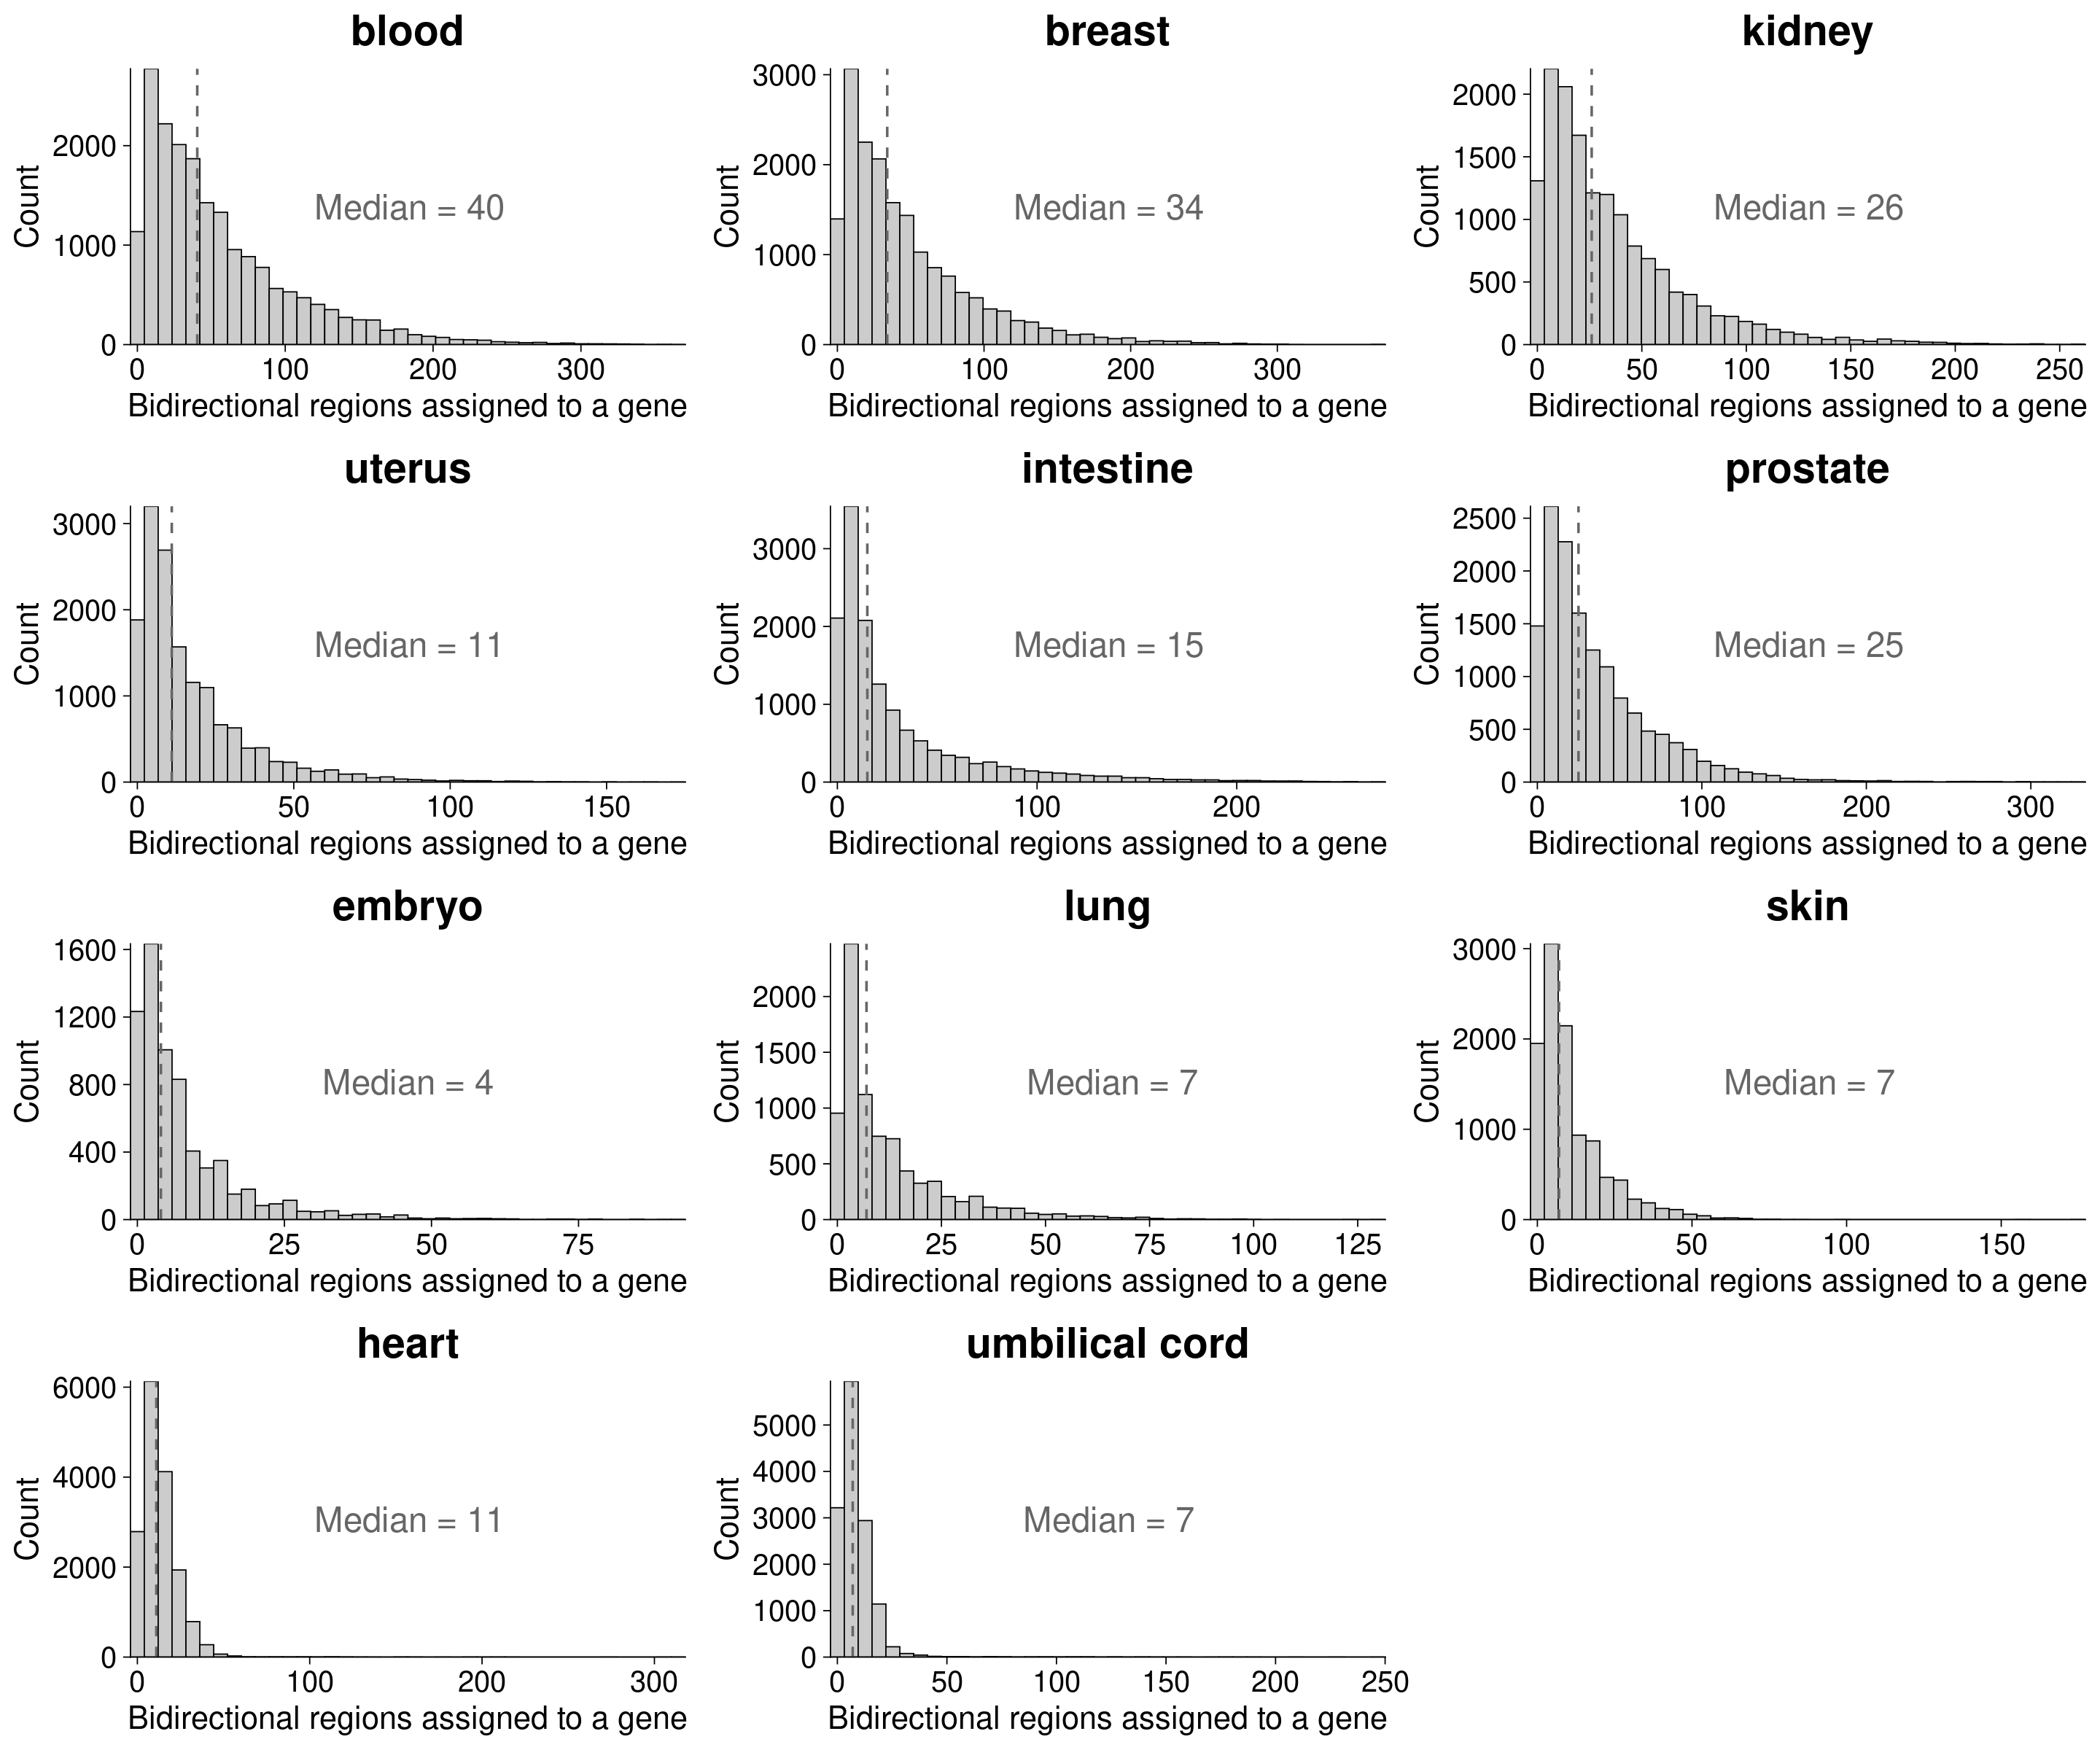

In [114]:
options(repr.plot.width=24, repr.plot.height=20)
num_bidirs_per_gene_all_tissues <- cowplot::plot_grid(plotlist = hist_plot_list, ncol = 3)
num_bidirs_per_gene_all_tissues

In [115]:
ggsave(num_bidirs_per_gene_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_all_tissues_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_bidirs_per_gene_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_bidirs_per_gene_all_tissues_plot_reviews.png',
      bg = "transparent")

## Genes linked to a bidirectional

In [116]:
gene_hist_plot_list <- vector(mode='list', 
                            length=length(tissues))

for (i in 1:length(tissues)){
    
    print("-----------------------------------------------")
    print(paste("Tissue :",tissues[i]))
    
    
    sig_tissue_filtered <- subset(corr_sig_loop_DT, tissue == tissues[i])
    
    ##get pairs
    sig_tissue_filtered_unique <- unique(sig_tissue_filtered[,c('transcript1_chrom', 
                                                            'pair_id',
                                                            'transcript_1', 
                                                            'transcript_2')])

    ##count the number of bidirs per gene
    num_genes_per_bidir_tissue <- as.data.frame(table(sig_tissue_filtered_unique$transcript_2))

    print(paste("Median genes assigned = ", 
                round(median(num_genes_per_bidir_tissue$Freq))))
    
    num_genes_per_bidir_tissue_plot <- ggplot(num_genes_per_bidir_tissue, aes(x = Freq)) + 
    geom_histogram(color="black", fill="gray80", bins=40) +
    theme_cowplot(24) + 
    geom_vline(xintercept = median(num_genes_per_bidir_tissue$Freq),
               linetype="dashed", 
               color = "gray40", 
               size=1) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    ggtitle(tissues[i]) +
    xlab("Genes linked to a bidirectional region") +
    ylab("Count") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(plot.title = element_text(hjust = 0.5),
          title = element_text(size = 30), 
          axis.title = element_text(size = 26), 
          axis.text.x = element_text(size = 24),
          axis.text.y = element_text(size = 24)) 

     #add median counts  
     num_genes_per_bidir_tissue_plot2 <- num_genes_per_bidir_tissue_plot + annotate(geom="text", 
             x=round(0.5*max(num_genes_per_bidir_tissue$Freq)),
             y=round(0.5*max(ggplot_build(num_genes_per_bidir_tissue_plot)$data[[1]]$count)), 
             size=10,
             label=paste0("Median = ", 
                          round(median(num_genes_per_bidir_tissue$Freq))),
             color="gray40") 
    
    gene_hist_plot_list[[i]] <- num_genes_per_bidir_tissue_plot2
    
    print("-----------------------------------------------")
}

[1] "-----------------------------------------------"
[1] "Tissue : blood"
[1] "Median genes assigned =  3"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : breast"
[1] "Median genes assigned =  3"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : kidney"
[1] "Median genes assigned =  3"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : uterus"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : intestine"
[1] "Median genes assigned =  2"
[1] "-----------------------------------------------"
[1] "-----------------------------------------------"
[1] "Tissue : prostate"
[1] "Median genes assigned =  4"
[1] "-----------------------------------------------"
[1] "-------------

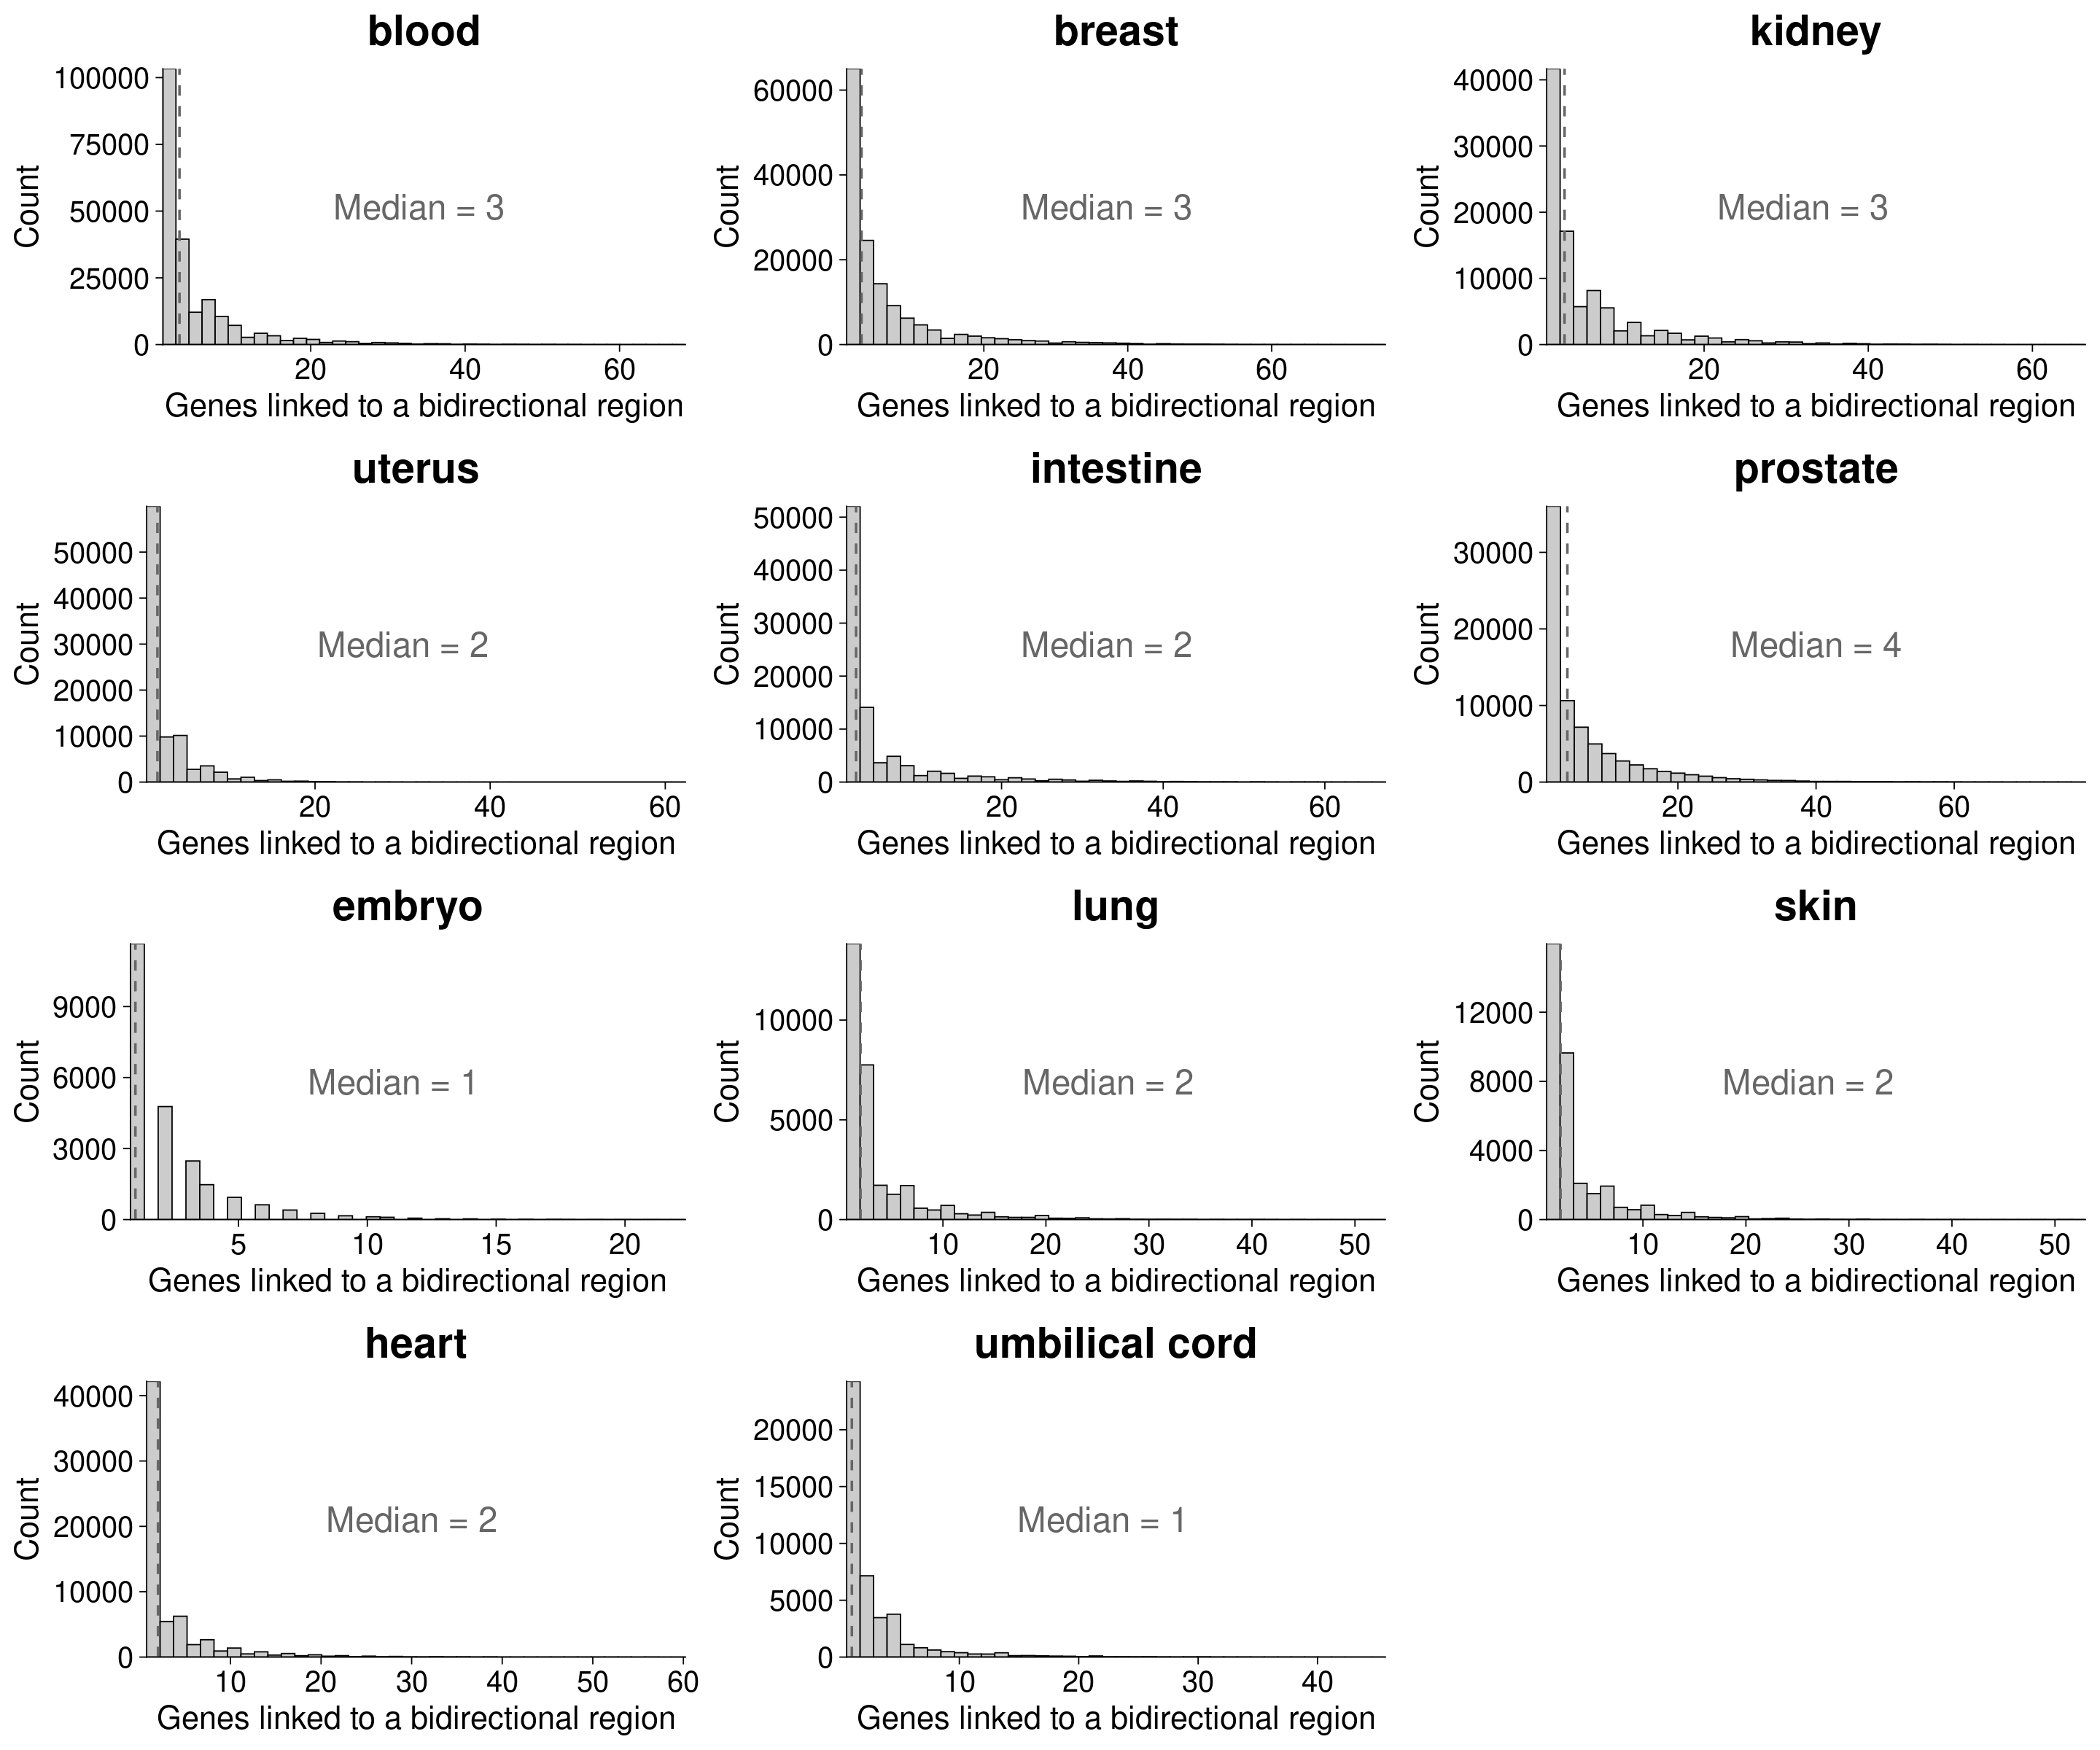

In [117]:
options(repr.plot.width=24, repr.plot.height=20)
num_genes_per_bidir_all_tissues <- cowplot::plot_grid(plotlist = gene_hist_plot_list,
                                                      ncol = 3)
num_genes_per_bidir_all_tissues

In [118]:
ggsave(num_genes_per_bidir_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_all_tissues_plot_reviews.pdf',
      bg = "transparent")

ggsave(num_genes_per_bidir_all_tissues, width = 24, height = 20,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/num_loop_genes_per_bidir_all_tissues_plot_reviews.png',
      bg = "transparent")

## Example genes

In [137]:
gene_bidirs_by_tissue <- function(sig_pairs, metadata, gene_id){

    gene_pairs <- sig_pairs[grepl(gene_id,sig_pairs$transcript_1),]
    
    gene_pairs$tissues <- factor(gene_pairs$tissue,
                            levels=sort(unique(metadata$tissue)))

    #for each gene, get tissue
    gene_tissues <- unique(gene_pairs$tissue)

    #for each tissue assign bidirectionals per gene
    gene_bidirs_tissue_list <- list()
    for (i in 1: length(gene_tissues)){

        tissue_name <- gene_tissues[[i]]
        gene_bidirs_tissue_list[[tissue_name]] <- subset(gene_pairs, 
                                                         tissue == tissue_name)$transcript_2

    }
    
    return(gene_bidirs_tissue_list)
}

### MYC

In [138]:
myc_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=corr_sig_loop_DT, 
                                                metadata=metadata_celltype, 
                                                gene_id="MYC:")

Warning message in grepl(gene_id, sig_pairs$transcript_1):
“argument 'pattern' has length > 1 and only the first element will be used”


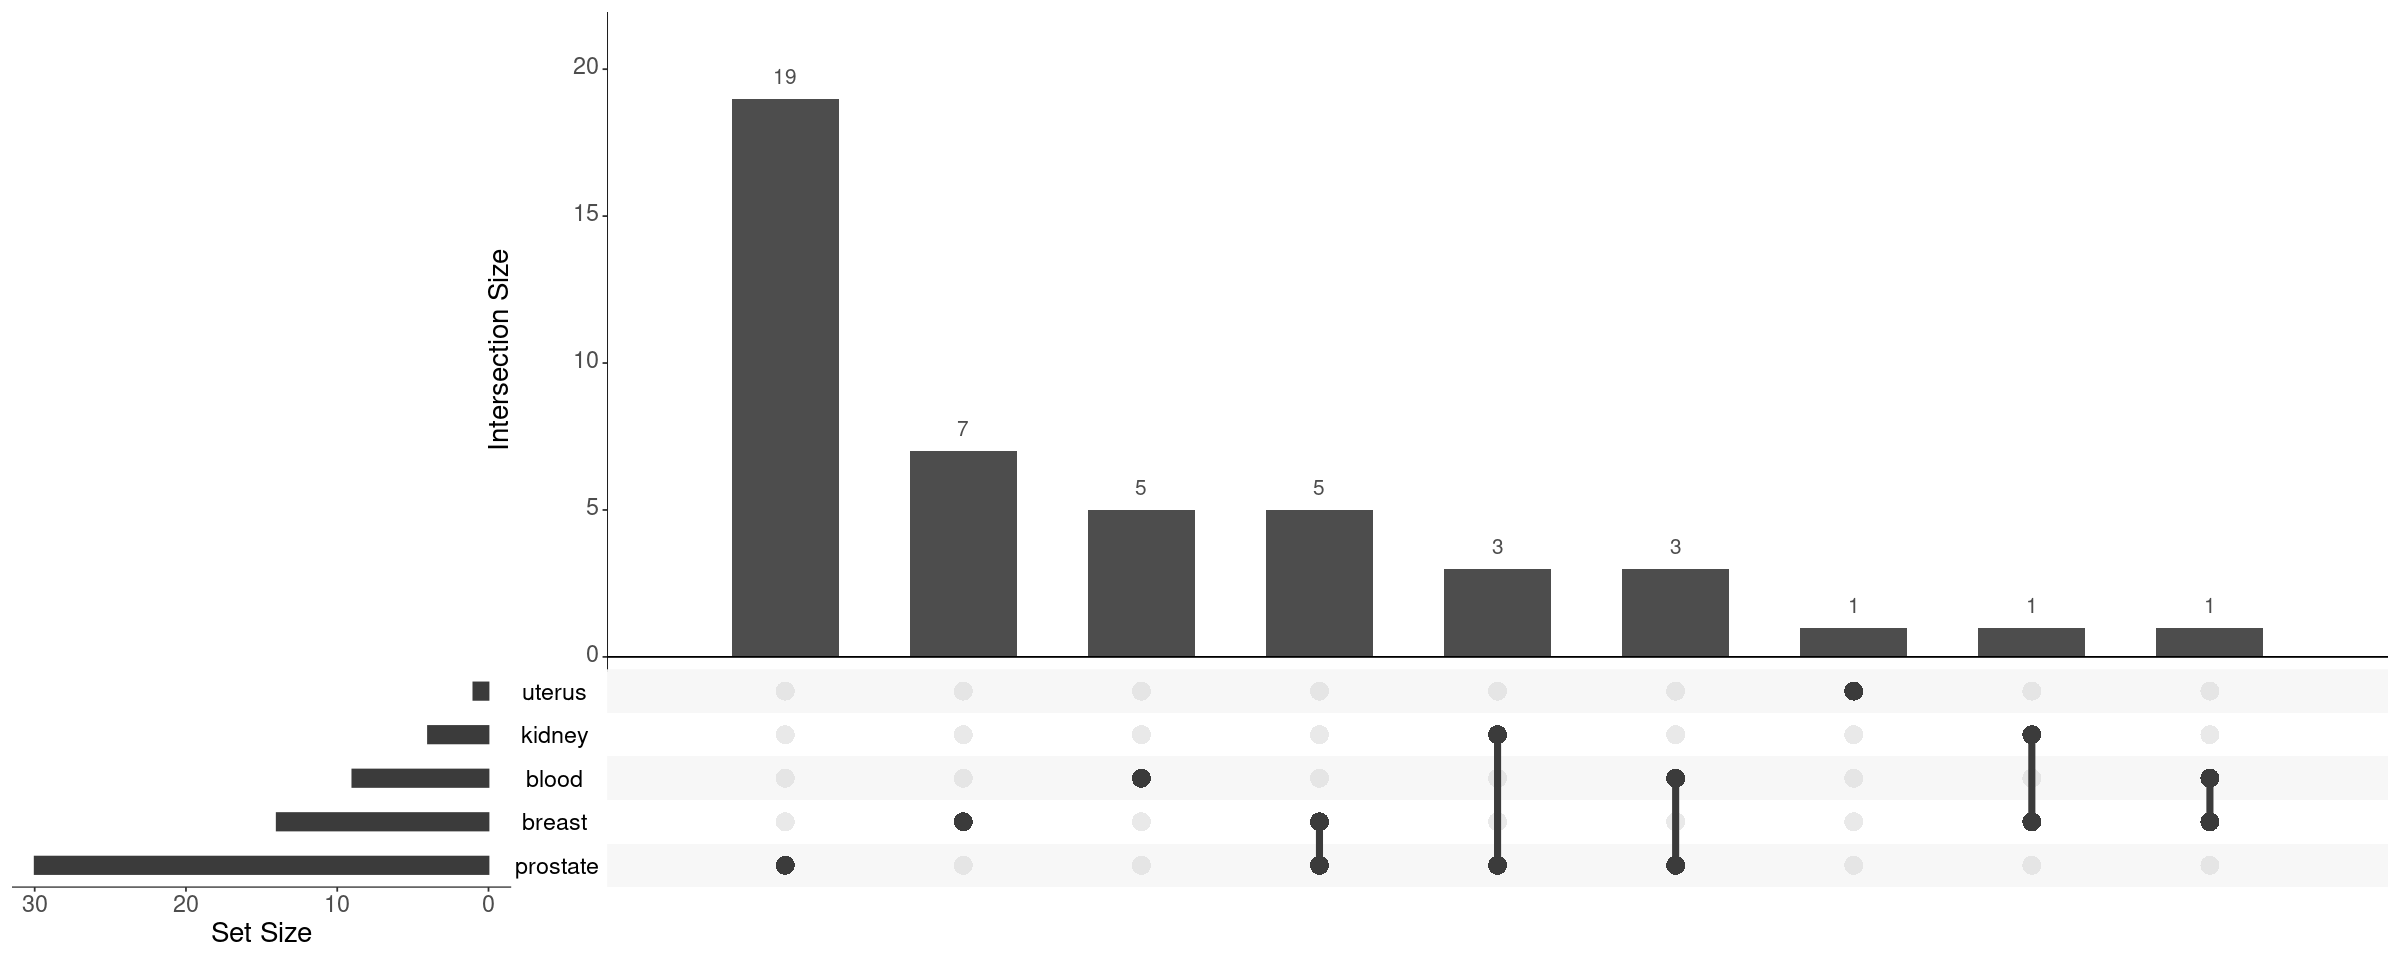

In [139]:
options(repr.plot.width=20, repr.plot.height=8)

myc_pair_summary_upset <- UpSetR::upset(fromList(myc_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        #plot.title="Bla",  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

myc_pair_summary_upset

### HCG18

In [140]:
hcg18_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=corr_sig_loop_DT, 
                                                metadata=metadata_celltype, 
                                                gene_id="HCG18:")

Warning message in grepl(gene_id, sig_pairs$transcript_1):
“argument 'pattern' has length > 1 and only the first element will be used”


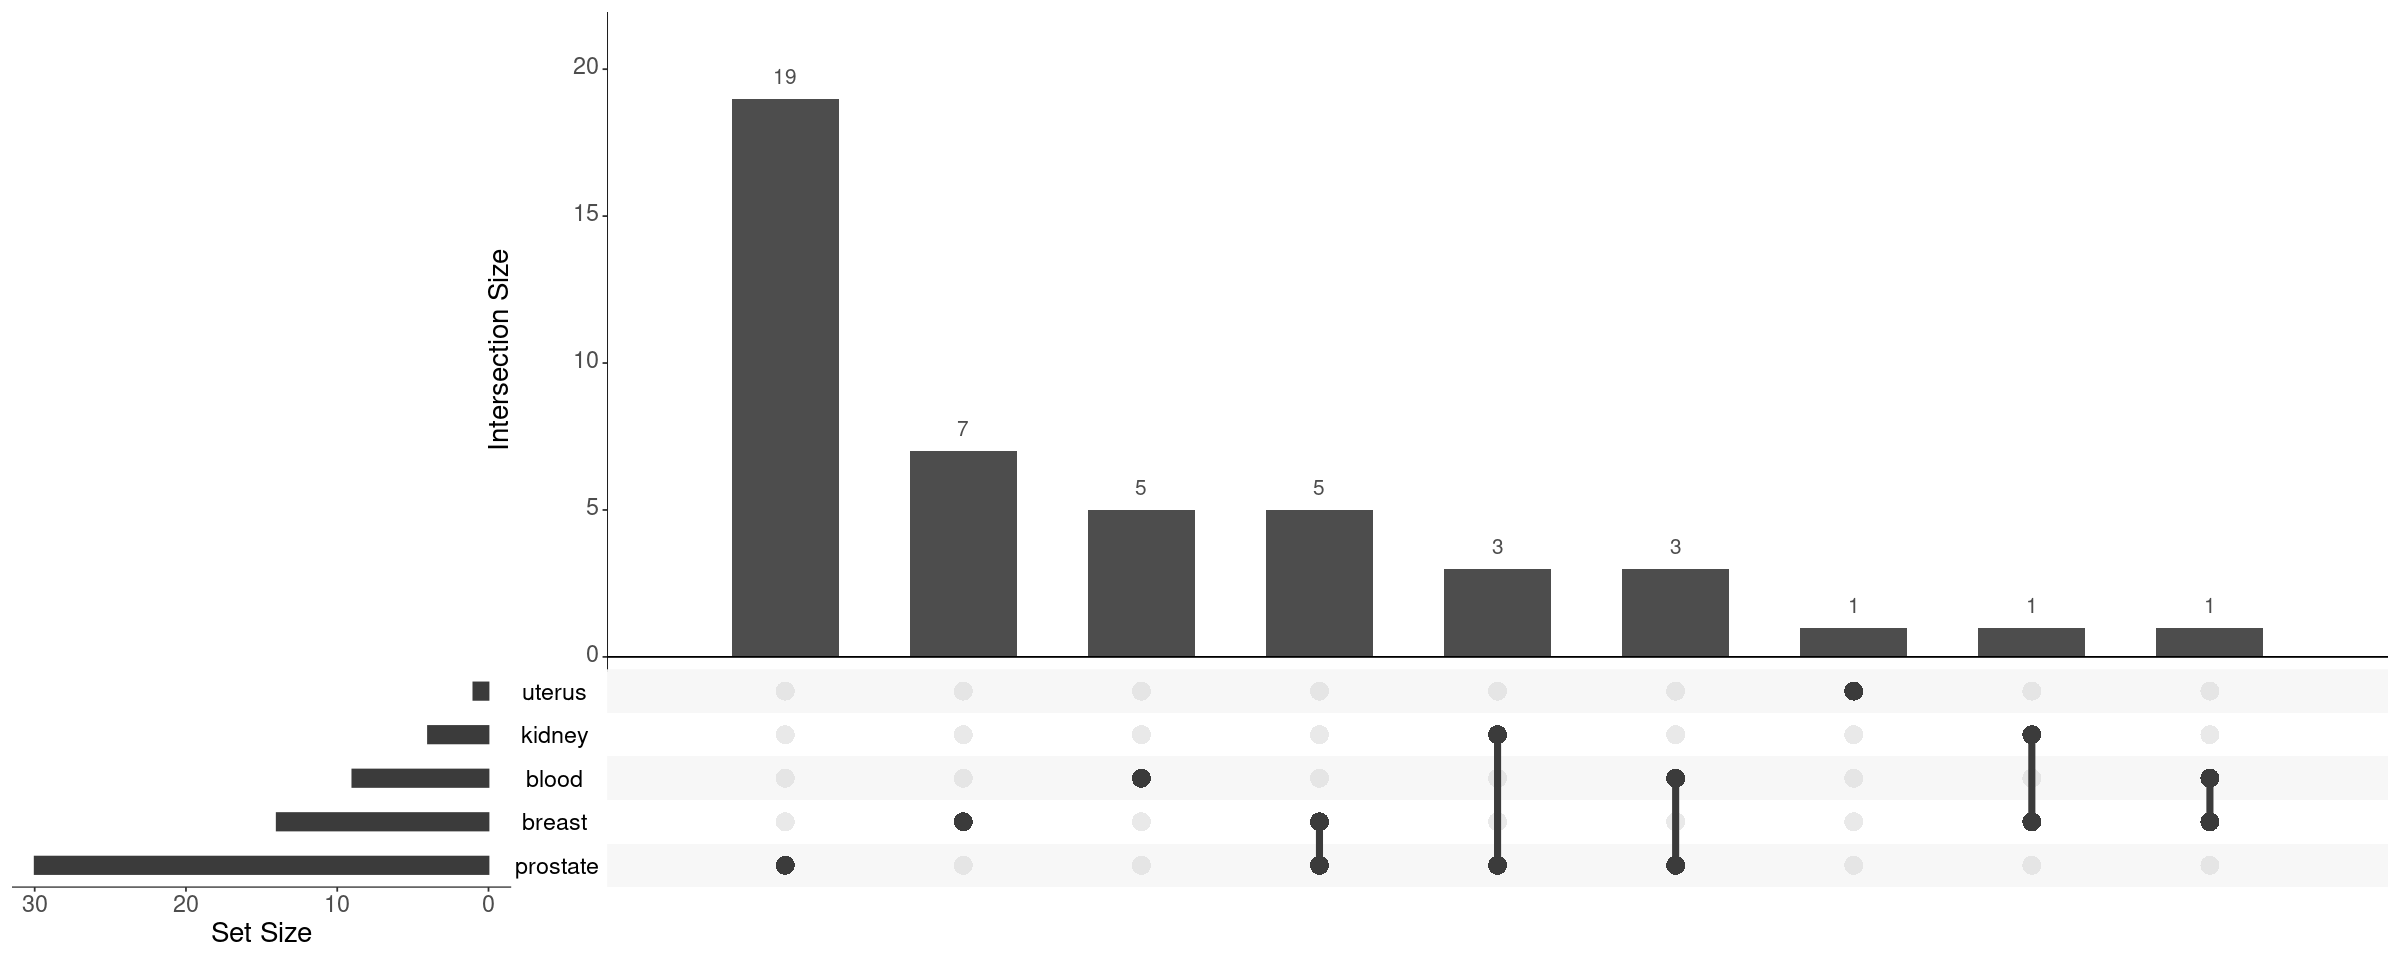

In [141]:
options(repr.plot.width=20, repr.plot.height=8)

hcg18_pair_summary_upset <- UpSetR::upset(fromList(hcg18_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

hcg18_pair_summary_upset

### RUNX1

In [142]:
runx1_bidirs_tissue_list <- gene_bidirs_by_tissue(sig_pairs=corr_sig_loop_DT, 
                                                metadata=metadata_celltype, 
                                                gene_id="RUNX1:")

Warning message in grepl(gene_id, sig_pairs$transcript_1):
“argument 'pattern' has length > 1 and only the first element will be used”


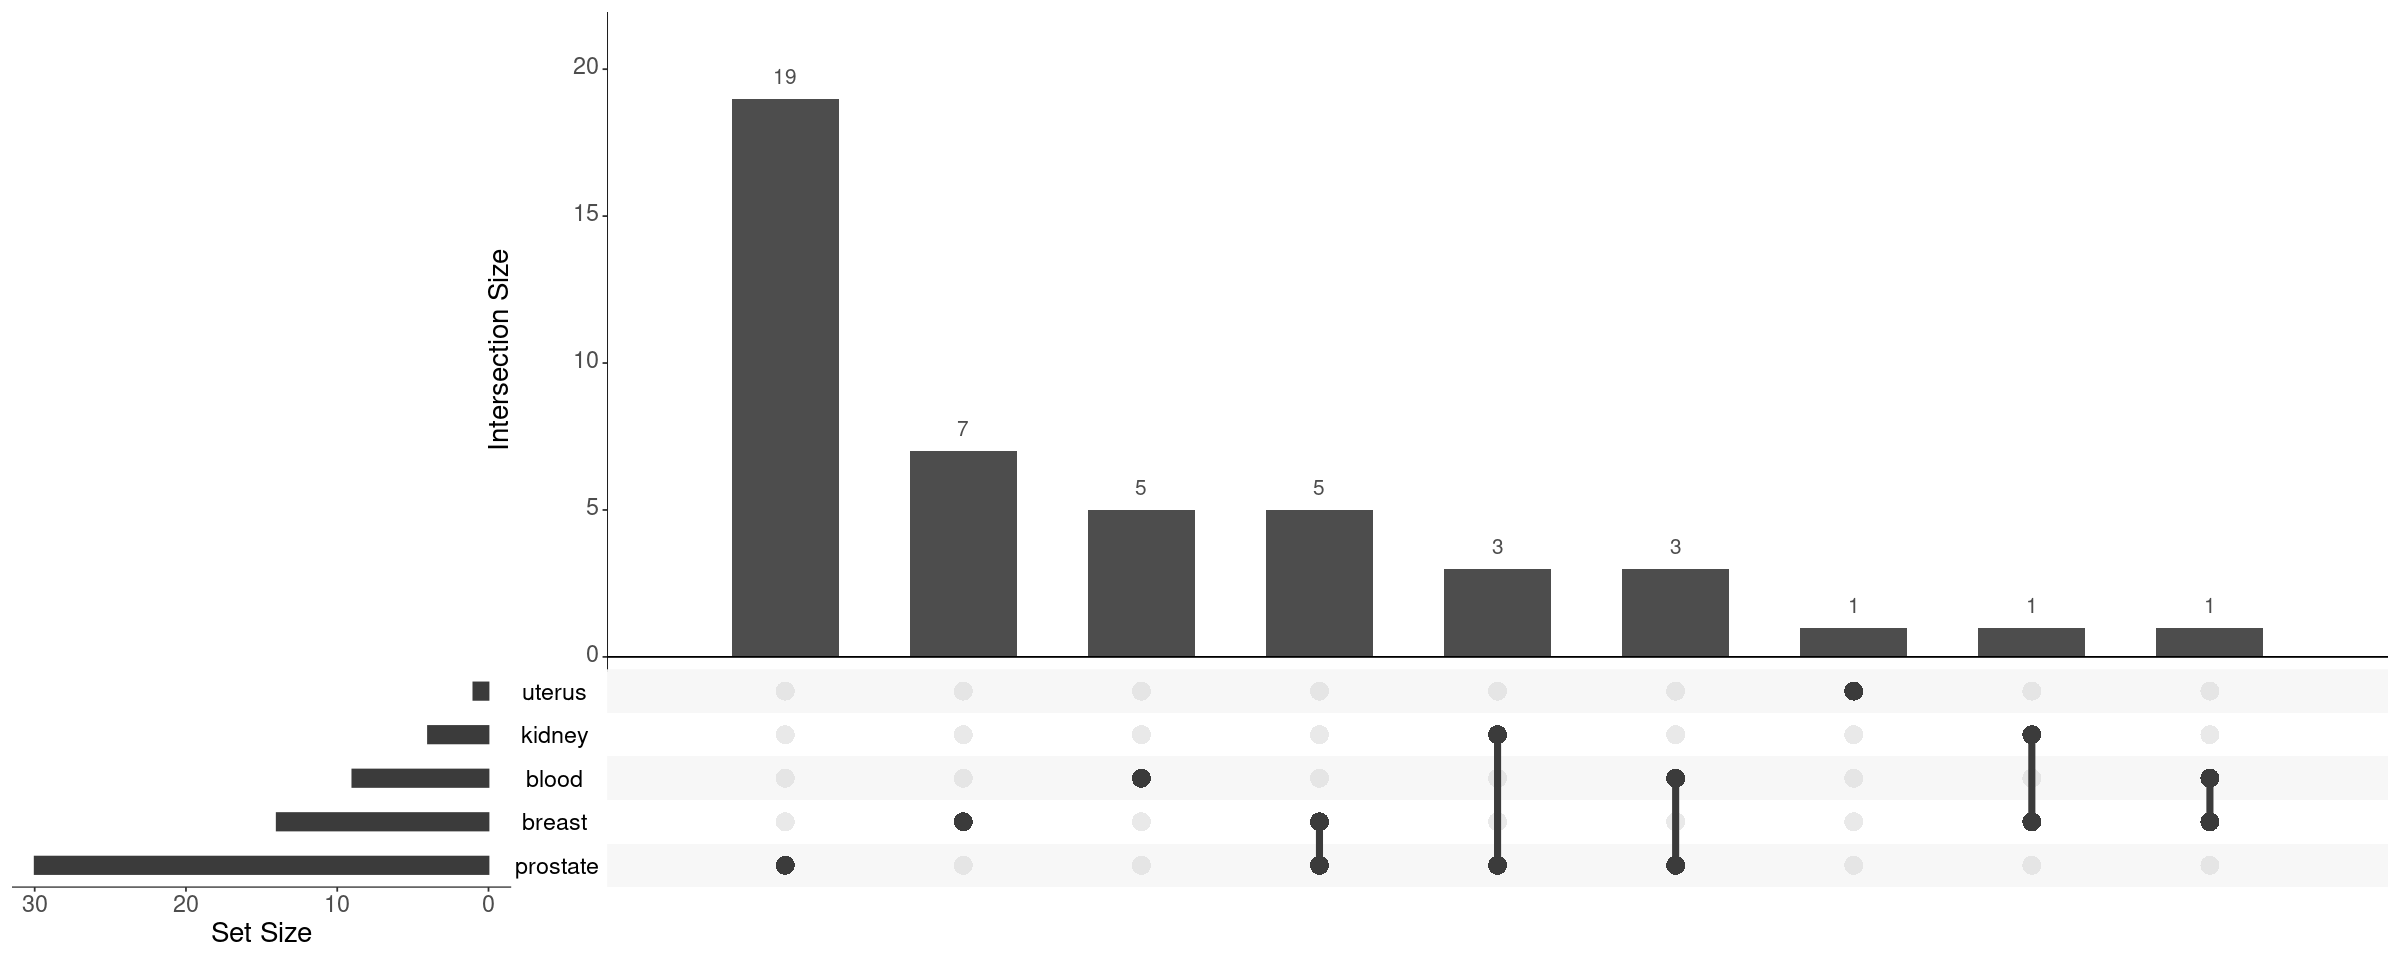

In [143]:
options(repr.plot.width=20, repr.plot.height=8)

runx1_pair_summary_upset <- UpSetR::upset(fromList(runx1_bidirs_tissue_list), 
                                        nsets = 100,
                                        nintersects = NA,  
                                        main.bar.color = "grey30",                                   
                                        order.by = "freq",
                                        point.size = 5,
                                        line.size = 2 ,
                                        text.scale = 2,
                                        set_size.show = FALSE) 

runx1_pair_summary_upset

# Session information

In [144]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] plyr_1.8.9          VennDiagram_1.7.3   futile.logger_1.4.3
[4] ggvenn_0.1.10       dplyr_1.1.4         UpSetR_1.4.0       
[7] cowplot_1.1.3       ggplot2_3.5.1       data.table_1.16.2  

loaded via a namespace (and not attached):
 [1] gtable_0